<span style="font-size:17pt; color:gold">Data Processing-Analysis - *Segmentation-free* </span> <br /> 
<span style="font-size:14pt; color:dodgerblue">Medulloblastoma *Resolve*, *Vizgen*, *Visium* *Xenium*, *RNAScope* (add-on) comparison </span> <br /> 
<span style="font-size:14pt; color:gold">using spatially binned molecules coords</span> <br /> 
<span style="font-size:12pt; color:orange">..in `micron` space </span> <br />
<span style="font-size:11pt; color:hotpink; background-color:black">using several samples -> ***MB299, 295, 266, 263*** </span>  <br /> 
<span style="font-size:11pt; color:hotpink; background-color:black">using only -> ***MB295, 266*** samples for *Vizgen* (2nd run) </span>  <br />

In [1]:
### make sure all libs are installed a priori!
## load libs ----
    suppressPackageStartupMessages({
    library(ggplot2)
    library(ggdark)
    library(ggpubr)
    library(scater)
    library(Seurat)
    library(dplyr)
    library(magrittr)
    library(png)
    library(cowplot)
    library(parallel)
    library(harmony)
    library(cetcolor)
    library(gridExtra)
    library(plotly)
    library(ggridges)
    library(jpeg)
    library(scales)    
    library(fields)
    library(spatstat)
    library(patchwork)
    library(Matrix)
    library(progressr)  
    library(terra)
    library(BiocParallel)
    library(sf)
})

In [2]:
# set R options, paths, object params, names, functions, etc..
message("Setting options, paths and object params..")
Sys.setenv(LANG = "en")
# ..to visualize huge array, standard notation vs scientific one, digits after comma.
options(max.print = 6e+5, scipen = 500, digits = 6)

# set maximum for object size
# [Parallelization in Seurat](https://satijalab.org/seurat/articles/future_vignette.html)
# for global variables size, if default limit is smaller..
message("Setting default limit for globar vars size: ", 
        paste0("~", round((50000 * 1024^2) / 1e+9), "G RAM"))
options(future.globals.maxSize = 50000 * 1024^2)

#' To get metadata df from sfe object
    #' @param object SFE or Seurat object
    #' @noRd
    getMeta <- function(object = NULL) {
      if (class(object) == "Seurat") {
        #is(object, "Seurat")
        # return Seurat metadata
        return(slot(object, name = "meta.data"))
        } else {
        #return(colData(object) |> slot(name = "listData") |> as.data.frame.list())
          return(colData(object) |> 
         methods::slot(name = "listData") |> 
         as.data.frame.list())
        }
      }

# set root dir
dir_working <- "./segmentation_free/"
dir_path <- file.path(dir_working, "objects")
setwd(dir_working)
#assay.name <- "Vizgen_Resolve"

## some Resolve samples info
    # A2(W4A1, MB263)
    # B2 (W5A1, MB266)
    # C2-1 (W6A1, MB295) 
    # C2-2 (W6A2, MB295)
    # D2 (W7A1, MB299)

# font and other params ----
# set global options for ggrepel 
# [ggrepel](https://ggrepel.slowkow.com/articles/examples.html)
options(ggrepel.max.overlaps = 60)
if (!exists("family.base")) { family.base = "Arial" } # base family for plots
# to have ["sharp" plots](https://github.com/IRkernel/IRkernel/issues/604#issuecomment-736378482)
# ..[font for plots](https://github.com/IRkernel/IRkernel/issues/604#issuecomment-736640324)
Cairo::CairoFonts(
    regular = paste0(family.base,":style=Medium"),
    bold = paste0(family.base,":style=Bold"),
    italic = paste0(family.base,":style=Oblique"),
    bolditalic = paste0(family.base,":style=BoldOblique"),
    symbol = paste0(family.base,":style=Oblique"))
options(bitmapType = "cairo")

# set mc.cores from parallel packages
message("Total cores for parallelization with `parallel`: ", parallel::detectCores()) # how many cores in total
message("Total workers/cores for parallelization with `BiocParallel`: ", BiocParallel::multicoreWorkers())
# set 25% of total cores
mc.cores <- quantile(detectCores() %>% seq)[2] %>% round
message(names(mc.cores), " of total cores `parallel`: ", mc.cores)
bp.workers <- quantile(BiocParallel::multicoreWorkers() %>% seq)[2] %>% round 
message(names(bp.workers), " of total workers `BiocParallel`: ", bp.workers)


Setting options, paths and object params..

Setting default limit for globar vars size: ~52G RAM

Total cores for parallelization with `parallel`: 72

Total workers/cores for parallelization with `BiocParallel`: 70

25% of total cores `parallel`: 19

25% of total workers `BiocParallel`: 18



In [3]:
package.version("Seurat")
package.version("SeuratObject")

[1] "4.3.0.9002"

[1] "4.1.3"

In [4]:
# load modified subset function
source("./scripts/subset_obj_seurat_v2.R")

In [5]:
# Sanity function
sanity.seurat <- function(obj = NULL) {
  # check for genes
  gene.index <- c((GetAssayData(obj) %>% rowSums) == 0)
  if (gene.index %>% any) {
    n.genes <- which(gene.index)
    message("Total of ", n.genes %>% length, 
            " have 0 expression in all cells", "\n",
            ">>> removing these genes..")
    obj %<>% subset_opt(features = rownames(obj)[-n.genes])
  } else { message("Sanity passed:", "\n",
                   ">>> A single gene is expressed in least 1 cell", "\n", 
                   ">>> No genes have 0 expression in all cells") }
  
  # check for cells
  cell.index <- c((GetAssayData(obj) %>% colSums) == 0)
  if (cell.index %>% any) {
    message("Removing cell with 0 transcript counts")
    obj %<>% subset_opt(cells = -which(cell.index))
  } else { message("Sanity passed:", "\n", 
                   ">>> All transcript counts > 0") }
  return(obj)
}

#### <span style="font-size:12pt; color:gold"> Generate *image-based* spatial Seurat object from Visium (*spots under tissue*) data  </span>
<span style="font-size:10pt; color:tomato"> "NOTE: these chunks are for development of `LoadVisium` function only" </span> <br /> 


In [ ]:
# prepate file paths for each spaceranger outs folder, ie - per sample
dir_visium <- "./Medulloblastoma_Visium/"
files2read <- 
  list.files(dir_visium,
             pattern = "^outs", include.dirs = TRUE, 
             recursive = TRUE, full.names = TRUE)
files2read %>% str

i <- 1
spaceranger.outs <- files2read[i]
spaceranger.outs
sample.name <- NULL
features <- NULL
coord.space <- "micron"
fov <- NULL

In [ ]:
# Sanity checks for files in spaceranger output ----
check.files <- list.dirs(spaceranger.outs, 
                         full.names = FALSE, 
                         recursive = FALSE)
check.files <-
  match.arg(arg = c("filtered_feature_bc_matrix", "spatial"), 
            choices = grep("feature_bc_matrix|spatial", check.files, value = TRUE), 
            several.ok = TRUE)

if(is.empty(check.files)) {
  stop("Provided SpaceRanger '/outs' folder must contain:", 
       paste0("\n", c("filtered_feature_bc_matrix.h5 # count matrix", 
                      "./spatial # folder with spatila infos")), 
       call. = FALSE)
}

if (is.null(sample.name)) {
  # use input path name, ie dir name before ../outs
  sample.name <- spaceranger.outs %>% 
    stringr::str_split(., pattern = "/") %>% 
    unlist %>% 
    tail(2) %>%
    head(1) %>% 
    { if (grep("out_|outs", .) %>% any) {
      stringi::stri_replace_all_regex(., pattern = "out_|outs", "")
    } else { (.) }}
}

# scaling factors for images/coords
json.file <- list.files(spaceranger.outs,
                        pattern = "^scalefactors_json", include.dirs = TRUE, 
                        recursive = TRUE, full.names = TRUE)

# get estimated pixel size ----
## see [output_spatial](https://support.10xgenomics.com/spatial-gene-expression/software/pipelines/latest/output/spatial)
## ie: spot_diameter_fullres: The number of pixels that span the diameter of a theoretical 65µm spot in the original, full-resolution image.
px.size <- c(65 / jsonlite::fromJSON(txt = json.file) %>% 
               data.table::as.data.table(.) %>% 
               pull(spot_diameter_fullres))

# get tissue positions files ----
tissue.positions.file <- list.files(spaceranger.outs,
                                    pattern = "^tissue_positions_list", include.dirs = TRUE, 
                                    recursive = TRUE, full.names = TRUE)
# read tissue coords..
tissue.position <- data.table::fread(input = tissue.positions.file,
                                     col.names = c('barcodes', 'tissue',
                                                   'row', 'col',
                                                   'imagerow', 'imagecol')) %>%
  # filter out..get spots under tissue
  filter(tissue == 1) %>%
  {
    if (coord.space == "micron") {
      # select coords and convert to microns
      transmute(., x = imagecol * px.size, 
                y = imagerow * px.size, 
                barcodes = barcodes)
    } else if (coord.space == "pixel") {
      # select coords, pixels are by default 
      transmute(., x = imagecol, 
                y = imagerow,
                barcodes = barcodes)
    }
  }

# read and prepare count matrix as dataframe ----
count.data.file <- list.files(spaceranger.outs, 
                              pattern = "^filtered_feature_bc_matrix.h5",
                              include.dirs = TRUE,
                              recursive = TRUE, full.names = TRUE)

# load count matrix
if (!is.null(features)) {
  # keep only selected features
  count.mat <- Read10X_h5(filename = count.data.file)[features,]
} else {
  # using all features 
  count.mat <- Read10X_h5(filename = count.data.file)
} 

# filtering:
count.df <- 
  count.mat %>%
  # convert to data.frame, genes as cols, spots as rows
  t %>% # transpose matrix
  data.table::as.data.table(.) %>%
  # add barcode ids
  set_rownames(colnames(count.mat))

# order spot coords as in the count matrix
tissue.position %<>% arrange(match(colnames(count.mat), 
                                   tissue.position %>% pull(barcodes)) %>% order)


In [176]:
# create Seurat object
obj.vis <- 
    count.mat %>% 
    CreateSeuratObject(assay = "Visium")
obj.vis 
obj.vis %>% getMeta %>% str

An object of class Seurat 
36601 features across 1977 samples within 1 assay 
Active assay: Visium (36601 features, 0 variable features)

'data.frame':	1977 obs. of  3 variables:
 $ orig.ident     : Factor w/ 1 level "SeuratProject": 1 1 1 1 1 1 1 1 1 1 ...
 $ nCount_Visium  : num  4003 10294 11790 15617 18075 ...
 $ nFeature_Visium: int  1885 3768 4133 4753 4886 4471 4832 4777 4148 4077 ...


In [177]:
# update metadata
#meta.df <- obj.vis@meta.data
#meta.df %>%
#    mutate(samples = sample.name,
#           donors = samples,
#           orig.ident = sample.name,
#           cell_id = Cells(obj.vis),
#           spatial_tech = "10X_Visium") %>% str

# replace metadata
obj.vis@meta.data %<>%
    mutate(samples = sample.name,
           donors = samples,
           orig.ident = sample.name,
           cell_id = Cells(obj.vis),
           spatial_tech = "10X_Visium")

obj.vis %>% getMeta %>% str

'data.frame':	1977 obs. of  7 variables:
 $ orig.ident     : chr  "MB263_D" "MB263_D" "MB263_D" "MB263_D" ...
 $ nCount_Visium  : num  4003 10294 11790 15617 18075 ...
 $ nFeature_Visium: int  1885 3768 4133 4753 4886 4471 4832 4777 4148 4077 ...
 $ samples        : chr  "MB263_D" "MB263_D" "MB263_D" "MB263_D" ...
 $ donors         : chr  "MB263_D" "MB263_D" "MB263_D" "MB263_D" ...
 $ cell_id        : chr  "AAACAAGTATCTCCCA-1" "AAACACCAATAACTGC-1" "AAACAGGGTCTATATT-1" "AAACCGGGTAGGTACC-1" ...
 $ spatial_tech   : chr  "10X_Visium" "10X_Visium" "10X_Visium" "10X_Visium" ...


<span style="font-size:11pt; color:gold"> create FOVs.. </span>  <br /> 

In [178]:
# (optionally) FOV - boxes
if (FALSE) {
  # spots coords +- 55/2µm of a given xy coord, use expand_grid to make box coords
  #..similar to `ReadVizgen`
  # faster version for grid construction
  pbapply::pboptions(type = "timer", style = 1, char = "=")
  boxes <- 
    pbapply::pblapply(tissue.position %>% nrow %>% seq, function(i) {
      # faster version for grid construction
      df <-
        data.table::CJ(x = c(tissue.position %>% slice(i) %>% pull(x) - 55 / 2, 
                             tissue.position %>% slice(i) %>% pull(x) + 55 / 2),
                       y = c(tissue.position %>% slice(i) %>% pull(y) - 55 / 2, 
                             tissue.position %>% slice(i) %>% pull(y) + 55 / 2), 
                       cell = tissue.position %>% slice(i) %>% pull(barcodes)) %>% 
        slice(c(1, 3, 4, 2))
      return(df)
    })
  
  boxes %<>% 
    data.table::rbindlist() %>% 
    CreateSegmentation(.)
  }

In [174]:
# (optional) FOV - molecules
# - repeted spot coord x UMI counts per gene (duplicated spots allowed??)-> molecules
# set to TRUE to run it
if (FALSE) {
  # generate spot/mols coords ----
  # prepare gene names
  features <- names(count.df)
  spot.mols.coord <- 
    BiocParallel::bplapply(features %>% length %>% seq, function(i) {
      spot.mols <-
        count.df %>% # gene expression only
        select(!!as.symbol(features[i])) %>%
        bind_cols(., tissue.position) %>%
        rename(gene = features[i]) %>%
        mutate(count.UMIs = gene, 
               gene = features[i], # replace counts with the gene name
               sample_name = sample.name,
               # add small deviation (ie remainder) for each spot coords
               #..except the 1st one.
               x = if (i != 1) { x + pull(., x) %% 1 } else { x },
               y = if (i != 1) { y + pull(., y) %% 1 } else { y }) %>%
        # filter for UMI counts > 0
        filter(count.UMIs > 0)
      
      # bind repeated df with previous df ie with UMIs == 1
      spot.mols %<>% 
        mutate(coord_space = coord.space)
      return(spot.mols)
    },
    BPPARAM = BiocParallel::MulticoreParam(15,
                                           tasks = 50L,
                                           force.GC = FALSE, 
                                           progressbar = TRUE)
    ) %>% data.table::rbindlist(.)
  }

# for molecule FOV
#spot.mols.coord %>% str


In [180]:
# FOV - centroids or spots
#  - spots -> centroids
cents <-
    tissue.position %>% 
    rename(cell = barcodes) %>% 
    CreateCentroids()

In [188]:
# add FOVs
if (exists("boxes")) {
  coords <- 
    CreateFOV(list(centroids = cents, 
                   boxes = boxes), 
              type = c("boxes", "centroids"),
              #molecules = , 
              assay = "Visium") %>%
    subset(x = .,
           cells = intersect(x = Cells(x = .[["boxes"]]),
                             y = Cells(x = obj.vis)))
} else { 
  coords <- 
    CreateFOV(list(centroids = cents), 
              type = c("centroids"),
              #molecules = , 
              assay = "Visium") %>%
    subset(x = .,
           cells = intersect(x = Cells(x = .[["centroids"]]),
                             y = Cells(x = obj.vis)))
  
  }

coords
fov <- sample.name
# sanity on fov name
fov %<>% gsub("_|-", ".", .)

obj.vis[[fov]] <- coords
obj.vis %<>% 
    UpdateSeuratObject() %>% 
    suppressMessages()
obj.vis


Spatial coordinates for 1977 cells
Default segmentation boundary: centroids 
Associated assay: Visium 
Key: Visium_ 

An object of class Seurat 
36601 features across 1977 samples within 1 assay 
Active assay: Visium (36601 features, 0 variable features)
 1 spatial field of view present: MB263.D

#### <span style="font-size:12pt; color:gold"> Make MBEN 10X Visium *image-based* spatial objects </span>
<span style="font-size:10pt; color:tomato"> "..ie, similar to *Resolve/Vizgen*" </span> 

In [ ]:
# prepate file paths for each spaceranger outs folder, ie - per sample
dir_visium <- "./Medulloblastoma_Visium/"
files2read <- 
  list.files(dir_visium,
             pattern = "^outs", include.dirs = TRUE, 
             recursive = TRUE, full.names = TRUE)
files2read %>% str


In [4]:
# load `LoadVisium` function
source("./scripts/visium2mols_seurat.R")

In [5]:
# make spatial (image-based objects)
pbapply::pboptions(type = "timer", style = 1, char = "=")
obj.list <- 
  pbapply::pblapply(files2read %>% seq, function(i) {
    LoadVisium(
      spaceranger.outs = files2read[i],
      features = NULL,
      sample.name = NULL,
      fov = NULL,
      coord.space = 'micron')
    })
obj.list

  |==================================================| 100% elapsed=36s, remaining~00s


[[1]]
An object of class Seurat 
36601 features across 1977 samples within 1 assay 
Active assay: Visium (36601 features, 0 variable features)
 1 spatial field of view present: mb263.d

[[2]]
An object of class Seurat 
36601 features across 2782 samples within 1 assay 
Active assay: Visium (36601 features, 0 variable features)
 1 spatial field of view present: mb266.c

[[3]]
An object of class Seurat 
36601 features across 2490 samples within 1 assay 
Active assay: Visium (36601 features, 0 variable features)
 1 spatial field of view present: mb295.b

[[4]]
An object of class Seurat 
36601 features across 2660 samples within 1 assay 
Active assay: Visium (36601 features, 0 variable features)
 1 spatial field of view present: mb299.a


In [7]:
# merge 
obj.vis <- merge(obj.list[[1]], obj.list[-1])
obj.vis

Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


An object of class Seurat 
36601 features across 9909 samples within 1 assay 
Active assay: Visium (36601 features, 0 variable features)
 4 spatial fields of view present: mb263.d mb266.c mb295.b mb299.a

In [16]:
# TODO:
# change FOV names
names(obj.vis@images) <- 
    gsub(".[a-z]", "", obj.vis@images %>% names) %>%
    paste0("mb", ., ".Visium")
obj.vis@images %>% names

[1] "mb263.Visium" "mb266.Visium" "mb295.Visium" "mb299.Visium"

In [17]:
# make target gene-matched and 4 samples object ----
# use selected markers that used for Vizgen and Resolve data..
features_vz <- 
  c("AIF1", "APOD", "AQP4", "ASTN1", "ATOH1", "BCAS1", "BMPR1B", 
    "BOC", "BRAF", "C5AR1", "CA10", "CCR7", "CD14", "CD163", "CD274", 
    "CD37", "CD4", "CD40", "CD44", "CD74", "CD83", "CDH5", "CDKN1A", 
    "CDKN2A", "CFAP44", "CNTN2", "CNTNAP5", "COL1A2", "CX3CR1", "DCAF4", 
    "DCN", "DDX31", "DIAPH3", "DLL3", "DRAXIN", "DSCAM", "EGFR", "EIF2AK3", 
    "EOMES", "EPHA8", "ERBB4", "ESRRG", "EZH2", "FCGR2A", "FCGR3A", "FOXJ1", 
    "FOXP2", "GABRA5", "GFI1", "GFI1B", "GLI1", "GLI2", "GLRA1", "GPR17", "GPR68", 
    "GRIA2", "GRIN2B", "GRM8", "HBG1", "HCAR3", "HHIP", "HLA-A", "HLA-B", "HLA-C", 
    "HLA-DPA1", "HLA-DPB1", "HLA-DRA", "HLA-DRB1", "HS6ST3", "IGDCC3", "IGF1", 
    "IGFBP7", "IL4", "ITGAM", "KCNH8", "KHDRBS2", "LAMA2", "LHFPL3", "LHX9", "LRRC4C", 
    "MEIS2", "MIR4435-2HG", "MKI67", "MOG", "MRC1", "MYC", "MYCN", "NCAM1", "NCAM2", 
    "NCKAP5", "NNAT", "NPAS3", "NRXN3", "OLIG2", "OPCML", "OTX2", "PAX6", "PBX3", "PCDH15", 
    "PDCD1LG2", "PDGFRA", "POU5F1B", "PPP1R17", "PRDM6", "PTCH1", "PTPRC", "PTPRO", 
    "PTPRZ1", "QKI", "RALYL", "RBFOX3", "RFTN2", "RIT2", "SEMA6A", "SLC35F3", "SRC", 
    "SV2B", "TLL1", "TMEM108", "TMEM119", "TMEM132D", "TNC", "TNR", "TOP2A", "TRIM9", 
    "TRPM3", "TULP1", "VTCN1", "ZFHX3", "CD19", "CD69", "CTLA4", "EPHA5", "GPC5", "GYPA", 
    "KIRREL2", "LMX1A", "PLEKHA7", "SNTG1", "TRPC3") %>% sort

# target genes from Resolve
features_re <- 
  c("AIF1","AQP4","ASTN1","BMPR1B","BOC","CA10","CCR7",
    "CD14","CD163","CD19","CD37","CD4","CD44","CD69","CD83",
    "CFAP44","CNTN2","CNTNAP5","COL1A2","CTLA4","DCAF4","DCN",
    "DDX31","DIAPH3","DRAXIN","DSCAM","EGFR","EOMES","EPHA5","EPHA8",
    "ERBB4","ESRRG","EZH2","FCGR3A","FOXJ1","FOXP2","GABRA5","GFI1",
    "GFI1B","GLI1","GLI2","GLRA1","GPC5","GRIA2","GRIN2B","GRM8","GYPA",
    "HHIP","HS6ST3","IGDCC3","IGF1","IGFBP7","IL4","ITGAM","KHDRBS2","LAMA2",
    "LHX9","LMX1A","MEIS2","MIR4435-2HG","MKI67","MOG","MYC","MYCN","NCAM1","NCAM2",
    "NCKAP5","NNAT","NPAS3","NRXN3","OLIG2","OTX2","PBX3","PLEKHA7","POU5F1B","PRDM6",
    "PTCH1","PTPRC","PTPRO","QKI","RALYL","RBFOX3","RHAG","RIT2","SEMA6A","SLC35F3","SRC",
    "SV2B","TLL1","TMEM108","TMEM119","TMEM132D","TNC","TOP2A","TRPC3","TRPM3","TUBB4A","TULP1","ZFHX3")

# match genes between techs
features <- 
list(features_vz, 
     features_re, 
     rownames(obj.vis)) %>%
  purrr::reduce(., intersect)
features %>% str

# test for genes that are found in scRNA
#grep("CD14|CNTNAP5|DDX31|GFI1B|IGFBP7|MEIS2|NCKAP5", rownames(obj), value = TRUE)

# check genes that are NOT found
#intersect(features_vz, features_re)[which(!intersect(features_vz, features_re) %in% features)] %>% str
setdiff(intersect(features_vz, features_re), features) %>% str
#c("CCR7","CFAP44","CTLA4","FOXJ1","GYPA","IL4","MIR4435-2HG")

# try pattern-wise
#grep("CCR|CFAP|CTLA|FOXJ|GYP|IL4|MIR4435", rownames(obj), value = TRUE)
#c("FOXJ3", "MIR4435-1HG", "CCRN4L", "GYPE", "GYPB", 
#  "PPIL4","PIWIL4","IL4R", "IL4I1","GYPC", "CCR4", "CCR9", 
#  "CCR3", "CCR6", "FOXJ2", "CCR10", "CCR1", "NCCRP1")

obj.vis %<>% 
    subset(cells = grep("299|295|266|263", obj.vis$samples),
           features = features)
features.obj <- rownames(obj.vis)
# make new object
obj <- GetAssayData(obj.vis, slot = "counts") %>%
  CreateSeuratObject(.,
                     meta.data = getMeta(obj.vis)#, 
                     # keep genes expressed at least in 1 cell
                     #min.cells = 1
  )
obj
# any genes are missing in the final object?
setdiff(features.obj, rownames(obj.vis)) %>% str

# Sanity check
if (any(obj.vis$nCount_Visium == 0)) {
  message("Removing cell with 0 transcript counts")
  obj %<>% subset(subset = nCount_Visium > 0)
} else { message("All transcript counts > 0") }
obj

 chr [1:97] "AIF1" "AQP4" "ASTN1" "BMPR1B" "BOC" "CA10" "CCR7" "CD14" ...
 chr(0) 


An object of class Seurat 
97 features across 9909 samples within 1 assay 
Active assay: RNA (97 features, 0 variable features)

 chr(0) 


Removing cell with 0 transcript counts



An object of class Seurat 
97 features across 9888 samples within 1 assay 
Active assay: RNA (97 features, 0 variable features)

In [18]:
# update metadata and FOV names
obj.vis$samples %<>% gsub("_[a-d]", ".Visium", .)
names(obj.vis@images) <- obj.vis$samples %>% unique
obj.vis$samples %>% unique
Images(obj.vis)

[1] "mb263.Visium" "mb266.Visium" "mb295.Visium" "mb299.Visium"

[1] "mb263.Visium" "mb266.Visium" "mb295.Visium" "mb299.Visium"

[1] "mb263.Visium"

Inverted geom defaults of fill and color/colour.
To change them back, use invert_geom_defaults().

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


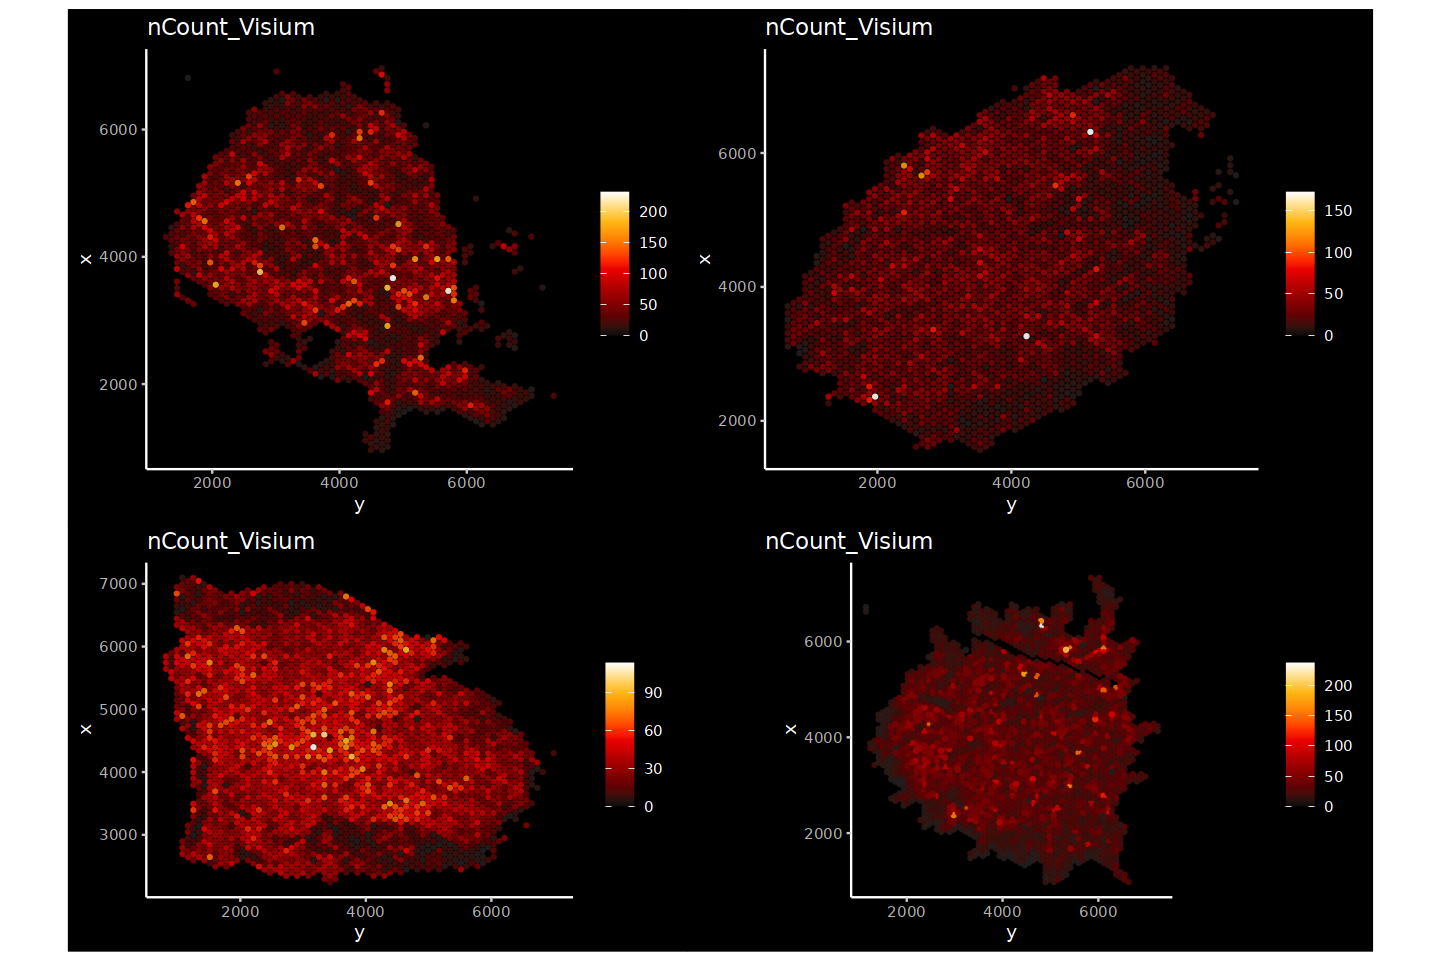

In [19]:
# quick plot of *nCount_
i <- 1 # FOV to use
Images(obj.vis)[i]
#markers <- grep("nCount|nFeature", getMeta(obj.vis) %>% names, value = TRUE)
markers <- grep("nCount", getMeta(obj.vis) %>% names, 
                value = TRUE)
sp_pl1 <- 
ImageFeaturePlot(obj.vis,
                 fov = Images(obj.vis), # using cropped FOV for plotting.
                 features = markers,
                 #cols = scale.col_sp,
                 #molecules = "LAMA2",
                 #mols.cols = "cyan1",
                 #mols.size = 0.5,
                 #nmols = 1000,
                 size = 1.5,
                 border.size = NA,
                 #border.color = alpha("blue1", 0.3),
                 #boundaries = "boxes",
                 alpha = 0.9,
                 axes = TRUE,
                 combine = FALSE) 

#scale.col_sp <- c("deeppink", "navyblue", "cyan", 
               #"yellow", "orangered", "gray14") %>% rev
scale.col_sp <- c(alpha("gray12", 0.4), 
                  cet_pal(16, name = "fire")[2:16])

# plot them
options(repr.plot.height = 8, repr.plot.width = 12)
sp_pl1 <-
lapply(sp_pl1 %>% seq, function(i) { 
    sp_pl1[[i]] & theme_classic() %>% dark_mode & 
    #coord_flip() &
    scale_fill_gradientn(name = NULL, # remove legend name
                         colours = scale.col_sp) & 
    # set custom aspect.ratio
    theme(#aspect.ratio = asp.ratio[[i]], 
          plot.background = element_rect(fill = "black", color = "black"))}
      )
sp_pl1 %>% wrap_plots()


In [20]:
# save subsetted obj, 4 samples, & matched VZ and Resolve gene
dir_path <- "./segmentation_free/objects/"
saveRDS(obj.vis, file = paste0(dir_path, "mb_299.295.266.263_matched_visium.rds"))


#### <span style="font-size:12pt; color:gold"> Generate  - ***Resolve*** - Seurat obj(s) of spatially binned moleculre coordinates </span>
<span style="font-size:10pt; color:tomato">..custom bin size `48.74 x 48.74 µm`, matching same size square given circle (spot) diameter </span> <br />

In [4]:
# NOTE, Resolve data are in px space.. to convert to micron space: make $x * 0.138, $y * 0.138 for each coord.

In [ ]:
# Load data - make obj
# get functions
source("./scripts/spatial_binning.R")

# set dir path
path2mols.re <- list.files("./2022_ResolveData/MBEN_Results/objects/", 
                           full.names = TRUE) %>% grep(".rds", ., value = TRUE, invert = TRUE)
path2mols.re

sample.name <- 
    lapply(path2mols.re %>% seq, function(i) {
        stringr::str_split(path2mols.re[i], "/") %>% unlist %>% tail(1) %>%
        stringi::stri_replace_all_regex(., pattern = "run[0-9]_|-filtered_transcripts.txt", "") %>% 
        tolower() %>%
        stringr::str_split(., "_") %>% 
        unlist %>% sort %>% 
        tail(., n = 2) %>%
        glue::glue_collapse(sep = ".") %>%
        paste0(".Resolve")
    }) %>% unlist
sample.name
           
pbapply::pboptions(type = "timer", style = 1, char = "=")
start.time <- Sys.time()
obj.list.re <- 
  pbapply::pblapply(path2mols.re %>% seq, function(i) {
      gc() %>% invisible
      BinMols.Seurat(file.path = path2mols.re[i],
                      bin.size = 48.74,
                      coord.space = "pixel",
                      to.microns.Resolve = TRUE, #..will convert coords to microns
                      spatial.technology = "Resolve",
                      MulticoreParam.cores = 15,
                      fov = sample.name[i],
                      assay = "Resolve",
                      use.furrr = FALSE,
                      update.object = TRUE)
    })
end.time <- Sys.time()
end.time - start.time
obj.list.re

In [126]:
# update metadata                
obj.names <- 
lapply(obj.list.re %>% seq, function(i) {
    obj.list.re[[i]] %>% Images()}
      )
#obj.names
names(obj.list.re) <- obj.names

# add sample names to $orig.ident
if (grep("w4", obj.list.re %>% names) %>% any) {
    for (i in grep("w4", obj.list.re %>% names)) {
        obj.list.re[[i]]$orig.ident <- obj.names[i]
}} 
if (grep("w6", obj.list.re %>% names) %>% any) {
    for (i in grep("w6", obj.list.re %>% names)) {
        obj.list.re[[i]]$orig.ident <- obj.names[i]
}} 
if (grep("w5", obj.list.re %>% names) %>% any) {
    for (i in grep("w5", obj.list.re %>% names)) {
    obj.list.re[[i]]$orig.ident <- obj.names[i]
}} 
if (grep("w7", obj.list.re %>% names) %>% any) {
    for (i in grep("w7", obj.list.re %>% names)) {
    obj.list.re[[i]]$orig.ident <- obj.names[i]
}}
# check
lapply(obj.list.re %>% seq, function(i) obj.list.re[[i]]$orig.ident %>% table)

       

[[1]]
.
mb263.w4a1.Resolve 
              1555 

[[2]]
.
mb266.w5a1.Resolve 
              1700 

[[3]]
.
mb295.w6a1.Resolve 
               967 

[[4]]
.
mb295.w6a2.Resolve 
               925 

[[5]]
.
mb299.w7a1.Resolve 
              1075 


In [130]:
end.time - start.time
obj.list.re

Time difference of 11.1725 mins

$mb263.w4a1.Resolve
An object of class Seurat 
125 features across 1555 samples within 1 assay 
Active assay: Resolve (125 features, 0 variable features)
 1 spatial field of view present: mb263.w4a1.Resolve

$mb266.w5a1.Resolve
An object of class Seurat 
124 features across 1700 samples within 1 assay 
Active assay: Resolve (124 features, 0 variable features)
 1 spatial field of view present: mb266.w5a1.Resolve

$mb295.w6a1.Resolve
An object of class Seurat 
123 features across 967 samples within 1 assay 
Active assay: Resolve (123 features, 0 variable features)
 1 spatial field of view present: mb295.w6a1.Resolve

$mb295.w6a2.Resolve
An object of class Seurat 
124 features across 925 samples within 1 assay 
Active assay: Resolve (124 features, 0 variable features)
 1 spatial field of view present: mb295.w6a2.Resolve

$mb299.w7a1.Resolve
An object of class Seurat 
122 features across 1075 samples within 1 assay 
Active assay: Resolve (122 features, 0 variable features)
 1 spatial field

In [131]:
# merge 
obj.re <- merge(obj.list.re[[1]], obj.list.re[-1])
obj.re
obj.re %>% getMeta() %>% str

Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


An object of class Seurat 
127 features across 6222 samples within 1 assay 
Active assay: Resolve (127 features, 0 variable features)
 5 spatial fields of view present: mb263.w4a1.Resolve mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb299.w7a1.Resolve

'data.frame':	6222 obs. of  5 variables:
 $ orig.ident      : chr  "mb263.w4a1.Resolve" "mb263.w4a1.Resolve" "mb263.w4a1.Resolve" "mb263.w4a1.Resolve" ...
 $ nCount_Resolve  : num  142 358 637 874 1702 ...
 $ nFeature_Resolve: int  29 49 46 50 45 49 45 46 55 60 ...
 $ spatial_bin     : int  1 2 3 4 5 6 7 8 9 10 ...
 $ bin.size        : num  48.7 48.7 48.7 48.7 48.7 ...


[1] "mb263.w4a1.Resolve"

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


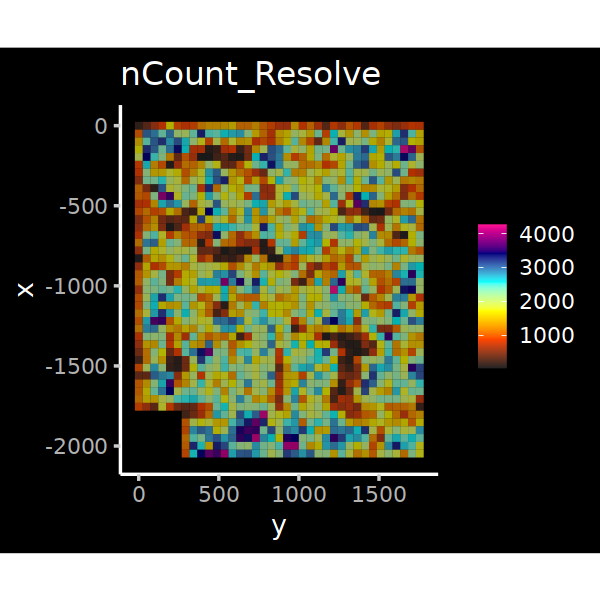

In [143]:
# quick plot check
# TODO:
## using "segmentation-free" spatial Seurat obj
# plot transcripts counts - nCount, add Spatial bins on top ----
if (!exists("scale.col_sp")) { 
    scale.col_sp <- c(alpha("gray12", 0.4), cet_pal(16, name = "fire")[2:16])
}
cols_bins <-
    c("deeppink", "navyblue", "cyan", 
      "yellow", "orangered", "gray14") %>% rev
i <- 1 # FOV to use
Images(obj.re)[i]
markers <- grep("nCount", getMeta(obj.re) %>% names, value = TRUE)
sp_pl1 <- 
ImageFeaturePlot(obj.re,  
                 fov = Images(obj.re)[i], # using cropped FOV for plotting.
                 features = markers,
                 #cols = scale.col_sp,
                 #molecules = "LAMA2",
                 #mols.cols = "cyan1",
                 #mols.size = 0.5,
                 #nmols = 1000,
                 size = 1,
                 border.size = NA,
                 border.color = alpha("gray4", 0.3),
                 boundaries = "boxes",
                 alpha = 0.7,
                 axes = TRUE,
                 combine = FALSE) 

# arrange data in an increasing order
for (i in markers %>% seq) {
    #sp_pl1[[i]]$data <- 
    #sp_pl1[[i]]$data[order(sp_pl1[[i]]$data[[markers[i]]]),]
    # sort using dpyr
    sp_pl1[[i]]$data %<>% 
        arrange(!!as.symbol(markers[i]))
}

# plot it
options(repr.plot.height = 5, repr.plot.width = 5)
sp_pl1 <- 
lapply(sp_pl1 %>% seq, function(i) { 
    sp_pl1[[i]] & theme_classic(base_size = 16) %>% dark_mode & 
    #coord_flip() &
    scale_fill_gradientn(name = NULL, # remove legend name
                         colours = cols_bins) &
    theme( 
          plot.background = element_rect(fill = "black", color = "black"))}
      )
sp_pl1[[1]]


[[1]]


[[1]]


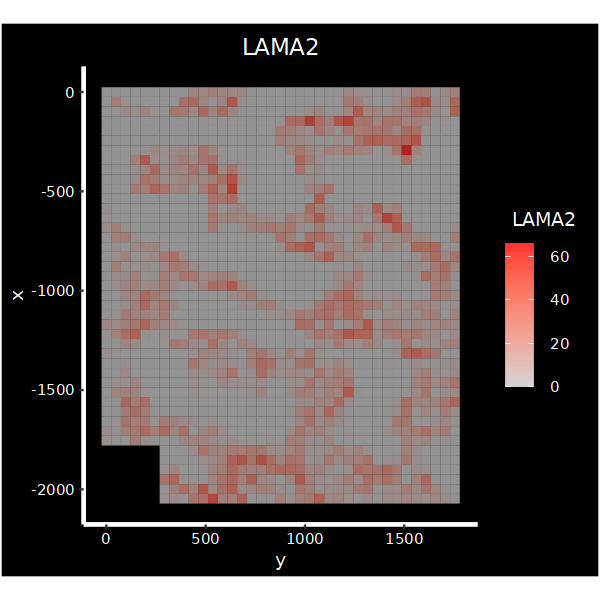

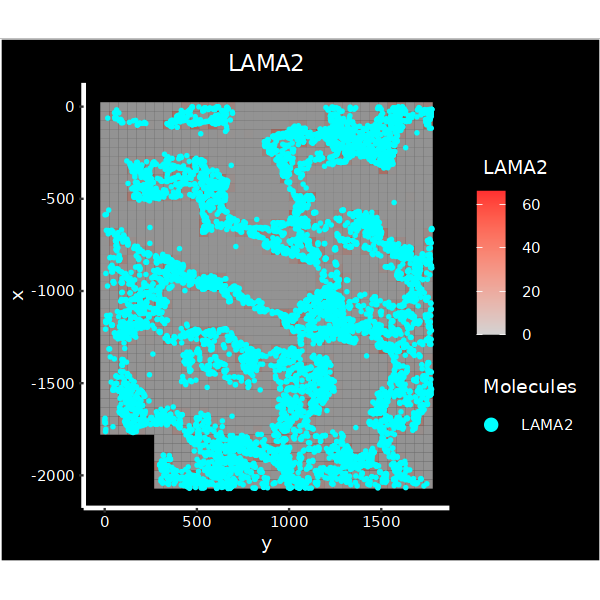

In [139]:
i <- 1
sp_pl1 <-
ImageFeaturePlot(obj.re,  
                 fov = Images(obj.re)[i], # using cropped FOV for plotting.
                 features = "LAMA2",
                 #cols = scale.col_sp,
                 #molecules = "LAMA2",
                 #mols.cols = "cyan1",
                 #mols.size = 0.5,
                 #nmols = 10000,
                 size = 1,
                 border.size = NA,
                 border.color = alpha("gray4", 0.3),
                 boundaries = "boxes",
                 alpha = 0.7,
                 axes = TRUE,
                 combine = FALSE) 
# arrange data in an increasing order
for (i in markers %>% seq) {
    #sp_pl1[[i]]$data <- 
    #sp_pl1[[i]]$data[order(sp_pl1[[i]]$data[[markers[i]]]),]
    # sort using dpyr
    sp_pl1[[i]]$data %<>% 
        arrange(!!as.symbol("LAMA2"))
    }
sp_pl1
sp_pl1 <-
ImageFeaturePlot(obj.re,  
                 fov = Images(obj.re)[i], # using cropped FOV for plotting.
                 features = "LAMA2",
                 #cols = scale.col_sp,
                 molecules = "LAMA2",
                 mols.cols = "cyan1",
                 mols.size = 0.5,
                 nmols = 10000,
                 size = 1,
                 border.size = NA,
                 border.color = alpha("gray4", 0.3),
                 boundaries = "boxes",
                 alpha = 0.7,
                 axes = TRUE,
                 combine = FALSE) 
# arrange data in an increasing order
for (i in markers %>% seq) {
    #sp_pl1[[i]]$data <- 
    #sp_pl1[[i]]$data[order(sp_pl1[[i]]$data[[markers[i]]]),]
    # sort using dpyr
    sp_pl1[[i]]$data %<>% 
        arrange(!!as.symbol("LAMA2")) #%>%
    # flip x axis for visualization
    #mutate(x = -x)
}
sp_pl1

#### <span style="font-size:12pt; color:gold"> Generate - ***Vizgen*** - Seurat obj(s) of spatially binned moleculre coordinates </span>
<span style="font-size:10pt; color:tomato">..custom bin size `48.74 x 48.74 µm`, matching same size square given circle (spot) diameter </span> <br />

In [ ]:
# Load data - make obj
# set dir path for read mols coords
# get functions
source("./scripts/spatial_binning.R")

dir_vz <- "./vizgen_data/analyzed_data"
path2mols <- 
    list.files(dir_vz, pattern = "-MB1", full.names = TRUE) %>% # only run 2
    list.files(pattern = "region_[0-1]", full.names = TRUE) %>% # MB295, MB266
    list.files(pattern = "detected_transcripts", full.names = TRUE, recursive = TRUE)
path2mols

sample.name <- c("mb295", "mb266")
sample.name
           
pbapply::pboptions(type = "timer", style = 1, char = "=")
start.time <- Sys.time()
obj.list.vz <- 
  pbapply::pblapply(path2mols %>% seq, function(i) {
      gc() %>% invisible()
      BinMols.Seurat(file.path = path2mols[i],
                      bin.size = 48.74,
                      coord.space = "micron",
                      spatial.technology = "Vizgen",
                      MulticoreParam.cores = 15,
                      fov = sample.name[i],
                      assay = "Vizgen",
                      use.furrr = FALSE,
                      update.object = TRUE)
    })
end.time <- Sys.time()
end.time - start.time
obj.list.vz

In [170]:
# update metadata
obj.names <- 
lapply(obj.list.vz %>% seq, function(i) {
    obj.list.vz[[i]] %>% Images()}
      )
#obj.names
names(obj.list.vz) <- obj.names

# add sample names to $orig.ident
if (grep("295", obj.list.vz %>% names) %>% any) {
    for (i in grep("295", obj.list.vz %>% names)) {
        obj.list.vz[[i]]$orig.ident <- obj.names[i]
}}
if (grep("266", obj.list.vz %>% names) %>% any) {
    for (i in grep("266", obj.list.vz %>% names)) {
        obj.list.vz[[i]]$orig.ident <- obj.names[i]
}}
# check
lapply(obj.list.vz %>% seq, function(i) obj.list.vz[[i]]$orig.ident %>% table)


[[1]]
.
mb295 
 5235 

[[2]]
.
mb266 
 5262 


In [178]:
# merge 
obj.vz <- merge(obj.list.vz[[1]], obj.list.vz[-1])
# rename FOVS
names(obj.vz@images) %<>% paste0(., ".Vizgen")
obj.vz
obj.vz %>% getMeta() %>% str

Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


An object of class Seurat 
180 features across 10497 samples within 1 assay 
Active assay: Vizgen (180 features, 0 variable features)
 2 spatial fields of view present: mb295mb295.Vizgen mb266mb266.Vizgen

'data.frame':	10497 obs. of  5 variables:
 $ orig.ident     : chr  "mb295" "mb295" "mb295" "mb295" ...
 $ nCount_Vizgen  : num  1 772 1025 1294 931 ...
 $ nFeature_Vizgen: int  1 102 127 121 107 122 89 102 69 29 ...
 $ spatial_bin    : int  50 51 52 53 54 55 56 57 58 59 ...
 $ bin.size       : num  48.7 48.7 48.7 48.7 48.7 ...


#### <span style="font-size:12pt; color:gold"> Prefiltering, Updating metadata, Merging.. </span>
<span style="font-size:10pt; color:tomato">Vizgen & Resolve objects, also merging with MBEN 10X Visium </span> <br />

In [24]:
# Prefiltering ----
gc() %>% invisible()
# Sanity check
if (any(obj.re$nCount_Resolve == 0)) {
    message("Removing cell with 0 transcript counts")
    obj.re %<>% subset(subset = nCount_Resolve > 0)
} else { message("All transcript counts > 0") }

if (any(obj.vz$nCount_Vizgen == 0)) {
    message("Removing cell with 0 transcript counts")
    obj.vz %<>% subset(subset = nCount_Vizgen > 0)
} else { message("All transcript counts > 0") }


All transcript counts > 0

All transcript counts > 0



In [ ]:
# temp save obj
dir_path <- "./segmentation_free/objects/"
saveRDS(obj.re, file = paste0(dir_path, "re_temp.rds"))
saveRDS(obj.vz, file = paste0(dir_path, "vz_temp.rds"))


<span style="font-size:12pt; color:gold"> Get genes per technology </span> <br />
<span style="font-size:10pt; color:steelblue"> ..all genes are kept </span> <br />

In [23]:
# all unique genes in Resolve and Vizgen (not matched)
g.full <- c(rownames(obj.vz), rownames(obj.re)) %>% unique
g.full %>% str

 chr [1:210] "AIF1" "APOD" "AQP4" "ASTN1" "ATOH1" "BMPR1B" "BOC" "BRAF" ...


<span style="font-size:10pt; color:steelblue"> ..matched target and background genes are kept </span> <br />

In [25]:
# matched target genes + tech-specific background genes
g.matched.bg <- 
    # same genes between techs
    intersect(rownames(obj.vz), rownames(obj.re)) %>% 
    # keep tech-specific bg genes
    c(., grep("Blank-|FP ", lapply(seq(2), 
                              function(i) 
                                  rownames(list(obj.re, obj.vz)[[i]])) %>% 
                              unlist %>% unique, value = TRUE))
g.matched.bg %>% str

 chr [1:164] "AIF1" "AQP4" "ASTN1" "BMPR1B" "BOC" "CA10" "CD14" "CD37" ...


<span style="font-size:10pt; color:steelblue"> ..matched target genes only are kept </span> <br />

In [26]:
# matched target genes
g.matched <- 
    # same genes between techs
    intersect(rownames(obj.vz), rownames(obj.re))
g.matched %>% str

 chr [1:97] "AIF1" "AQP4" "ASTN1" "BMPR1B" "BOC" "CA10" "CD14" "CD37" "CD4" ...


<span style="font-size:12pt; color:gold"> Update metadata *before* merging.. </span> <br />

In [27]:
## add to Resolve ----
obj.re@meta.data %<>%
    mutate(spatial_tech = paste0("Resolve"),
           samples = orig.ident)

## add to Vizgen ----
obj.vz@meta.data %<>%
    mutate(orig.ident = paste0(orig.ident, ".Vizgen"), 
           spatial_tech = paste0("Vizgen"),
           samples = orig.ident)

#meta.vars.names <- c("samples", "spatial_tech")
#meta.vars <- c("Vizgen")
#meta.vars <- lapply(meta.vars %>% seq, function(i) 
#{ rep_len(meta.vars[i], length.out = Cells(obj.vz) %>% length) })
#meta.vars %>% str
#for (i in meta.vars.names %>% seq) {
#    obj.vz %<>% AddMetaData(metadata = meta.vars[[i]],
#                            col.name = meta.vars.names[i])
#        }

obj.re %>% getMeta %>% str
obj.vz %>% getMeta %>% str

'data.frame':	6222 obs. of  7 variables:
 $ orig.ident      : chr  "mb263.w4a1.Resolve" "mb263.w4a1.Resolve" "mb263.w4a1.Resolve" "mb263.w4a1.Resolve" ...
 $ nCount_Resolve  : num  142 358 637 874 1702 ...
 $ nFeature_Resolve: int  29 49 46 50 45 49 45 46 55 60 ...
 $ spatial_bin     : int  1 2 3 4 5 6 7 8 9 10 ...
 $ bin.size        : num  48.7 48.7 48.7 48.7 48.7 ...
 $ spatial_tech    : chr  "Resolve" "Resolve" "Resolve" "Resolve" ...
 $ samples         : chr  "mb263.w4a1.Resolve" "mb263.w4a1.Resolve" "mb263.w4a1.Resolve" "mb263.w4a1.Resolve" ...
'data.frame':	10497 obs. of  7 variables:
 $ orig.ident     : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ nCount_Vizgen  : num  1 772 1025 1294 931 ...
 $ nFeature_Vizgen: int  1 102 127 121 107 122 89 102 69 29 ...
 $ spatial_bin    : int  50 51 52 53 54 55 56 57 58 59 ...
 $ bin.size       : num  48.7 48.7 48.7 48.7 48.7 ...
 $ spatial_tech   : chr  "Vizgen" "Vizgen" "Vizgen" "Vizgen" ...
 $ samples        : ch

<span style="font-size:12pt; color:gold"> Merge objects..</span> <br />
<span style="font-size:11pt; color:tomato"> ..make sure objects have the **same** assay names! </span> <br />

In [28]:
gc() %>% invisible
obj.merged <- merge(x = { if (!any(Assays(obj.vz) == "Spatial")) {
                                RenameAssays(obj.vz, Vizgen = "Spatial")
                        } else { obj.vz }},
                    y = { if (!any(Assays(obj.re) == "Spatial")) {
                                RenameAssays(obj.re, Resolve = "Spatial")
                        } else { obj.re }},
                    add.cell.ids = c("Vz", "Re"))
obj.merged

Renaming default assay from Vizgen to Spatial

Warning message:
“Cannot add objects with duplicate keys (offending key: vizgen_) setting key to original value 'spatial_'”
Renaming default assay from Resolve to Spatial

Warning message:
“Cannot add objects with duplicate keys (offending key: resolve_) setting key to original value 'spatial_'”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”


An object of class Seurat 
210 features across 16719 samples within 1 assay 
Active assay: Spatial (210 features, 0 variable features)
 7 spatial fields of view present: mb295.Vizgen mb266.Vizgen mb263.w4a1.Resolve mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb299.w7a1.Resolve

<span style="font-size:12pt; color:gold"> Update metadata *after* merging.. </span> <br />

In [29]:
# add 
obj.merged@meta.data %<>%
    mutate(spatial_bin = Cells(obj.merged),
           donors = samples) %>%
    select(!contains(c("nCount", "nFeature")))
obj.merged %>% getMeta() %>% str

'data.frame':	16719 obs. of  6 variables:
 $ orig.ident  : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ spatial_bin : chr  "Vz_spatial_bin_50_1" "Vz_spatial_bin_51_1" "Vz_spatial_bin_52_1" "Vz_spatial_bin_53_1" ...
 $ bin.size    : num  48.7 48.7 48.7 48.7 48.7 ...
 $ spatial_tech: chr  "Vizgen" "Vizgen" "Vizgen" "Vizgen" ...
 $ samples     : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ donors      : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...


<span style="font-size:12pt; color:gold"> Creating new pre-filtered object (ie, only with `nCount > 0`) & add FOVs </span> <br />

In [42]:
# Create new raw object
if (!exists("assay.name") | !assay.name == "VizRes" ) 
    { assay.name <- "VizRes" }
gc() %>% invisible
obj <- 
    GetAssayData(obj.merged) %>%
    CreateSeuratObject(.,
                       # keep genes expressed at least in 1 cell
                       #min.cells = 1,                  
                       assay = assay.name, 
                       meta.data = obj.merged %>% getMeta())
obj

# TODO (optionally)
# try add FOVs using lapply
#pbapply::pboptions(type = "timer", style = 1, char = "=")
#pbapply::pblapply()
    
start.time <- Sys.time() 
# in a loop
for (i in Images(obj.merged) %>% seq) {
    obj[[Images(obj.merged)[i]]] <- obj.merged[[Images(obj.merged)[i]]]
}
end.time <- Sys.time()
end.time - start.time

obj %<>% UpdateSeuratObject()
obj
obj %>% getMeta %>% str

An object of class Seurat 
210 features across 16719 samples within 1 assay 
Active assay: VizRes (210 features, 0 variable features)

Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Cannot add objects with duplicate keys (offending key: Vizgen_), setting key to 'mb266.vizgen_'”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from mb266.vizgen_ to mb266vizgen_”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Cannot add objects with duplicate keys (offending key: Resolve_), setting key to 'mb266.w5a1.resolve_'”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from mb266.w5a1.resolve_ to mb266w5a1resolve_”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Cannot add objects with duplicate ke

Time difference of 0.843144 secs

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version



An object of class Seurat 
210 features across 16719 samples within 1 assay 
Active assay: VizRes (210 features, 0 variable features)
 7 spatial fields of view present: mb295.Vizgen mb266.Vizgen mb263.w4a1.Resolve mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb299.w7a1.Resolve

'data.frame':	16719 obs. of  8 variables:
 $ orig.ident     : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ nCount_VizRes  : num  1 772 1025 1294 931 ...
 $ nFeature_VizRes: int  1 102 127 121 107 122 89 102 69 29 ...
 $ spatial_bin    : chr  "Vz_spatial_bin_50_1" "Vz_spatial_bin_51_1" "Vz_spatial_bin_52_1" "Vz_spatial_bin_53_1" ...
 $ bin.size       : num  48.7 48.7 48.7 48.7 48.7 ...
 $ spatial_tech   : chr  "Vizgen" "Vizgen" "Vizgen" "Vizgen" ...
 $ samples        : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ donors         : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...


<span style="font-size:12pt; color:gold"> Sanity check on genes and cells </span> <br />
<span style="font-size:11pt; color:steelblue"> ..subset usning modified `subset` function
</span> <br />

In [43]:
# load modified subset function
source("./scripts/subset_obj_seurat_v2.R")

In [44]:
# Sanity
# check for genes
gene.index <- c((GetAssayData(obj) %>% rowSums) == 0)
if (gene.index %>% any) {
    n.genes <- which(gene.index)
    message("Total of ", n.genes %>% length, 
            " have 0 expression in all cells", "\n",
            ">>> removing these genes..")
    obj %<>% subset_opt(features = rownames(obj)[-n.genes])
    } else { message("Sanity passed:", "\n",
                     ">>> A single gene is expressed in least 1 cell", "\n", 
                     ">>> No genes have 0 expression in all cells") }

# check for cells
cell.index <- c((GetAssayData(obj) %>% colSums) == 0)
if (cell.index %>% any) {
    message("Removing cell with 0 transcript counts")
    obj %<>% subset_opt(cells = -which(cell.index))
} else { message("Sanity passed:", "\n", 
                 ">>> All transcript counts > 0") }

Sanity passed:
>>> A single gene is expressed in least 1 cell
>>> No genes have 0 expression in all cells

Sanity passed:
>>> All transcript counts > 0



<span style="font-size:12pt; color:gold"> Subset obj(s) for each configuration of genes </span> <br />
<span style="font-size:11pt; color:steelblue"> .. using modified `subset` function
</span> <br />

In [45]:
# pre-filtered merged obj - all genes
# the full obj from above
# obj

In [46]:
# eg subset for 100 genes and 4 molecules
# NOTE, FOVs will be subsetted as well
if (FALSE) { # set to TRUE to run the test
    test <- 
    subset_opt(obj, 
               cells = Cells(obj)[1:100],
               features = rownames(obj)[1:4])
}


In [47]:
# pre-filtered merged obj - matched target genes + tech-specific background genes
obj.vzre.bg <-
# subset it..
    obj %>% subset_opt(features = g.matched.bg)
obj.vzre.bg

Updating object slots..

Cloing object..

Matching cells in FOVs..

Cell subsets are found in all FOVs!
Subsetting object..

Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Subsetting FOVs..

Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data 

An object of class Seurat 
164 features across 16719 samples within 1 assay 
Active assay: VizRes (164 features, 0 variable features)
 7 spatial fields of view present: mb295.Vizgen mb266.Vizgen mb263.w4a1.Resolve mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb299.w7a1.Resolve

In [48]:
# Sanity
# check for genes
gene.index <- c((GetAssayData(obj.vzre.bg) %>% rowSums) == 0)
if (gene.index %>% any) {
    n.genes <- which(gene.index)
    message("Total of ", n.genes %>% length, 
            " have 0 expression in all cells", "\n",
            ">>> removing these genes..")
    obj.vzre.bg %<>% 
        subset_opt(features = rownames(obj.vzre.bg)[-n.genes])
    } else { message("Sanity passed:", "\n",
                     ">>> A single gene is expressed in least 1 cell", "\n", 
                     ">>> No genes have 0 expression in all cells") }

# check for cells
cell.index <- c((GetAssayData(obj.vzre.bg) %>% colSums) == 0)
if (cell.index %>% any) {
    message("Removing cells with 0 transcript counts")
    obj.vzre.bg %<>% subset_opt(cells = -which(cell.index))
} else { message("Sanity passed:", "\n", 
                 ">>> All transcript counts > 0") }
obj.vzre.bg

Sanity passed:
>>> A single gene is expressed in least 1 cell
>>> No genes have 0 expression in all cells

Removing cells with 0 transcript counts

Updating object slots..

Cloing object..

Matching cells in FOVs..

Cell subsets are found in all FOVs!
Subsetting object..

Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Subsetting FOVs..

Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't assoc

An object of class Seurat 
164 features across 16614 samples within 1 assay 
Active assay: VizRes (164 features, 0 variable features)
 7 spatial fields of view present: mb295.Vizgen mb266.Vizgen mb263.w4a1.Resolve mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb299.w7a1.Resolve

In [49]:
# check for FOVs
lapply(Images(obj.vzre.bg) %>% seq, 
       function(i) obj.vzre.bg[[Images(obj.vzre.bg)[i]]])

[[1]]
Spatial coordinates for 5195 cells and 137 molecules
 First 10 molecules: AIF1, AQP4, ASTN1, BMPR1B, BOC, CA10
Default segmentation boundary: centroids 
 1 other segmentation boundaries present: boxes 
Associated assay: Vizgen 
Key: Vizgen_ 

[[2]]
Spatial coordinates for 5197 cells and 137 molecules
 First 10 molecules: AIF1, AQP4, ASTN1, BMPR1B, BOC, CA10
Default segmentation boundary: centroids 
 1 other segmentation boundaries present: boxes 
Associated assay: Vizgen 
Key: mb266vizgen_ 

[[3]]
Spatial coordinates for 1555 cells and 123 molecules
 First 10 molecules: AIF1, AQP4, ASTN1, BMPR1B, BOC, CA10
Default segmentation boundary: centroids 
 1 other segmentation boundaries present: boxes 
Associated assay: Resolve 
Key: Resolve_ 

[[4]]
Spatial coordinates for 1700 cells and 122 molecules
 First 10 molecules: AIF1, AQP4, ASTN1, BMPR1B, BOC, CA10
Default segmentation boundary: centroids 
 1 other segmentation boundaries present: boxes 
Associated assay: Resolve 
Key: mb266w

In [50]:
# pre-filtered merged obj - matched target genes only
obj.vzre <-
# subset it..
    obj %>% subset_opt(features = g.matched)

Updating object slots..

Cloing object..

Matching cells in FOVs..

Cell subsets are found in all FOVs!
Subsetting object..

Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Subsetting FOVs..

Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data 

In [51]:
# Sanity
# check for genes
gene.index <- c((GetAssayData(obj.vzre) %>% rowSums) == 0)
if (gene.index %>% any) {
    n.genes <- which(gene.index)
    message("Total of ", n.genes %>% length, 
            " have 0 expression in all cells", "\n",
            ">>> removing these genes..")
    obj.vzre %<>% 
        subset_opt(features = rownames(obj.vzre)[-n.genes])
    } else { message("Sanity passed:", "\n",
                     ">>> A single gene is expressed in least 1 cell", "\n", 
                     ">>> No genes have 0 expression in all cells") }

# check for cells
cell.index <- c((GetAssayData(obj.vzre) %>% colSums) == 0)
if (cell.index %>% any) {
    message("Removing cell with 0 transcript counts")
    obj.vzre %<>% subset_opt(cells = -which(cell.index))
} else { message("Sanity passed:", "\n", 
                 ">>> All transcript counts > 0") }
obj.vzre

Sanity passed:
>>> A single gene is expressed in least 1 cell
>>> No genes have 0 expression in all cells

Removing cell with 0 transcript counts

Updating object slots..

Cloing object..

Matching cells in FOVs..

Cell subsets are found in all FOVs!
Subsetting object..

Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Subsetting FOVs..

Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associ

An object of class Seurat 
97 features across 16611 samples within 1 assay 
Active assay: VizRes (97 features, 0 variable features)
 7 spatial fields of view present: mb295.Vizgen mb266.Vizgen mb263.w4a1.Resolve mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb299.w7a1.Resolve

In [52]:
# check for FOVs
lapply(Images(obj.vzre) %>% seq, 
       function(i) obj.vzre[[Images(obj.vzre)[i]]])

[[1]]
Spatial coordinates for 5195 cells and 97 molecules
 First 10 molecules: AIF1, AQP4, ASTN1, BMPR1B, BOC, CA10
Default segmentation boundary: centroids 
 1 other segmentation boundaries present: boxes 
Associated assay: Vizgen 
Key: Vizgen_ 

[[2]]
Spatial coordinates for 5194 cells and 97 molecules
 First 10 molecules: AIF1, AQP4, ASTN1, BMPR1B, BOC, CA10
Default segmentation boundary: centroids 
 1 other segmentation boundaries present: boxes 
Associated assay: Vizgen 
Key: mb266vizgen_ 

[[3]]
Spatial coordinates for 1555 cells and 96 molecules
 First 10 molecules: AIF1, AQP4, ASTN1, BMPR1B, BOC, CA10
Default segmentation boundary: centroids 
 1 other segmentation boundaries present: boxes 
Associated assay: Resolve 
Key: Resolve_ 

[[4]]
Spatial coordinates for 1700 cells and 97 molecules
 First 10 molecules: AIF1, AQP4, ASTN1, BMPR1B, BOC, CA10
Default segmentation boundary: centroids 
 1 other segmentation boundaries present: boxes 
Associated assay: Resolve 
Key: mb266w5a1r

<span style="font-size:11pt; color:gold"> Merge MBEN 10X Visium obj with *matched genes VzRe* object </span> <br />

In [54]:
# load full object 
file.vis <- 
    "./segmentation_free/objects/mb_299.295.266.263_matched_visium.rds"
obj.vis <- readRDS(file.vis)
obj.vis

# match genes ---- 
intersect(rownames(obj.vzre), rownames(obj.vis)) %>% str

# update metadata - Visium ----
meta.df <- 
    obj.vis %>% 
    getMeta() %>%
    mutate(orig.ident = 
           gsub("ICGC_", "", orig.ident) %>% 
           tolower() %>% 
           paste0(".Visium"),
          samples = orig.ident,
          spatial_tech = paste0("Visium"),
          spatial_bin = Cells(obj.vis)) %>%
    select(!contains(c("percent","nCount","nFeature")))
# replace metadata
obj.vis@meta.data <- meta.df

# update - VzRe
obj.vzre@meta.data %<>%
    select(!contains(c("nCount","nFeature")))

# merge objects
obj.vzre.vis <- merge(x = RenameAssays(obj.vzre, VizRes = "VizResVis"),
                    y = RenameAssays(obj.vis, Visium = "VizResVis"))
obj.vzre.vis
obj.vzre.vis %>% getMeta() %>% str


An object of class Seurat 
97 features across 9909 samples within 1 assay 
Active assay: Visium (97 features, 0 variable features)
 4 spatial fields of view present: mb263.Visium mb266.Visium mb295.Visium mb299.Visium

 chr [1:97] "AIF1" "AQP4" "ASTN1" "BMPR1B" "BOC" "CA10" "CD14" "CD37" "CD4" ...


Renaming default assay from VizRes to VizResVis

Warning message:
“Cannot add objects with duplicate keys (offending key: vizres_) setting key to original value 'vizresvis_'”
Renaming default assay from Visium to VizResVis

Warning message:
“Cannot add objects with duplicate keys (offending key: visium_) setting key to original value 'vizresvis_'”


An object of class Seurat 
97 features across 26520 samples within 1 assay 
Active assay: VizResVis (97 features, 0 variable features)
 11 spatial fields of view present: mb295.Vizgen mb266.Vizgen mb263.w4a1.Resolve mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb299.w7a1.Resolve mb263.Visium mb266.Visium mb295.Visium mb299.Visium

'data.frame':	26520 obs. of  9 variables:
 $ orig.ident        : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ spatial_bin       : chr  "Vz_spatial_bin_50_1" "Vz_spatial_bin_51_1" "Vz_spatial_bin_52_1" "Vz_spatial_bin_53_1" ...
 $ bin.size          : num  48.7 48.7 48.7 48.7 48.7 ...
 $ spatial_tech      : chr  "Vizgen" "Vizgen" "Vizgen" "Vizgen" ...
 $ samples           : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ donors            : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ nCount_VizResVis  : num  1 496 742 917 659 ...
 $ nFeature_VizResVis: int  1 60 78 69 68 75 53 64 45 24 ...
 $ cell_id           : chr  NA NA NA NA ...


In [55]:
# Sanity
# check for genes
gene.index <- c((GetAssayData(obj.vzre.vis) %>% rowSums) == 0)
if (gene.index %>% any) {
    n.genes <- which(gene.index)
    message("Total of ", n.genes %>% length, 
            " have 0 expression in all cells", "\n",
            ">>> removing these genes..")
    obj.vzre.vis %<>% 
        subset_opt(features = rownames(obj.vzre.vis)[-n.genes])
    } else { message("Sanity passed:", "\n",
                     ">>> A single gene is expressed in least 1 cell", "\n", 
                     ">>> No genes have 0 expression in all cells") }

# check for cells
cell.index <- c((GetAssayData(obj.vzre.vis) %>% colSums) == 0)
if (cell.index %>% any) {
    message("Removing cell with 0 transcript counts")
    obj.vzre.vis %<>% subset_opt(cells = -which(cell.index))
} else { message("Sanity passed:", "\n", 
                 ">>> All transcript counts > 0") }

Sanity passed:
>>> A single gene is expressed in least 1 cell
>>> No genes have 0 expression in all cells

Removing cell with 0 transcript counts

Updating object slots..

Cloing object..

Matching cells in FOVs..

Cell subsets are found in all FOVs!
Subsetting object..

Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay

In [56]:
# save objects - in a loop
objs <-
    list(obj.vzre.vis,
         obj.vzre,
         obj.vzre.bg,
         obj)
names(objs) <- c("vz.re.vis_matched", "vz.re_matched",
                 "vz.re_matched_bg", "vz.re_full") %>% paste0(., ".rds")
dir_path <- "./segmentation_free/objects/"
if (!dir.exists(dir_path)) { dir.create(dir_path) }
pbapply::pboptions(type = "timer", style = 1, char = "=")
pbapply::pblapply(objs %>% seq, function(i) {
    message("Saving ... object: ", "\n", names(objs)[[i]])
    saveRDS(objs[[i]], file = paste0(dir_path, sep = "/", names(objs)[[i]]))
    }) %>% invisible()
message("Saving - done!")
list.files(dir_path)


  |                                                  | 0 % elapsed=00s   

Saving ... object: 
vz.re.vis_matched.rds



  |=============                                     | 25% elapsed=27s, remaining~01m 20s

Saving ... object: 
vz.re_matched.rds



  |=========================                         | 50% elapsed=53s, remaining~53s

Saving ... object: 
vz.re_matched_bg.rds



  |======================================            | 75% elapsed=01m 19s, remaining~26s

Saving ... object: 
vz.re_full.rds



  |==================================================| 100% elapsed=01m 53s, remaining~00s


Saving - done!



[1] "mb_299.295.266.263_matched_visium.rds"
[2] "re_temp.rds"                          
[3] "vz_temp.rds"                          
[4] "vz.re_full.rds"                       
[5] "vz.re_matched_bg.rds"                 
[6] "vz.re_matched.rds"                    
[7] "vz.re.vis_matched.rds"                
[8] "vz.re.vis.rs_matched.rds"

#### <span style="font-size:12pt; color:gold"> Load merged pre-filtered object(s) (ie, only with `nCount > 0`) </span>
<span style="font-size:10pt; color:tomato">***MB295, 266*** samples (2nd run).. Vizgen </span> <br />
<span style="font-size:10pt; color:tomato">***MB299, 295, 266, 263*** samples..Resolve & 10X Visium </span> <br />

In [6]:
dir_path <- "./segmentation_free/objects"
file2load <- list.files(dir_path, pattern = "vz.re.vis_matched", full.names = TRUE)

message("Loading ", "'", file2load %>% 
        gsub(pattern = paste0(dir_path, "|", "/"), replacement = "", .), "'", " object")
obj <- readRDS(file2load)
obj
obj %>% getMeta %>% str

Loading 'vz.re.vis_matched.rds' object



An object of class Seurat 
97 features across 26499 samples within 1 assay 
Active assay: VizResVis (97 features, 0 variable features)
 11 spatial fields of view present: mb295.Vizgen mb266.Vizgen mb263.w4a1.Resolve mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb299.w7a1.Resolve mb263.Visium mb266.Visium mb295.Visium mb299.Visium

'data.frame':	26499 obs. of  9 variables:
 $ orig.ident        : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ spatial_bin       : chr  "Vz_spatial_bin_50_1" "Vz_spatial_bin_51_1" "Vz_spatial_bin_52_1" "Vz_spatial_bin_53_1" ...
 $ bin.size          : num  48.7 48.7 48.7 48.7 48.7 ...
 $ spatial_tech      : chr  "Vizgen" "Vizgen" "Vizgen" "Vizgen" ...
 $ samples           : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ donors            : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ nCount_VizResVis  : num  1 496 742 917 659 ...
 $ nFeature_VizResVis: int  1 60 78 69 68 75 53 64 45 24 ...
 $ cell_id           : chr  NA NA NA NA ...


In [7]:
message("Updating some metadata variables")
# simplified sample names
simple.custom <- TRUE
if (simple.custom) {
    # support for multiple - same name - samples
    obj$samples %<>%
        stringi::stri_replace_all_regex(., 
                                        pattern = "region[0-1].|w(.)[^:][0-9].", # merges same samples
                                        #pattern = "region[0-1].|w[4,5,7]a1.|_[a-e]",
                                        replacement = "")
    # add donors
    obj$donors <- obj$samples # data comes from the same patient/sample
    }  

obj@meta.data %<>%
mutate_if(is.character,
              ~ stringr::str_replace_all(., c("Resolve" = "MC", "Vizgen" = "MERFISH")))
obj$samples %>% table
obj$orig.ident %>% table
obj$samples %>% table %>% str
obj %>% getMeta %>% str

Updating some metadata variables



.
mb263_d.Visium       mb263.MC mb266_c.Visium       mb266.MC  mb266.MERFISH 
          1974           1555           2777           1700           5194 
mb295_b.Visium       mb295.MC  mb295.MERFISH mb299_a.Visium       mb299.MC 
          2484           1892           5195           2653           1075 

.
mb263_d.Visium  mb263.w4a1.MC mb266_c.Visium  mb266.MERFISH  mb266.w5a1.MC 
          1974           1555           2777           5194           1700 
mb295_b.Visium  mb295.MERFISH  mb295.w6a1.MC  mb295.w6a2.MC mb299_a.Visium 
          2484           5195            967            925           2653 
 mb299.w7a1.MC 
          1075 

 'table' int [1:10(1d)] 1974 1555 2777 1700 5194 2484 1892 5195 2653 1075
 - attr(*, "dimnames")=List of 1
  ..$ .: chr [1:10] "mb263_d.Visium" "mb263.MC" "mb266_c.Visium" "mb266.MC" ...
'data.frame':	26499 obs. of  9 variables:
 $ orig.ident        : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ spatial_bin       : chr  "Vz_spatial_bin_50_1" "Vz_spatial_bin_51_1" "Vz_spatial_bin_52_1" "Vz_spatial_bin_53_1" ...
 $ bin.size          : num  48.7 48.7 48.7 48.7 48.7 ...
 $ spatial_tech      : chr  "MERFISH" "MERFISH" "MERFISH" "MERFISH" ...
 $ samples           : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ donors            : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ nCount_VizResVis  : num  1 496 742 917 659 ...
 $ nFeature_VizResVis: int  1 60 78 69 68 75 53 64 45 24 ...
 $ cell_id           : chr  NA NA NA NA ...


#### <span style="font-size:12pt; color:gold"> Generate - ***Xenium*** - Seurat obj(s) of spatially binned moleculre coordinates </span>
<span style="font-size:10pt; color:tomato">..custom bin size `48.74 x 48.74 µm`, matching same size square given circle (spot) diameter </span> <br />

In [15]:
# load list clean object Xenium data
obj.xen_list <-
    readRDS(file = "./segmentation_based/objects/xen_mben_list_clean.rds")

In [16]:
obj.xen_list

[[1]]
An object of class Seurat 
534 features across 83197 samples within 4 assays 
Active assay: Xenium (345 features, 0 variable features)
 3 other assays present: BlankCodeword, ControlCodeword, ControlProbe
 1 spatial field of view present: mb263.Xenium

[[2]]
An object of class Seurat 
534 features across 125057 samples within 4 assays 
Active assay: Xenium (345 features, 0 variable features)
 3 other assays present: BlankCodeword, ControlCodeword, ControlProbe
 1 spatial field of view present: mb266.Xenium

[[3]]
An object of class Seurat 
534 features across 181946 samples within 4 assays 
Active assay: Xenium (345 features, 0 variable features)
 3 other assays present: BlankCodeword, ControlCodeword, ControlProbe
 1 spatial field of view present: mb295.Xenium

[[4]]
An object of class Seurat 
534 features across 262183 samples within 4 assays 
Active assay: Xenium (345 features, 0 variable features)
 3 other assays present: BlankCodeword, ControlCodeword, ControlProbe
 1 spatia

In [43]:
# extract mols coords df, use it for spatial binning
xen_dfs <- lapply(obj.xen_list, function(i) {
    i[[Images(i)]][["molecules"]] %>% 
        GetTissueCoordinates()
    })
xen_dfs %>% str

List of 4
 $ :'data.frame':	22479886 obs. of  3 variables:
  ..$ x       : num [1:22479886] 172 136 145 137 140 ...
  ..$ y       : num [1:22479886] 1167 1319 1655 1644 1651 ...
  ..$ molecule: chr [1:22479886] "ABCC9" "ABCC9" "ABCC9" "ABCC9" ...
 $ :'data.frame':	40634263 obs. of  3 variables:
  ..$ x       : num [1:40634263] 381 495 421 424 459 ...
  ..$ y       : num [1:40634263] 1885 1943 2488 2488 2457 ...
  ..$ molecule: chr [1:40634263] "ABCC9" "ABCC9" "ABCC9" "ABCC9" ...
 $ :'data.frame':	37499768 obs. of  3 variables:
  ..$ x       : num [1:37499768] 120 120 146 219 229 ...
  ..$ y       : num [1:37499768] 2988 2969 3188 3361 3305 ...
  ..$ molecule: chr [1:37499768] "ABCC9" "ABCC9" "ABCC9" "ABCC9" ...
 $ :'data.frame':	37707205 obs. of  3 variables:
  ..$ x       : num [1:37707205] 218 226 229 173 176 ...
  ..$ y       : num [1:37707205] 902 931 907 1084 1085 ...
  ..$ molecule: chr [1:37707205] "ABCC9" "ABCC9" "ABCC9" "ABCC9" ...


In [44]:
# use only matched target genes + background probes
g.keep <- 
    lapply(seq(xen_dfs), function(i) {
        c(rownames(obj.xen_list[[i]]) %>% intersect(., rownames(obj)),
        grep("NegControlProbe", unique(xen_dfs[[i]]$molecule), value = TRUE))
    })
g.keep %>% str

List of 4
 $ : chr [1:116] "AIF1" "AQP4" "ASTN1" "BMPR1B" ...
 $ : chr [1:116] "AIF1" "AQP4" "ASTN1" "BMPR1B" ...
 $ : chr [1:116] "AIF1" "AQP4" "ASTN1" "BMPR1B" ...
 $ : chr [1:116] "AIF1" "AQP4" "ASTN1" "BMPR1B" ...


In [33]:
# extract mols coords
xen_dfs <-
    lapply(seq(xen_dfs), function(i) 
    xen_dfs[[i]] %>% 
    filter(molecule %in% g.keep[[i]]) 
    )
xen_dfs %>% str

List of 4
 $ :'data.frame':	8090662 obs. of  3 variables:
  ..$ x       : num [1:8090662] 223.4 36.4 39.9 179 33.6 ...
  ..$ y       : num [1:8090662] 1010 1086 1081 1169 1178 ...
  ..$ molecule: chr [1:8090662] "AIF1" "AIF1" "AIF1" "AIF1" ...
 $ :'data.frame':	13097129 obs. of  3 variables:
  ..$ x       : num [1:13097129] 176 129 170 161 199 ...
  ..$ y       : num [1:13097129] 1698 2418 2688 2701 2511 ...
  ..$ molecule: chr [1:13097129] "AIF1" "AIF1" "AIF1" "AIF1" ...
 $ :'data.frame':	15419303 obs. of  3 variables:
  ..$ x       : num [1:15419303] 73.83 7.51 27.13 27.2 131.57 ...
  ..$ y       : num [1:15419303] 2994 3238 3066 3067 3175 ...
  ..$ molecule: chr [1:15419303] "AIF1" "AIF1" "AIF1" "AIF1" ...
 $ :'data.frame':	14176749 obs. of  3 variables:
  ..$ x       : num [1:14176749] 183.7 233.5 213.1 238.3 45.5 ...
  ..$ y       : num [1:14176749] 879 907 905 917 1148 ...
  ..$ molecule: chr [1:14176749] "AIF1" "AIF1" "AIF1" "AIF1" ...


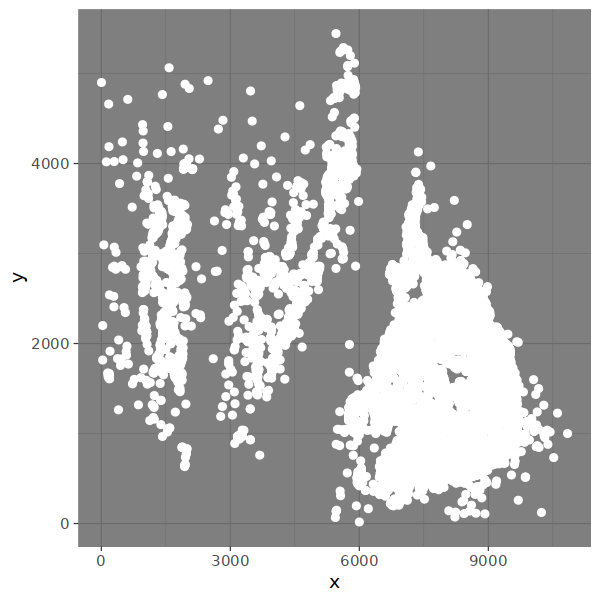

In [46]:
# plot subsampled - LAMA2 
# needs to be cropped before or afterwards
xen_dfs[[1]] %>% filter(molecule == "LAMA2") %>% sample_frac(size = 0.1) %>% 
ggplot(aes(x, y)) & geom_point() & theme_dark()

In [ ]:
# Load data - make obj
# get functions
source("./scripts/spatial_binning.R")
sample.name <- lapply(obj.xen_list, function(i) Images(i)) %>% unlist()
sample.name
           
pbapply::pboptions(type = "timer", style = 1, char = "=")
start.time <- Sys.time()
obj.list.xen <- 
  pbapply::pblapply(xen_dfs %>% seq, function(i) {
      gc() %>% invisible()
      BinMols.Seurat(input.df = xen_dfs[[i]],
                      bin.size = 48.74,
                      coord.space = "micron",
                      spatial.technology = "Xenium",
                      MulticoreParam.cores = 20,
                      fov = sample.name[i],
                      assay = "Xenium",
                      use.furrr = FALSE,
                      update.object = TRUE)
    })
end.time <- Sys.time()
end.time - start.time
obj.list.xen

#### <span style="font-size:12pt; color:gold"> Load - ***Xenium*** - Seurat obj(s) of spatially binned moleculre coordinates </span>
<span style="font-size:10pt; color:tomato">..custom bin size `48.74 x 48.74 µm`, matching same size square given circle (spot) diameter </span> <br />

In [15]:
# load list clean object Xenium data
obj.list.xen <-
    #readRDS(file = "./segmentation_free/objects/xen_mben_binned.rds")
    readRDS(file = "./segmentation_free/objects/xen_mben_binned_cropped.rds")

In [16]:
obj.list.xen

[[1]]
An object of class Seurat 
541 features across 6206 samples within 1 assay 
Active assay: Xenium (541 features, 0 variable features)
 1 spatial field of view present: mb263.Xenium

[[2]]
An object of class Seurat 
541 features across 11888 samples within 1 assay 
Active assay: Xenium (541 features, 0 variable features)
 1 spatial field of view present: mb266.Xenium

[[3]]
An object of class Seurat 
541 features across 11004 samples within 1 assay 
Active assay: Xenium (541 features, 0 variable features)
 1 spatial field of view present: mb295.Xenium

[[4]]
An object of class Seurat 
541 features across 15303 samples within 1 assay 
Active assay: Xenium (541 features, 0 variable features)
 1 spatial field of view present: mb299.Xenium


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


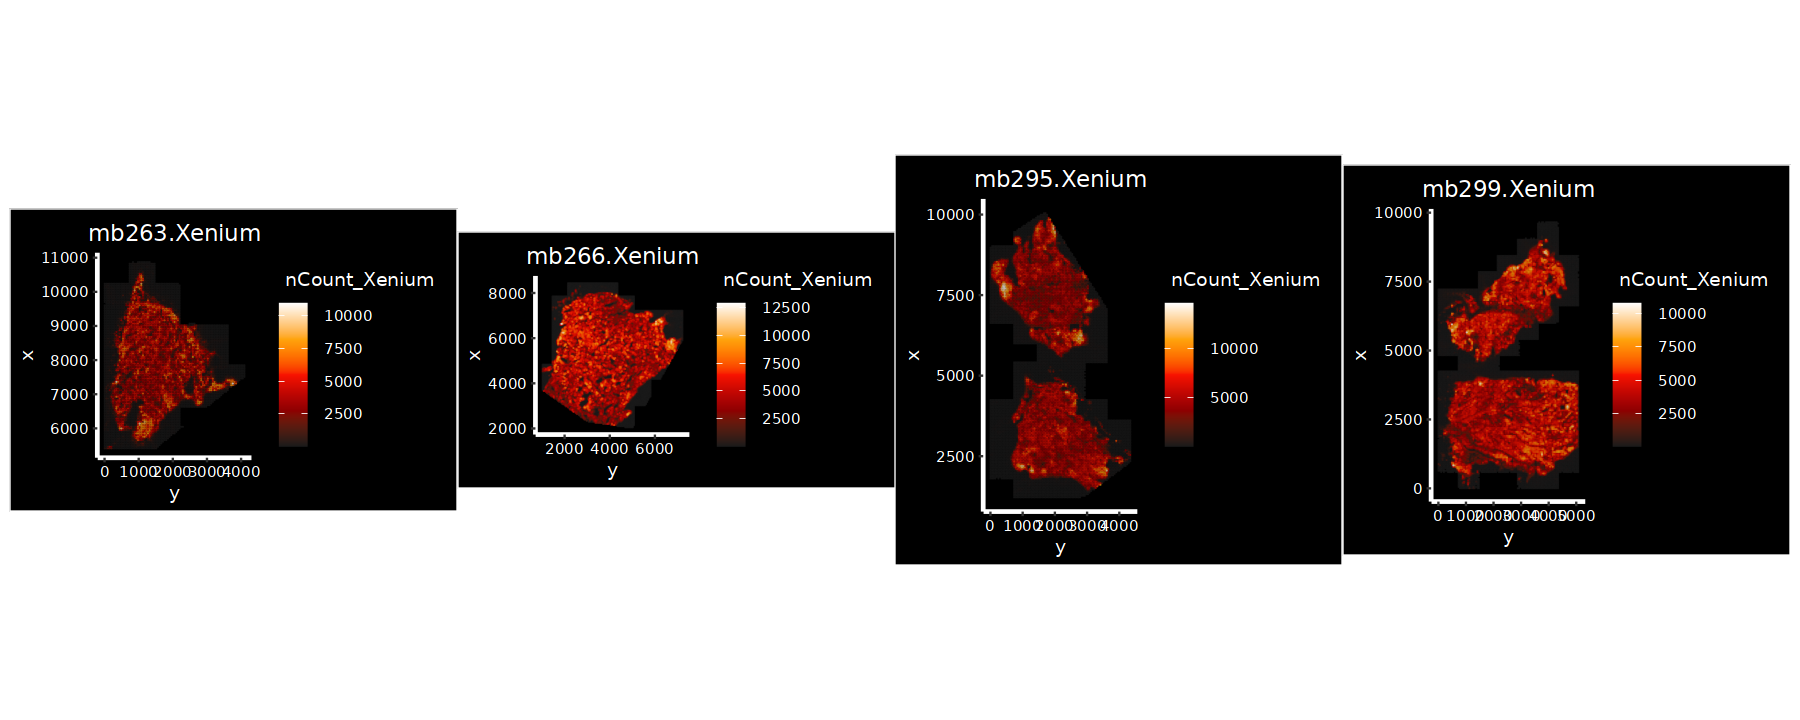

In [17]:
# plot all samples - single gene
pl_all <- 
lapply(seq(obj.list.xen), function(i) {
    ImageFeaturePlot(obj.list.xen[[i]],
                 fov = Images(obj.list.xen[[i]]),
                 features = "nCount_Xenium", #"LAMA2",
                 #molecules = "LAMA2",
                 #mols.cols = "cyan1",
                 #mols.size = 0.5,
                 #nmols = 1000,
                 #min.cutoff = 1.5,        
                 size = 0.3,
                 border.size = NA,
                 #border.color = alpha("blue1", 0.3),
                 boundaries = "centroids",
                 #scale = "none",    
                 alpha = 0.7,
                 axes = TRUE,
                 combine = TRUE) & ggtitle(Images(obj.list.xen[[i]]))
    })
# order plotting var (eg, gene expression) in an increasing order
pl_all <- 
    lapply(pl_all, function(i) {
    i$data %<>% arrange(nCount_Xenium)
    i <- i & scale_fill_gradientn(colours = c("gray10", cet_pal(5, name = "fire")[-1]))   
    return(i)
    })
options(repr.plot.height = 6, repr.plot.width = 15)
patchwork::wrap_plots(pl_all, nrow = 1)

[1] "mb263.Xenium"

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


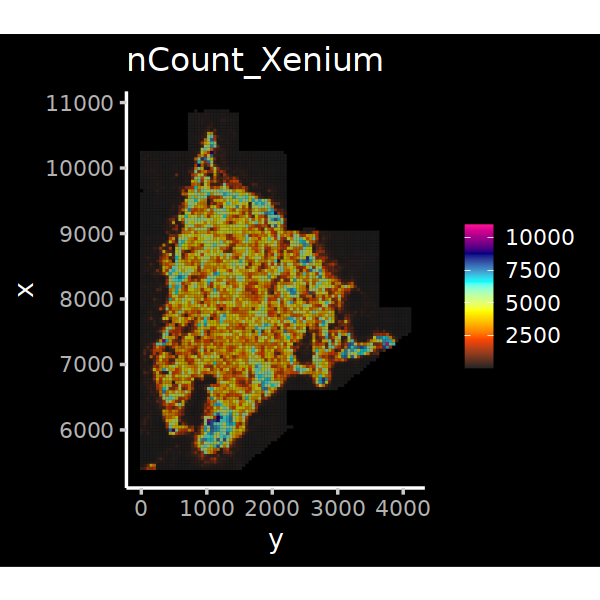

In [19]:
# quick plot check
# TODO:
## using "segmentation-free" spatial Seurat obj
# plot transcripts counts - nCount, add Spatial bins on top ----
if (!exists("scale.col_sp")) { 
    scale.col_sp <- c(alpha("gray12", 0.4), cet_pal(16, name = "fire")[2:16])
}
cols_bins <-
    c("deeppink", "navyblue", "cyan", 
      "yellow", "orangered", "gray14") %>% rev
i <- 1 # FOV to use
j <- 1 # sample/object use
Images(obj.list.xen[[j]])[i]
markers <- grep("nCount", getMeta(obj.list.xen[[j]]) %>% names, value = TRUE)
sp_pl1 <- 
ImageFeaturePlot(obj.list.xen[[j]],  
                 fov = Images(obj.list.xen[[j]])[i], # using cropped FOV for plotting.
                 features = markers,
                 #cols = scale.col_sp,
                 #molecules = "LAMA2",
                 #mols.cols = "cyan1",
                 #mols.size = 0.5,
                 #nmols = 1000,
                 size = 1,
                 border.size = NA,
                 border.color = alpha("gray4", 0.3),
                 boundaries = "boxes",
                 alpha = 0.7,
                 axes = TRUE,
                 combine = FALSE) 

# arrange data in an increasing order
for (i in markers %>% seq) {
    #sp_pl1[[i]]$data <- 
    #sp_pl1[[i]]$data[order(sp_pl1[[i]]$data[[markers[i]]]),]
    # sort using dpyr
    sp_pl1[[i]]$data %<>% 
        arrange(!!as.symbol(markers[i]))
}

# plot it
options(repr.plot.height = 5, repr.plot.width = 5)
sp_pl1 <- 
lapply(sp_pl1 %>% seq, function(i) { 
    sp_pl1[[i]] & theme_classic(base_size = 16) %>% dark_mode & 
    #coord_flip() &
    scale_fill_gradientn(name = NULL, # remove legend name
                         colours = cols_bins) &
    theme( 
          plot.background = element_rect(fill = "black", color = "black"))}
      )
sp_pl1[[1]]


##### <span style="font-size:11pt; color:gold"> Crop FOV parts, keep good coords, as for cell-level object </span>

In [18]:
# custom crop
source("./scripts/crop_seurat_v1.R")

In [19]:
# crop to cut out selected "good" region
xy_pts <- 
    list("mb263" = 
         data.frame("x" = c(5400, 11000, 5400, 6100, 7500, 11000),
                    "y" = c(0, 0, 1500, 2000, 4100, 4100)), 
         "mb266" = 
         data.frame("x" = c(3700, 9000, 9000, 9000, 2000, 2300),
                    "y" = c(1000, 1000, 9000, 4000, 5000, 3000))
        )

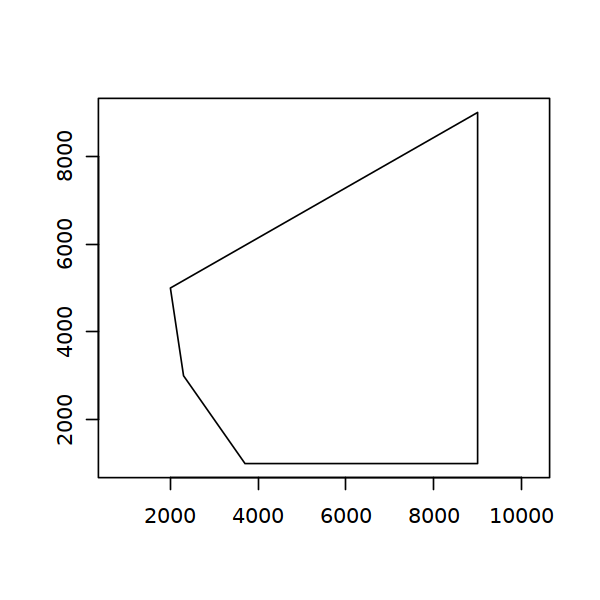

In [20]:
# check convex hull polygon for 2nd one
c_hull <- 
      st_as_sf(xy_pts[[2]], coords = c("x", "y")) %>% 
      st_combine() %>% st_convex_hull()
c_hull %>% plot(axes = TRUE)


In [23]:
# using subset 
samples_seq <- seq(2)
start_t <- Sys.time()
objs <-
  lapply(samples_seq, function(i) {
    Crop_custom(object = obj.list.xen[[i]], 
                col_id = c("cell"),
                xy_pts = xy_pts[[i]],
                c_hull_include = TRUE,
                crop_molecules = TRUE,
                BPPARAM = BiocParallel::MulticoreParam(5, tasks = 10L,
                                                       force.GC = FALSE,
                                                       progressbar = TRUE))
      
  })
end_t <- Sys.time()
end_t - start_t
objs

>>> Using `Seurat` object

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
>>> Return output - `Seurat` object

>>> Cropping molecule coordinates - might take time!



  |======================================================================| 100%



>>> Using `Seurat` object

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
>>> Return output - `Seurat` object

>>> Cropping molecule coordinates - might take time!



  |======================================================================| 100%



Time difference of 30.1247 mins

[[1]]
An object of class Seurat 
541 features across 6206 samples within 1 assay 
Active assay: Xenium (541 features, 0 variable features)
 1 spatial field of view present: mb263.Xenium

[[2]]
An object of class Seurat 
541 features across 11888 samples within 1 assay 
Active assay: Xenium (541 features, 0 variable features)
 1 spatial field of view present: mb266.Xenium


Warning message in brewer.pal(n = length(x = levels(x = molecules$molecule)), name = "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


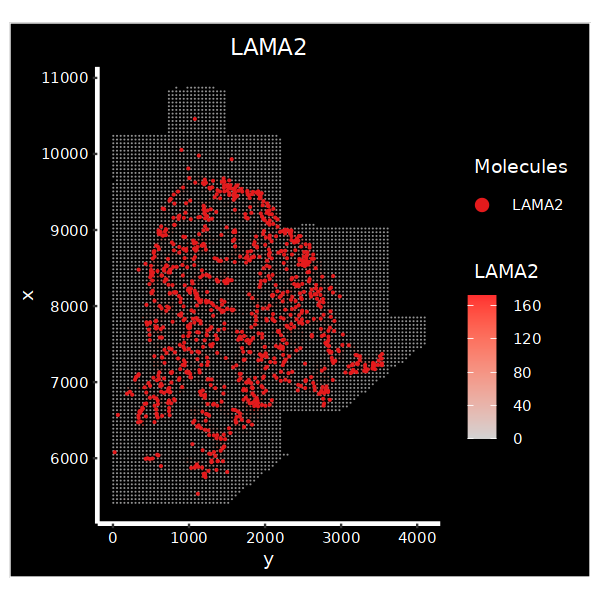

In [27]:
i <- 2
ImageFeaturePlot(objs[[1]],
                 fov = Images(objs[[1]])[1],
                 features = "LAMA2",
                 molecules = "LAMA2",
                 #mols.cols = "cyan1",
                 #mols.size = 0.5,
                 #nmols = 1000,
                 #min.cutoff = 1.5,        
                 size = 0.3,
                 border.size = NA,
                 #border.color = alpha("blue1", 0.3),
                 boundaries = "centroids",
                 #scale = "none",    
                 alpha = 0.7,
                 axes = TRUE,
                 combine = TRUE)

<span style="font-size:10pt; color:gold"> additional crop for MB295 selected "good" region </span> <br />

Warning message in brewer.pal(n = length(x = levels(x = molecules$molecule)), name = "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


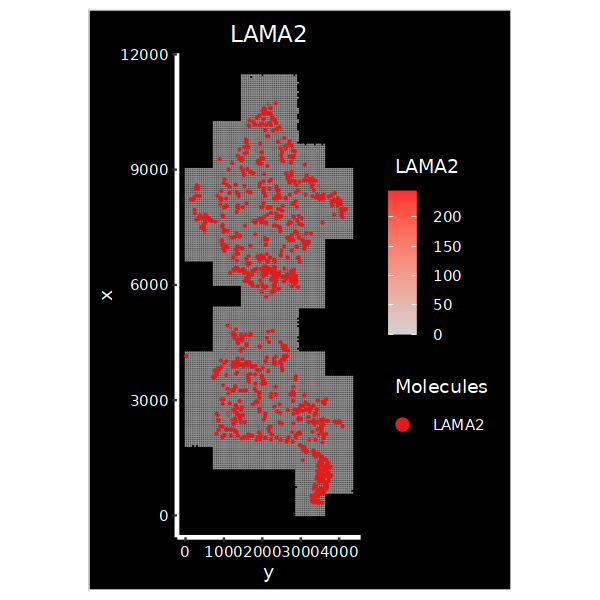

In [31]:
ImageFeaturePlot(obj.list.xen[[3]],
                 fov = Images(obj.list.xen[[3]])[1],
                 features = "LAMA2",
                 molecules = "LAMA2",
                 #mols.cols = "cyan1",
                 #mols.size = 0.5,
                 #nmols = 1000,
                 #min.cutoff = 1.5,        
                 size = 0.3,
                 border.size = NA,
                 #border.color = alpha("blue1", 0.3),
                 boundaries = "centroids",
                 #scale = "none",    
                 alpha = 0.7,
                 axes = TRUE,
                 combine = TRUE)

In [36]:
# additional crop for MB295 selected "good" region
xy_pts <- 
    list("mb295_1" = 
         data.frame("x" = c(5200, 5500, 6500, 8000, 9000, 10000, 10100, 9000, 5800),
                    "y" = c(2200, 3500, 4000, 3000, 2200, 1700, 1700, 0, 5)), 
         "mb295_2" = 
         data.frame("x" = c(1300, 2000, 2800, 5500, 5500, 5),
                    "y" = c(3000, 3600, 5000, 2500, 5, 5))
        )

In [37]:
# using subset 
start_t <- Sys.time()
obj_295 <-
    Crop_custom(object = obj.list.xen[[3]], 
                col_id = c("cell"),
                xy_pts = xy_pts,
                c_hull_include = TRUE,
                crop_molecules = TRUE,
                BPPARAM = BiocParallel::MulticoreParam(8, tasks = 10L,
                                                       force.GC = FALSE,
                                                       progressbar = TRUE))
end_t <- Sys.time()
end_t - start_t
obj_295

>>> Using `Seurat` object

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
>>> Return output - `Seurat` object

>>> Cropping molecule coordinates - might take time!



  |======================================================================| 100%



Time difference of 16.5183 mins

An object of class Seurat 
541 features across 11004 samples within 1 assay 
Active assay: Xenium (541 features, 0 variable features)
 1 spatial field of view present: mb295.Xenium

In [39]:
obj.list.xen_cloned <- obj.list.xen

In [40]:
obj.list.xen[1:2] <- objs
obj.list.xen[[3]] <- obj_295

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


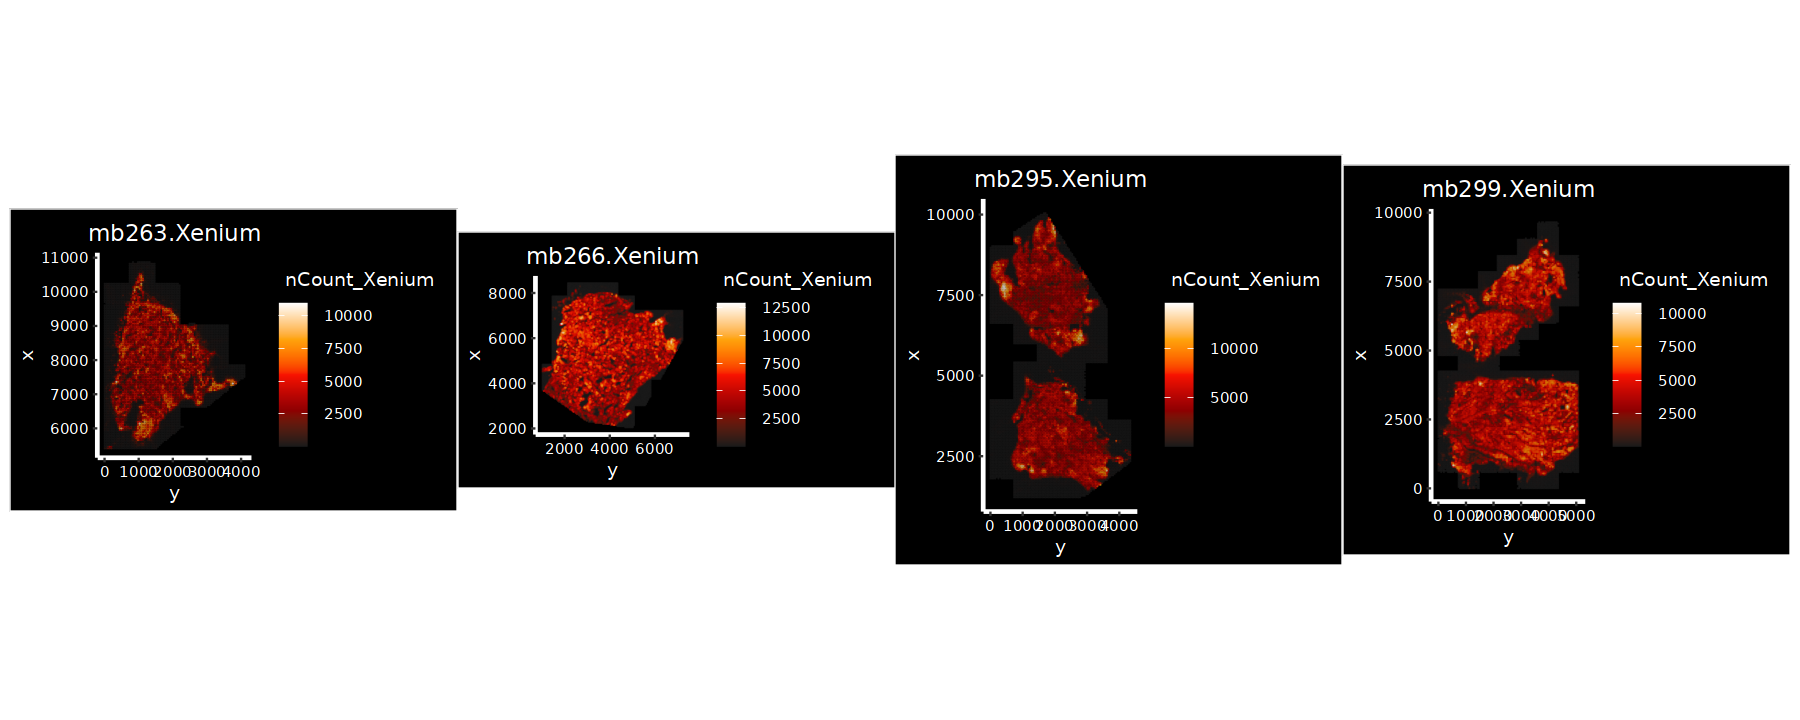

In [43]:
# plot all samples - single gene
pl_all <- 
lapply(seq(obj.list.xen), function(i) {
    ImageFeaturePlot(obj.list.xen[[i]],
                 fov = Images(obj.list.xen[[i]]),
                 features = "nCount_Xenium", #"LAMA2",
                 #molecules = "LAMA2",
                 #mols.cols = "cyan1",
                 #mols.size = 0.5,
                 #nmols = 1000,
                 #min.cutoff = 1.5,        
                 size = 0.3,
                 border.size = NA,
                 #border.color = alpha("blue1", 0.3),
                 boundaries = "centroids",
                 #scale = "none",    
                 alpha = 0.7,
                 axes = TRUE,
                 combine = TRUE) & ggtitle(Images(obj.list.xen[[i]]))
    })
# order plotting var (eg, gene expression) in an increasing order
pl_all <- 
    lapply(pl_all, function(i) {
    i$data %<>% arrange(nCount_Xenium)
    i <- i & scale_fill_gradientn(colours = c("gray10", cet_pal(5, name = "fire")[-1]))   
    return(i)
    })
options(repr.plot.height = 6, repr.plot.width = 15)
patchwork::wrap_plots(pl_all, nrow = 1)

In [44]:
# save temp
dir_path <- "./test/"
saveRDS(object = obj.list.xen, file = file.path(dir_path, "xen_mben_binned_cropped.rds"))

##### <span style="font-size:11pt; color:gold"> Merge Xenium samples/objects </span>

In [11]:
# load list clean object Xenium data
obj.list.xen <-
    readRDS(file = "./segmentation_free/objects/xen_mben_binned_cropped.rds")

In [13]:
obj.list.xen

[[1]]
An object of class Seurat 
541 features across 6206 samples within 1 assay 
Active assay: Xenium (541 features, 0 variable features)
 1 spatial field of view present: mb263.Xenium

[[2]]
An object of class Seurat 
541 features across 11888 samples within 1 assay 
Active assay: Xenium (541 features, 0 variable features)
 1 spatial field of view present: mb266.Xenium

[[3]]
An object of class Seurat 
541 features across 11004 samples within 1 assay 
Active assay: Xenium (541 features, 0 variable features)
 1 spatial field of view present: mb295.Xenium

[[4]]
An object of class Seurat 
541 features across 15303 samples within 1 assay 
Active assay: Xenium (541 features, 0 variable features)
 1 spatial field of view present: mb299.Xenium


In [14]:
# plot all samples - single gene
pl_all <- 
lapply(seq(obj.list.xen), function(i) {
    ImageFeaturePlot(obj.list.xen[[i]],
                 fov = Images(obj.list.xen[[i]]),
                 features = "LAMA2",
                 molecules = "LAMA2",
                 mols.cols = "cyan1",
                 #mols.size = 0.5,
                 nmols = 1000,
                 #min.cutoff = 1.5,        
                 size = 0.3,
                 border.size = NA,
                 #border.color = alpha("blue1", 0.3),
                 boundaries = "centroids",
                 #scale = "none",    
                 alpha = 0.7,
                 axes = TRUE,
                 combine = TRUE) & ggtitle(Images(obj.list.xen[[i]]))
    })

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


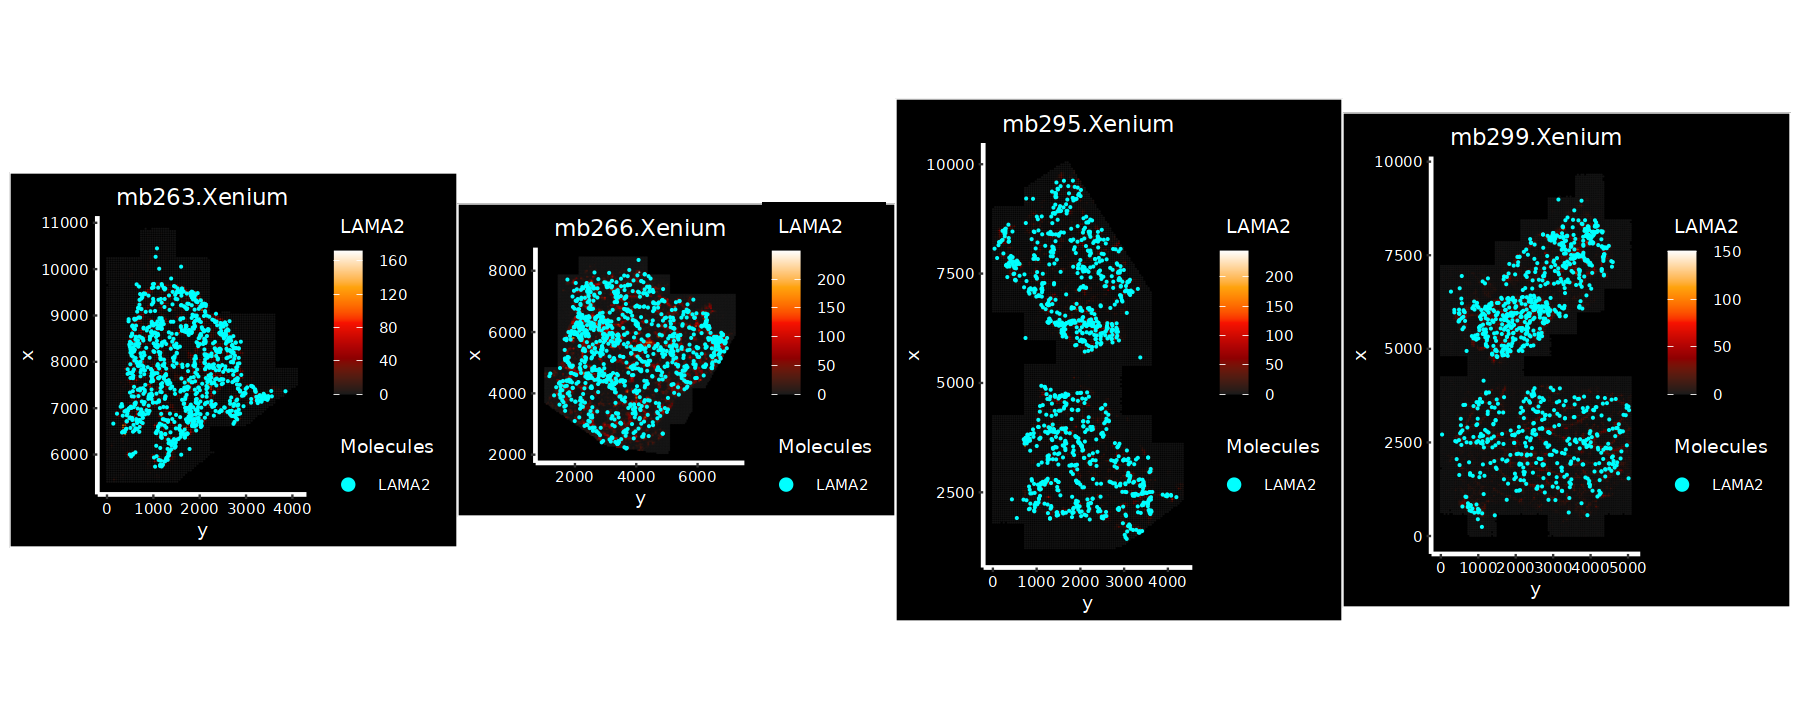

In [15]:
# order plotting var (eg, gene expression) in an increasing order
pl_all <- 
    lapply(pl_all, function(i) {
    i$data %<>% arrange(LAMA2)
    i <- i & scale_fill_gradientn(colours = c("gray10", cet_pal(5, name = "fire")[-1]))   
    return(i)
    })
options(repr.plot.height = 6, repr.plot.width = 15)
patchwork::wrap_plots(pl_all, nrow = 1)

In [26]:
# update metadata of Xenium objects
for (i in seq(obj.list.xen)) {
    obj.list.xen[[i]]@meta.data %<>% 
    #getMeta() %>%
    mutate(orig.ident = Images(obj.list.xen[[i]]),
           samples = orig.ident,
           donors = samples,
           spatial_tech = "Xenium",
           cell_id = Cells(obj.list.xen[[i]]))
    }

In [27]:
obj.list.xen[[1]] %>% getMeta %>% str

'data.frame':	6206 obs. of  9 variables:
 $ orig.ident     : chr  "mb263.Xenium" "mb263.Xenium" "mb263.Xenium" "mb263.Xenium" ...
 $ nCount_Xenium  : num  364 13 4 5 6 4 4 7 8 5 ...
 $ nFeature_Xenium: int  88 11 4 4 6 3 4 6 8 5 ...
 $ spatial_bin    : int  335 336 337 338 339 340 341 342 343 344 ...
 $ bin.size       : num  48.7 48.7 48.7 48.7 48.7 ...
 $ samples        : chr  "mb263.Xenium" "mb263.Xenium" "mb263.Xenium" "mb263.Xenium" ...
 $ donors         : chr  "mb263.Xenium" "mb263.Xenium" "mb263.Xenium" "mb263.Xenium" ...
 $ spatial_tech   : chr  "Xenium" "Xenium" "Xenium" "Xenium" ...
 $ cell_id        : chr  "spatial_bin_335" "spatial_bin_336" "spatial_bin_337" "spatial_bin_338" ...


In [28]:
# merge objs list
obj.xen <- merge(obj.list.xen[[1]], obj.list.xen[-1])
obj.xen

Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


An object of class Seurat 
541 features across 44401 samples within 1 assay 
Active assay: Xenium (541 features, 0 variable features)
 4 spatial fields of view present: mb263.Xenium mb266.Xenium mb295.Xenium mb299.Xenium

In [29]:
obj.xen %>% getMeta %>% str

'data.frame':	44401 obs. of  9 variables:
 $ orig.ident     : chr  "mb263.Xenium" "mb263.Xenium" "mb263.Xenium" "mb263.Xenium" ...
 $ nCount_Xenium  : num  364 13 4 5 6 4 4 7 8 5 ...
 $ nFeature_Xenium: int  88 11 4 4 6 3 4 6 8 5 ...
 $ spatial_bin    : int  335 336 337 338 339 340 341 342 343 344 ...
 $ bin.size       : num  48.7 48.7 48.7 48.7 48.7 ...
 $ samples        : chr  "mb263.Xenium" "mb263.Xenium" "mb263.Xenium" "mb263.Xenium" ...
 $ donors         : chr  "mb263.Xenium" "mb263.Xenium" "mb263.Xenium" "mb263.Xenium" ...
 $ spatial_tech   : chr  "Xenium" "Xenium" "Xenium" "Xenium" ...
 $ cell_id        : chr  "spatial_bin_335" "spatial_bin_336" "spatial_bin_337" "spatial_bin_338" ...


##### <span style="font-size:11pt; color:gold"> add Xenim to existing pre-filtered object(s) (ie, only with `nCount > 0`) </span>

In [30]:
obj %>% getMeta %>% str

'data.frame':	26499 obs. of  9 variables:
 $ orig.ident        : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ spatial_bin       : chr  "Vz_spatial_bin_50_1" "Vz_spatial_bin_51_1" "Vz_spatial_bin_52_1" "Vz_spatial_bin_53_1" ...
 $ bin.size          : num  48.7 48.7 48.7 48.7 48.7 ...
 $ spatial_tech      : chr  "MERFISH" "MERFISH" "MERFISH" "MERFISH" ...
 $ samples           : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ donors            : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ nCount_VizResVis  : num  1 496 742 917 659 ...
 $ nFeature_VizResVis: int  1 60 78 69 68 75 53 64 45 24 ...
 $ cell_id           : chr  NA NA NA NA ...


In [43]:
# matched target genes
g.matched <- 
    # same genes between techs
    intersect(rownames(obj), rownames(obj.xen))
g.matched %>% str

 chr [1:96] "AIF1" "AQP4" "ASTN1" "BMPR1B" "BOC" "CA10" "CD14" "CD37" "CD4" ...


In [45]:
# subset objects to matched genes
obj.xen %<>% subset_opt(features = g.matched)
obj %<>% subset_opt(features = g.matched)

Updating object slots..

Cloing object..

Matching cells in FOVs..

Cell subsets are found in all FOVs!
Subsetting object..

Subsetting FOVs..

Updating object..

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version

Object is ready!

Updating object slots..

Cloing object..

Matching cells in FOVs..

Cell subsets are found in all FOVs!
Subsetting object..

Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated w

In [46]:
obj.xen
obj

An object of class Seurat 
96 features across 44401 samples within 1 assay 
Active assay: Xenium (96 features, 0 variable features)
 4 spatial fields of view present: mb263.Xenium mb266.Xenium mb295.Xenium mb299.Xenium

An object of class Seurat 
96 features across 26499 samples within 1 assay 
Active assay: VizResVis (96 features, 0 variable features)
 11 spatial fields of view present: mb295.Vizgen mb266.Vizgen mb263.w4a1.Resolve mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb299.w7a1.Resolve mb263.Visium mb266.Visium mb295.Visium mb299.Visium

In [80]:
obj_merged <- merge(obj.list.xen[[1]], obj.list.xen[-1])
obj_merged

Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


An object of class Seurat 
541 features across 44401 samples within 1 assay 
Active assay: Xenium (541 features, 0 variable features)
 4 spatial fields of view present: mb263.Xenium mb266.Xenium mb295.Xenium mb299.Xenium

In [81]:
# save merged Xenium object - raw all genes as in molecule coords
saveRDS(object = obj_merged, file = file.path(dir_path, "xen_merged.rds"))

In [71]:
# merge object with matching genes
obj.vzre.vis_xen <- merge(RenameAssays(obj, VizResVis = "MultiTech"), 
                          RenameAssays(obj.xen, Xenium = "MultiTech"))
obj.vzre.vis_xen

Renaming default assay from VizResVis to MultiTech

Warning message:
“Cannot add objects with duplicate keys (offending key: vizresvis_) setting key to original value 'multitech_'”
Renaming default assay from Xenium to MultiTech

Warning message:
“Cannot add objects with duplicate keys (offending key: xenium_) setting key to original value 'multitech_'”


An object of class Seurat 
96 features across 70900 samples within 1 assay 
Active assay: MultiTech (96 features, 0 variable features)
 15 spatial fields of view present: mb295.Vizgen mb266.Vizgen mb263.w4a1.Resolve mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb299.w7a1.Resolve mb263.Visium mb266.Visium mb295.Visium mb299.Visium mb263.Xenium mb266.Xenium mb295.Xenium mb299.Xenium

In [73]:
# update metadata 
obj$samples %<>%
        stringi::stri_replace_all_regex(., 
                                        #pattern = "region[0-1].|w(.)[^:][0-9].", # merges same samples
                                        pattern = "region[0-1].|w[4,5,7]a1.|_[a-e]",
                                        replacement = "")
# update donors
obj$donors <- obj$samples # data comes from the same patient/sample
obj@meta.data %<>%
    mutate_if(is.character,
              ~ stringr::str_replace_all(., c("Resolve" = "MC", "Vizgen" = "MERFISH")))

In [74]:
obj.vzre.vis_xen %>% getMeta %>% str

'data.frame':	70900 obs. of  13 variables:
 $ orig.ident        : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ spatial_bin       : chr  "Vz_spatial_bin_50_1" "Vz_spatial_bin_51_1" "Vz_spatial_bin_52_1" "Vz_spatial_bin_53_1" ...
 $ bin.size          : num  48.7 48.7 48.7 48.7 48.7 ...
 $ spatial_tech      : chr  "MERFISH" "MERFISH" "MERFISH" "MERFISH" ...
 $ samples           : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ donors            : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ nCount_VizResVis  : num  1 496 742 917 659 ...
 $ nFeature_VizResVis: int  1 60 78 69 68 74 53 63 45 24 ...
 $ cell_id           : chr  NA NA NA NA ...
 $ nCount_MultiTech  : num  1 496 742 917 659 ...
 $ nFeature_MultiTech: int  1 60 78 69 68 74 53 63 45 24 ...
 $ nCount_Xenium     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ nFeature_Xenium   : int  NA NA NA NA NA NA NA NA NA NA ...


In [82]:
# sanity checks    
obj.vzre.vis_xen %<>% sanity.seurat()
obj.vzre.vis_xen

Sanity passed:
>>> A single gene is expressed in least 1 cell
>>> No genes have 0 expression in all cells

Removing cell with 0 transcript counts

Updating object slots..

Cloing object..

Matching cells in FOVs..

Cell subsets are found in all FOVs!
Subsetting object..

Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay

An object of class Seurat 
96 features across 70769 samples within 1 assay 
Active assay: MultiTech (96 features, 0 variable features)
 15 spatial fields of view present: mb295.Vizgen mb266.Vizgen mb263.w4a1.Resolve mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb299.w7a1.Resolve mb263.Visium mb266.Visium mb295.Visium mb299.Visium mb263.Xenium mb266.Xenium mb295.Xenium mb299.Xenium

In [83]:
# save merged object
saveRDS(object = obj.vzre.vis_xen, file = file.path(dir_path, "vz.re.vis.xen_matched.rds"))

##### <span style="font-size:11pt; color:gold"> add Xenium as above but including bg genes </span>

In [9]:
obj.xen_raw <- readRDS("./segmentation_free/objects/xen_merged.rds")
obj.xen_raw

An object of class Seurat 
541 features across 44401 samples within 1 assay 
Active assay: Xenium (541 features, 0 variable features)
 4 spatial fields of view present: mb263.Xenium mb266.Xenium mb295.Xenium mb299.Xenium

In [10]:
obj.xen_raw %>% getMeta %>% str

'data.frame':	44401 obs. of  9 variables:
 $ orig.ident     : chr  "mb263.Xenium" "mb263.Xenium" "mb263.Xenium" "mb263.Xenium" ...
 $ nCount_Xenium  : num  364 13 4 5 6 4 4 7 8 5 ...
 $ nFeature_Xenium: int  88 11 4 4 6 3 4 6 8 5 ...
 $ spatial_bin    : int  335 336 337 338 339 340 341 342 343 344 ...
 $ bin.size       : num  48.7 48.7 48.7 48.7 48.7 ...
 $ samples        : chr  "mb263.Xenium" "mb263.Xenium" "mb263.Xenium" "mb263.Xenium" ...
 $ donors         : chr  "mb263.Xenium" "mb263.Xenium" "mb263.Xenium" "mb263.Xenium" ...
 $ spatial_tech   : chr  "Xenium" "Xenium" "Xenium" "Xenium" ...
 $ cell_id        : chr  "spatial_bin_335" "spatial_bin_336" "spatial_bin_337" "spatial_bin_338" ...


In [8]:
obj.bg <- readRDS("./segmentation_free/objects/vz.re_matched_bg.rds")
obj.bg
obj.bg %>% getMeta %>% str

An object of class Seurat 
164 features across 16614 samples within 1 assay 
Active assay: VizRes (164 features, 0 variable features)
 7 spatial fields of view present: mb295.Vizgen mb266.Vizgen mb263.w4a1.Resolve mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb299.w7a1.Resolve

'data.frame':	16614 obs. of  8 variables:
 $ orig.ident     : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ nCount_VizRes  : num  1 507 762 953 683 ...
 $ nFeature_VizRes: int  1 71 92 88 84 92 64 76 49 26 ...
 $ spatial_bin    : chr  "Vz_spatial_bin_50_1" "Vz_spatial_bin_51_1" "Vz_spatial_bin_52_1" "Vz_spatial_bin_53_1" ...
 $ bin.size       : num  48.7 48.7 48.7 48.7 48.7 ...
 $ spatial_tech   : chr  "Vizgen" "Vizgen" "Vizgen" "Vizgen" ...
 $ samples        : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ donors         : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...


In [11]:
# matched target genes + tech-specific background genes
g.matched.bg <- 
    # same genes between techs
    intersect(rownames(obj.bg), rownames(obj.xen_raw)) %>% 
    # keep tech-specific bg genes
    c(., grep("Blank-|FP |NegControlProbe", c(rownames(obj.bg), rownames(obj.xen_raw)), value = TRUE))
g.matched.bg %>% str

 chr [1:183] "AIF1" "AQP4" "ASTN1" "BMPR1B" "BOC" "CA10" "CD14" "CD37" ...


In [14]:
# merge object with matched genes + tech-specific background genes
obj.bg_merged <- merge(x = RenameAssays(obj.bg, VizRes = "MultiTech"),
                       y = RenameAssays(obj.xen_raw, Xenium = "MultiTech"))
obj.bg_merged

Renaming default assay from VizRes to MultiTech

Warning message:
“Cannot add objects with duplicate keys (offending key: vizres_) setting key to original value 'multitech_'”
Renaming default assay from Xenium to MultiTech

Warning message:
“Cannot add objects with duplicate keys (offending key: xenium_) setting key to original value 'multitech_'”


An object of class Seurat 
609 features across 61015 samples within 1 assay 
Active assay: MultiTech (609 features, 0 variable features)
 11 spatial fields of view present: mb295.Vizgen mb266.Vizgen mb263.w4a1.Resolve mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb299.w7a1.Resolve mb263.Xenium mb266.Xenium mb295.Xenium mb299.Xenium

In [15]:
obj.bg_merged %<>% subset_opt(features = g.matched.bg)

Updating object slots..

Cloing object..

Matching cells in FOVs..

Cell subsets are found in all FOVs!
Subsetting object..

Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associat

In [16]:
obj.bg_merged

An object of class Seurat 
183 features across 61015 samples within 1 assay 
Active assay: MultiTech (183 features, 0 variable features)
 11 spatial fields of view present: mb295.Vizgen mb266.Vizgen mb263.w4a1.Resolve mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb299.w7a1.Resolve mb263.Xenium mb266.Xenium mb295.Xenium mb299.Xenium

In [17]:
obj.bg_merged %>% getMeta %>% str

'data.frame':	61015 obs. of  13 variables:
 $ orig.ident        : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ nCount_VizRes     : num  1 507 762 953 683 ...
 $ nFeature_VizRes   : int  1 71 92 88 84 92 64 76 49 26 ...
 $ spatial_bin       : chr  "Vz_spatial_bin_50_1" "Vz_spatial_bin_51_1" "Vz_spatial_bin_52_1" "Vz_spatial_bin_53_1" ...
 $ bin.size          : num  48.7 48.7 48.7 48.7 48.7 ...
 $ spatial_tech      : chr  "Vizgen" "Vizgen" "Vizgen" "Vizgen" ...
 $ samples           : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ donors            : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ nCount_MultiTech  : num  1 507 762 953 683 ...
 $ nFeature_MultiTech: int  1 71 92 88 84 91 64 75 49 26 ...
 $ nCount_Xenium     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ nFeature_Xenium   : int  NA NA NA NA NA NA NA NA NA NA ...
 $ cell_id           : chr  NA NA NA NA ...


In [20]:
# update metadata
obj.bg_merged@meta.data %<>%
    select(!contains(c("_Xenium","_VizRes","cell_"))) %>%
    mutate(cell_id = Cells(obj.bg_merged)) %>%
    mutate_if(is.character,
              ~ stringr::str_replace_all(., c("Resolve" = "MC", "Vizgen" = "MERFISH")))

In [21]:
obj.bg_merged %>% getMeta %>% str

'data.frame':	61015 obs. of  9 variables:
 $ orig.ident        : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ spatial_bin       : chr  "Vz_spatial_bin_50_1" "Vz_spatial_bin_51_1" "Vz_spatial_bin_52_1" "Vz_spatial_bin_53_1" ...
 $ bin.size          : num  48.7 48.7 48.7 48.7 48.7 ...
 $ spatial_tech      : chr  "MERFISH" "MERFISH" "MERFISH" "MERFISH" ...
 $ samples           : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ donors            : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ nCount_MultiTech  : num  1 507 762 953 683 ...
 $ nFeature_MultiTech: int  1 71 92 88 84 91 64 75 49 26 ...
 $ cell_id           : chr  "Vz_spatial_bin_50_1" "Vz_spatial_bin_51_1" "Vz_spatial_bin_52_1" "Vz_spatial_bin_53_1" ...


In [22]:
saveRDS(object = obj.bg_merged, file = file.path(dir_path, "vz.re.xen_matched_bg.rds"))

#### <span style="font-size:12pt; color:gold"> Load merged pre-filtered object(s) (ie, only with `nCount > 0`) - with Xenium </span>
<span style="font-size:10pt; color:tomato">***MB295, 266*** samples (2nd run).. Vizgen </span> <br />
<span style="font-size:10pt; color:tomato">***MB299, 295, 266, 263*** samples..Resolve, 10X Visium & Xenium </span> <br />

In [6]:
dir_path <- "./segmentation_free/objects"
file2load <- list.files(dir_path, pattern = "vz.re.vis.xen_matched.rds", full.names = TRUE)

message("Loading ", "'", file2load %>% 
        gsub(pattern = paste0(dir_path, "|", "/"), replacement = "", .), "'", " object")
obj <- readRDS(file2load)
obj

Loading 'vz.re.vis.xen_matched.rds' object



An object of class Seurat 
96 features across 70769 samples within 1 assay 
Active assay: MultiTech (96 features, 0 variable features)
 15 spatial fields of view present: mb295.Vizgen mb266.Vizgen mb263.w4a1.Resolve mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb299.w7a1.Resolve mb263.Visium mb266.Visium mb295.Visium mb299.Visium mb263.Xenium mb266.Xenium mb295.Xenium mb299.Xenium

In [7]:
# update metadata
obj@meta.data %<>%
    select(!contains(c("_Xenium","_VizRes","cell_"))) %>%
    mutate(cell_id = Cells(obj)) %>%
    mutate_if(is.character,
              ~ stringr::str_replace_all(., c("Resolve" = "MC", "Vizgen" = "MERFISH")))

In [8]:
obj %>% getMeta %>% str

'data.frame':	70769 obs. of  9 variables:
 $ orig.ident        : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ spatial_bin       : chr  "Vz_spatial_bin_50_1" "Vz_spatial_bin_51_1" "Vz_spatial_bin_52_1" "Vz_spatial_bin_53_1" ...
 $ bin.size          : num  48.7 48.7 48.7 48.7 48.7 ...
 $ spatial_tech      : chr  "MERFISH" "MERFISH" "MERFISH" "MERFISH" ...
 $ samples           : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ donors            : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ nCount_MultiTech  : num  1 496 742 917 659 ...
 $ nFeature_MultiTech: int  1 60 78 69 68 74 53 63 45 24 ...
 $ cell_id           : chr  "Vz_spatial_bin_50_1" "Vz_spatial_bin_51_1" "Vz_spatial_bin_52_1" "Vz_spatial_bin_53_1" ...


In [6]:
# load object wtih BG
obj <- readRDS("./segmentation_free/objects/vz.re.xen_matched_bg.rds")
obj

An object of class Seurat 
183 features across 61015 samples within 1 assay 
Active assay: MultiTech (183 features, 0 variable features)
 11 spatial fields of view present: mb295.Vizgen mb266.Vizgen mb263.w4a1.Resolve mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb299.w7a1.Resolve mb263.Xenium mb266.Xenium mb295.Xenium mb299.Xenium

In [7]:
obj %>% getMeta %>% str

'data.frame':	61015 obs. of  9 variables:
 $ orig.ident        : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ spatial_bin       : chr  "Vz_spatial_bin_50_1" "Vz_spatial_bin_51_1" "Vz_spatial_bin_52_1" "Vz_spatial_bin_53_1" ...
 $ bin.size          : num  48.7 48.7 48.7 48.7 48.7 ...
 $ spatial_tech      : chr  "MERFISH" "MERFISH" "MERFISH" "MERFISH" ...
 $ samples           : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ donors            : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ nCount_MultiTech  : num  1 507 762 953 683 ...
 $ nFeature_MultiTech: int  1 71 92 88 84 91 64 75 49 26 ...
 $ cell_id           : chr  "Vz_spatial_bin_50_1" "Vz_spatial_bin_51_1" "Vz_spatial_bin_52_1" "Vz_spatial_bin_53_1" ...


In [8]:
rownames(obj)

[1] "AIF1"                  "AQP4"                  "ASTN1"                
  [4] "BMPR1B"                "BOC"                   "CA10"                 
  [7] "CD14"                  "CD37"                  "CD4"                  
 [10] "CD44"                  "CD83"                  "CFAP44"               
 [13] "CNTN2"                 "CNTNAP5"               "COL1A2"               
 [16] "DCAF4"                 "DCN"                   "DDX31"                
 [19] "DRAXIN"                "EGFR"                  "EPHA8"                
 [22] "ERBB4"                 "EZH2"                  "FOXJ1"                
 [25] "FOXP2"                 "GLI1"                  "GLI2"                 
 [28] "GPC5"                  "GRIA2"                 "GRIN2B"               
 [31] "HHIP"                  "HS6ST3"                "IGDCC3"               
 [34] "IGF1"                  "IGFBP7"                "ITGAM"                
 [37] "LAMA2"                 "LHX9"                  "MEIS2"                
 [40] "MKI67"                 "MYC"                   "MYCN"                 
 [43] "NCAM1"                 "NCAM2"                 "NNAT"                 
 [46] "NRXN3"                 "PBX3"                  "PTCH1"                
 [49] "QKI"                   "RALYL"                 "RBFOX3"               
 [52] "SEMA6A"                "SLC35F3"               "SV2B"                 
 [55] "TLL1"                  "TMEM108"               "TOP2A"                
 [58] "TRPM3"                 "ZFHX3"                 "CD163"                
 [61] "CTLA4"                 "DSCAM"                 "EOMES"                
 [64] "ESRRG"                 "FCGR3A"                "GABRA5"               
 [67] "GFI1"                  "GFI1B"                 "GLRA1"                
 [70] "GRM8"                  "KHDRBS2"               "LMX1A"                
 [73] "MIR4435-2HG"           "MOG"                   "NCKAP5"               
 [76] "OLIG2"                 "PLEKHA7"               "POU5F1B"              
 [79] "PRDM6"                 "PTPRO"                 "SRC"                  
 [82] "TMEM119"               "TMEM132D"              "TNC"                  
 [85] "CCR7"                  "CD19"                  "EPHA5"                
 [88] "OTX2"                  "PTPRC"                 "TULP1"                
 [91] "NPAS3"                 "TRPC3"                 "DIAPH3"               
 [94] "RIT2"                  "IL4"                   "CD69"                 
 [97] "FP 97"                 "FP 49"                 "FP 128"               
[100] "FP 66"                 "FP 65"                 "FP 89"                
[103] "FP 104"                "FP 51"                 "FP 83"                
[106] "FP 85"                 "FP 40"                 "FP 34"                
[109] "FP 63"                 "FP 42"                 "FP 75"                
[112] "FP 124"                "FP 9"                  "FP 7"                 
[115] "FP 111"                "FP 15"                 "FP 125"               
[118] "FP 54"                 "FP 23"                 "FP 72"                
[121] "FP 99"                 "FP 39"                 "FP 92"                
[124] "Blank-15"              "Blank-18"              "Blank-21"             
[127] "Blank-26"              "Blank-31"              "Blank-39"             
[130] "Blank-4"               "Blank-1"               "Blank-13"             
[133] "Blank-14"              "Blank-2"               "Blank-20"             
[136] "Blank-27"              "Blank-34"              "Blank-38"             
[139] "Blank-5"               "Blank-6"               "Blank-7"              
[142] "Blank-8"               "Blank-9"               "Blank-11"             
[145] "Blank-16"              "Blank-17"              "Blank-19"             
[148] "Blank-25"              "Blank-28"              "Blank-29"             
[151] "Blank-30"              "Blank-32"              "Blank-33"             
[154] "Blank-3"         

In [25]:
# plot all samples - transcript counts per bin
pl_all <- 
lapply(seq(Images(obj)), function(i) {
    ImageFeaturePlot(obj,
                 fov = Images(obj)[i],
                 features = "nCount_MultiTech",
                 #molecules = "LAMA2",
                 #mols.cols = "cyan1",
                 #mols.size = 0.5,
                 #nmols = 1000,
                 #min.cutoff = 1.5,        
                 size = 0.3,
                 border.size = NA,
                 #border.color = alpha("blue1", 0.3),
                 boundaries = "centroids",
                 #scale = "none",    
                 alpha = 0.7,
                 axes = TRUE,
                 combine = TRUE) & ggtitle(Images(obj)[i])
    })

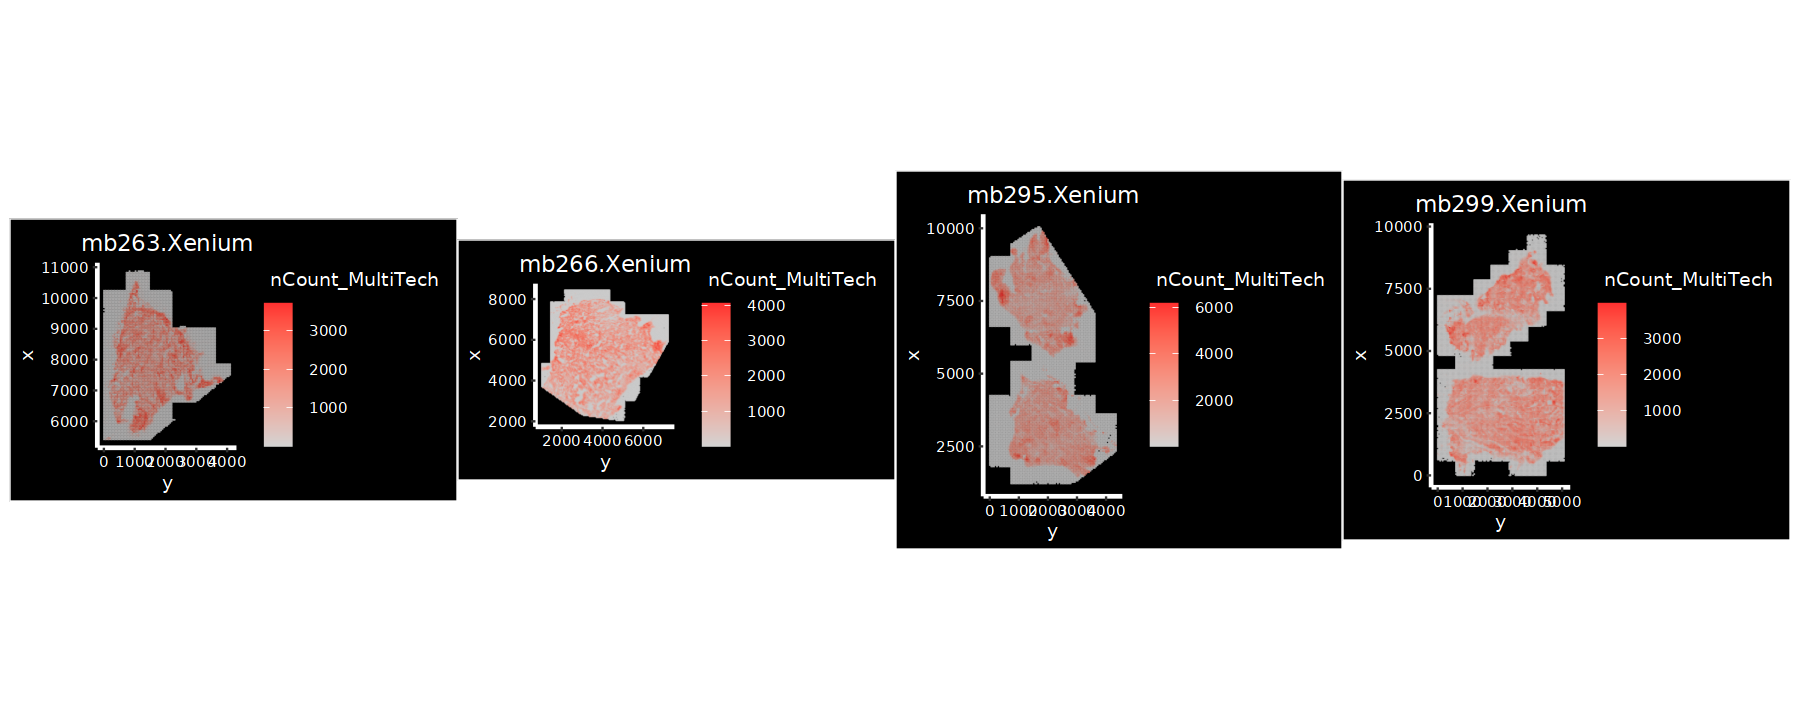

In [13]:
options(repr.plot.height = 6, repr.plot.width = 15)
patchwork::wrap_plots(pl_all[12:15], nrow = 1)

In [14]:
# plot all samples - single gene
pl_all <- 
lapply(seq(Images(obj)), function(i) {
    ImageFeaturePlot(obj,
                 fov = Images(obj)[i],
                 features = "LAMA2",
                 molecules = "LAMA2",
                 mols.cols = "cyan1",
                 #mols.size = 0.5,
                 #nmols = 1000,
                 #min.cutoff = 1.5,        
                 size = 0.3,
                 border.size = NA,
                 #border.color = alpha("blue1", 0.3),
                 boundaries = "centroids",
                 #scale = "none",    
                 alpha = 0.7,
                 axes = TRUE,
                 combine = TRUE) & ggtitle(Images(obj)[i])
    })

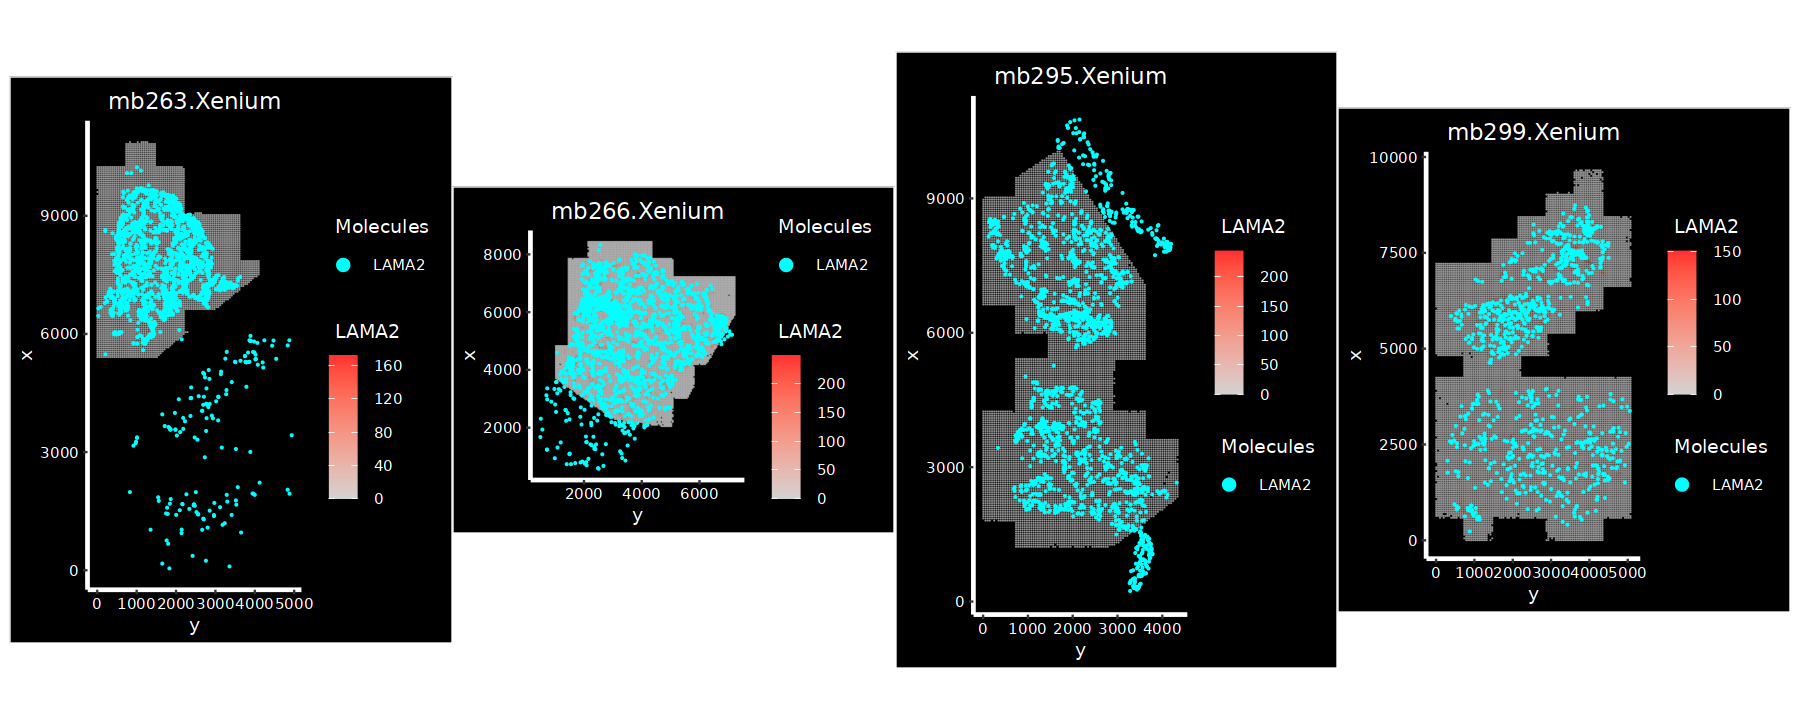

In [15]:
options(repr.plot.height = 6, repr.plot.width = 15)
patchwork::wrap_plots(pl_all[12:15], nrow = 1)

In [21]:
obj$nCount_MultiTech %>% range

[1]    1 6173

In [ ]:
# order plotting var (eg, gene expression) in an increasing order
pl_all <- 
    lapply(pl_all, function(i) {
    i$data %<>% arrange(nCount_MultiTech)
    i <- i & scale_fill_gradientn(colours = c("gray10", cet_pal(5, name = "fire")[-1]))   
    return(i)
    })
options(repr.plot.height = 6, repr.plot.width = 15)
patchwork::wrap_plots(pl_all[12:15], nrow = 1)

#### <span style="font-size:12pt; color:gold"> Normalize data </span>
<span style="font-size:10pt; color:tomato"> `SCTransform` </span> 

In [ ]:
start.time <- Sys.time()
# fast analysis
obj %<>% 
    SCTransform(assay = "MultiTech", 
                verbose = FALSE)
end.time <- Sys.time()
end.time - start.time
obj

In [9]:
# clone obj
obj_techs <- obj

In [14]:
# extract mols coords df, use it for spatial binning
xen_dfs <- lapply(obj.list.xen, function(i) {
    i[[Images(i)]][["molecules"]] %>% 
        GetTissueCoordinates()
    })
xen_dfs %>% str

List of 4
 $ :'data.frame':	22479886 obs. of  3 variables:
  ..$ x       : num [1:22479886] 21.4 17.6 21.5 19.5 24.9 ...
  ..$ y       : num [1:22479886] 1910 2257 2263 2396 2705 ...
  ..$ molecule: chr [1:22479886] "ABCC9" "ABCC9" "ABCC9" "ABCC9" ...
 $ :'data.frame':	40634263 obs. of  3 variables:
  ..$ x       : num [1:40634263] 3483 381 412 414 405 ...
  ..$ y       : num [1:40634263] 23.4 1884.8 2315.8 2399.5 2461.5 ...
  ..$ molecule: chr [1:40634263] "ABCC9" "ABCC9" "ABCC9" "ABCC9" ...
 $ :'data.frame':	37499768 obs. of  3 variables:
  ..$ x       : num [1:37499768] 3223 8223 8301 8321 120 ...
  ..$ y       : num [1:37499768] 27.9 18.3 25.2 12.6 2987.5 ...
  ..$ molecule: chr [1:37499768] "ABCC9" "ABCC9" "ABCC9" "ABCC9" ...
 $ :'data.frame':	37707205 obs. of  3 variables:
  ..$ x       : num [1:37707205] 5.62 21.92 703.12 6794.16 109.75 ...
  ..$ y       : num [1:37707205] 1174.29 3019.87 26.52 6.87 3489.49 ...
  ..$ molecule: chr [1:37707205] "ABCC9" "ABCC9" "ABCC9" "ABCC9" ...

In [15]:
names(xen_dfs) <- lapply(obj.list.xen, Images) %>% unlist

In [16]:
names(xen_dfs)

[1] "mb263.Xenium" "mb266.Xenium" "mb295.Xenium" "mb299.Xenium"

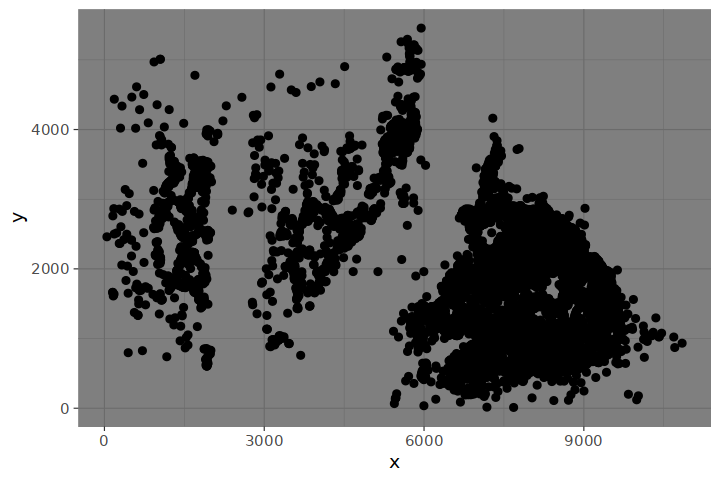

In [27]:
# plot subsampled - LAMA2 
options(repr.plot.height = 4, repr.plot.width = 6)
# needs to be cropped before or afterwards
xen_dfs[[1]] %>% filter(molecule == "LAMA2") %>% sample_frac(size = 0.1) %>% 
ggplot(aes(x, y)) & geom_point() & theme_dark()

In [29]:
# extract mols coords from an object
#obj$samples %>% table
Images(obj)

[1] "mb295.Vizgen"       "mb266.Vizgen"       "mb263.w4a1.Resolve"
 [4] "mb266.w5a1.Resolve" "mb295.w6a1.Resolve" "mb295.w6a2.Resolve"
 [7] "mb299.w7a1.Resolve" "mb263.Visium"       "mb266.Visium"      
[10] "mb295.Visium"       "mb299.Visium"       "mb263.Xenium"      
[13] "mb266.Xenium"       "mb295.Xenium"       "mb299.Xenium"

In [17]:
# extract mols coords df (except Visium), use it for spatial binning
xy_coords_dfs.samples <- lapply(grep("Visium", Images(obj), invert = TRUE), 
                          function(i) {
    obj[[Images(obj)[i]]][["molecules"]] %>% 
        GetTissueCoordinates()
    })

In [18]:
names(xy_coords_dfs.samples) <- grep("Visium", Images(obj), invert = TRUE, value = TRUE)

In [19]:
xy_coords_dfs.samples$mb266.Vizgen$molecule %>% unique %>% grep("Blank-", ., invert = T) %>% str

 int [1:96] 1 2 3 4 5 6 7 8 9 10 ...


In [20]:
xy_coords_dfs.samples$mb266.Vizgen$molecule %>% unique

[1] "AIF1"        "AQP4"        "ASTN1"       "BMPR1B"      "BOC"        
  [6] "CA10"        "CD14"        "CD37"        "CD4"         "CD44"       
 [11] "CD83"        "CFAP44"      "CNTN2"       "CNTNAP5"     "COL1A2"     
 [16] "DCAF4"       "DCN"         "DDX31"       "DRAXIN"      "EGFR"       
 [21] "EPHA8"       "ERBB4"       "EZH2"        "FOXJ1"       "FOXP2"      
 [26] "GLI1"        "GLI2"        "GPC5"        "GRIA2"       "GRIN2B"     
 [31] "HHIP"        "HS6ST3"      "IGDCC3"      "IGF1"        "IGFBP7"     
 [36] "ITGAM"       "LAMA2"       "LHX9"        "MEIS2"       "MKI67"      
 [41] "MYC"         "MYCN"        "NCAM1"       "NCAM2"       "NNAT"       
 [46] "NRXN3"       "PBX3"        "PTCH1"       "QKI"         "RALYL"      
 [51] "RBFOX3"      "SEMA6A"      "SLC35F3"     "SV2B"        "TLL1"       
 [56] "TMEM108"     "TOP2A"       "TRPM3"       "ZFHX3"       "CD163"      
 [61] "CTLA4"       "DSCAM"       "EOMES"       "ESRRG"       "FCGR3A"     
 [66] "GABRA5"      "GFI1"        "GFI1B"       "GLRA1"       "GRM8"       
 [71] "KHDRBS2"     "LMX1A"       "MIR4435-2HG" "MOG"         "NCKAP5"     
 [76] "OLIG2"       "PLEKHA7"     "POU5F1B"     "PRDM6"       "PTPRO"      
 [81] "SRC"         "TMEM119"     "TMEM132D"    "TNC"         "CCR7"       
 [86] "CD19"        "EPHA5"       "OTX2"        "PTPRC"       "TULP1"      
 [91] "NPAS3"       "TRPC3"       "DIAPH3"      "RIT2"        "IL4"        
 [96] "CD69"        "Blank-15"    "Blank-18"    "Blank-21"    "Blank-26"   
[101] "Blank-31"    "Blank-39"    "Blank-4"     "Blank-1"     "Blank-13"   
[106] "Blank-14"    "Blank-2"     "Blank-20"    "Blank-27"    "Blank-34"   
[111] "Blank-38"    "Blank-5"     "Blank-6"     "Blank-7"     "Blank-8"    
[116] "Blank-9"     "Blank-11"    "Blank-16"    "Blank-17"    "Blank-19"   
[121] "Blank-25"    "Blank-28"    "Blank-29"    "Blank-30"    "Blank-32"   
[126] "Blank-33"    "Blank-3"     "Blank-24"    "Blank-12"    "Blank-23"   
[131] "Blank-35"    "Blank-36"    "Blank-37"    "Blank-22"    "Blank-10"   
[136] "Blank-40"

In [22]:
xy_coords_dfs.samples %>% str

List of 11
 $ mb295.Vizgen      :'data.frame':	7155434 obs. of  3 variables:
  ..$ x       : num [1:7155434] 6425 6424 6435 6423 6436 ...
  ..$ y       : num [1:7155434] 8470 8468 8678 8940 8955 ...
  ..$ molecule: chr [1:7155434] "AIF1" "AIF1" "AIF1" "AIF1" ...
 $ mb266.Vizgen      :'data.frame':	8086277 obs. of  3 variables:
  ..$ x       : num [1:8086277] 33.9 30.6 21.3 15.2 20.4 ...
  ..$ y       : num [1:8086277] 5842 5845 5823 5826 5818 ...
  ..$ molecule: chr [1:8086277] "AIF1" "AIF1" "AIF1" "AIF1" ...
 $ mb263.w4a1.Resolve:'data.frame':	2615670 obs. of  3 variables:
  ..$ x       : num [1:2615670] -10.9 -1.24 -19.32 -10.63 -22.36 ...
  ..$ y       : num [1:2615670] 113 306 455 512 465 ...
  ..$ molecule: chr [1:2615670] "AIF1" "AIF1" "AIF1" "AIF1" ...
 $ mb266.w5a1.Resolve:'data.frame':	3227434 obs. of  3 variables:
  ..$ x       : num [1:3227434] -16.01 -3.31 -2.21 -3.04 -18.08 ...
  ..$ y       : num [1:3227434] 21.1 60 24.8 57.5 192.2 ...
  ..$ molecule: chr [1:3227434] "AIF

In [11]:
xen_dfs.samples <- xy_coords_dfs.samples

In [12]:
xen_dfs.samples %>% str

List of 11
 $ mb295.Vizgen      :'data.frame':	7155434 obs. of  3 variables:
  ..$ x       : num [1:7155434] 6425 6424 6435 6423 6436 ...
  ..$ y       : num [1:7155434] 8470 8468 8678 8940 8955 ...
  ..$ molecule: chr [1:7155434] "AIF1" "AIF1" "AIF1" "AIF1" ...
 $ mb266.Vizgen      :'data.frame':	8086277 obs. of  3 variables:
  ..$ x       : num [1:8086277] 33.9 30.6 21.3 15.2 20.4 ...
  ..$ y       : num [1:8086277] 5842 5845 5823 5826 5818 ...
  ..$ molecule: chr [1:8086277] "AIF1" "AIF1" "AIF1" "AIF1" ...
 $ mb263.w4a1.Resolve:'data.frame':	2615670 obs. of  3 variables:
  ..$ x       : num [1:2615670] -10.9 -1.24 -19.32 -10.63 -22.36 ...
  ..$ y       : num [1:2615670] 113 306 455 512 465 ...
  ..$ molecule: chr [1:2615670] "AIF1" "AIF1" "AIF1" "AIF1" ...
 $ mb266.w5a1.Resolve:'data.frame':	3227434 obs. of  3 variables:
  ..$ x       : num [1:3227434] -16.01 -3.31 -2.21 -3.04 -18.08 ...
  ..$ y       : num [1:3227434] 21.1 60 24.8 57.5 192.2 ...
  ..$ molecule: chr [1:3227434] "AIF

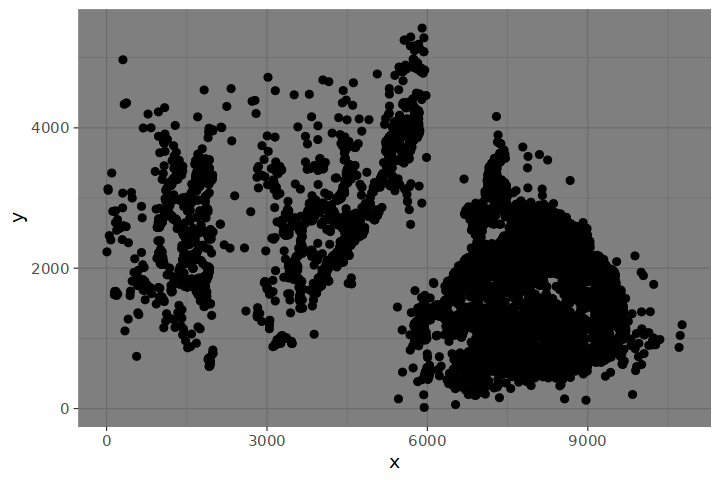

In [105]:
# plot subsampled - LAMA2 
# needs to be cropped
options(repr.plot.height = 4, repr.plot.width = 6)
xen_dfs.samples$mb263.Xenium %>% filter(molecule == "LAMA2") %>% sample_frac(size = 0.1) %>% 
ggplot(aes(x, y)) & geom_point() & theme_dark()

In [106]:
# crop Xenium
xen_dfs.samples_xen <- xen_dfs.samples[grep("Xen", names(xen_dfs.samples))]
xen_dfs.samples_xen %>% str

List of 4
 $ mb263.Xenium:'data.frame':	8074466 obs. of  3 variables:
  ..$ x       : num [1:8074466] 24.3 24.8 13.6 24.5 10.6 ...
  ..$ y       : num [1:8074466] 2132 2171 2176 2184 2207 ...
  ..$ molecule: chr [1:8074466] "AIF1" "AIF1" "AIF1" "AIF1" ...
 $ mb266.Xenium:'data.frame':	13084371 obs. of  3 variables:
  ..$ x       : num [1:13084371] 1738 1739 1949 2837 2837 ...
  ..$ y       : num [1:13084371] 7.54 6.12 11.63 14.31 8.83 ...
  ..$ molecule: chr [1:13084371] "AIF1" "AIF1" "AIF1" "AIF1" ...
 $ mb295.Xenium:'data.frame':	15398439 obs. of  3 variables:
  ..$ x       : num [1:15398439] 27.13 27.2 7.51 18.48 11.68 ...
  ..$ y       : num [1:15398439] 3066 3067 3238 3338 3512 ...
  ..$ molecule: chr [1:15398439] "AIF1" "AIF1" "AIF1" "AIF1" ...
 $ mb299.Xenium:'data.frame':	14154851 obs. of  3 variables:
  ..$ x       : num [1:14154851] 6.26 18.05 5.69 4.23 878.63 ...
  ..$ y       : num [1:14154851] 1278.7 1272.5 1278.9 3843.8 22.5 ...
  ..$ molecule: chr [1:14154851] "AIF1" "AI

##### <span style="font-size:10pt; color:gold"> additional crop for MB295 selected "good" region </span> <br />

In [107]:
# custom crop
source("./scripts/crop_seurat_v1.R")

In [108]:
# crop to cut out selected "good" region
xy_pts <- 
    list("mb263" = 
         data.frame("x" = c(5400, 11000, 5400, 6100, 7500, 11000),
                    "y" = c(0, 0, 1500, 2000, 4100, 4100)), 
         "mb266" = 
         data.frame("x" = c(3700, 9000, 9000, 9000, 2000, 2300),
                    "y" = c(1000, 1000, 9000, 4000, 5000, 3000))
        )

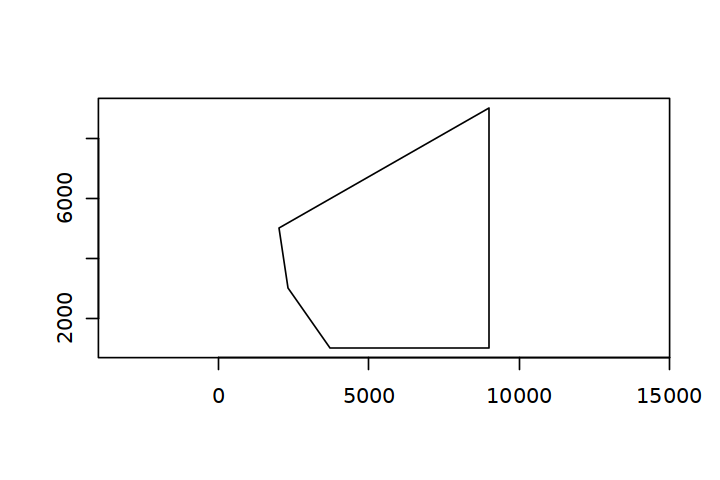

In [109]:
# check convex hull polygon for 2nd one
c_hull <- 
      st_as_sf(xy_pts[[2]], coords = c("x", "y")) %>% 
      st_combine() %>% st_convex_hull()
c_hull %>% plot(axes = TRUE)


'data.frame':	8074 obs. of  3 variables:
 $ x       : num  8001 6810 3245 7926 8858 ...
 $ y       : num  890 1253 928 652 1408 ...
 $ molecule: chr  "NRXN3" "RBFOX3" "NRXN3" "OLIG2" ...


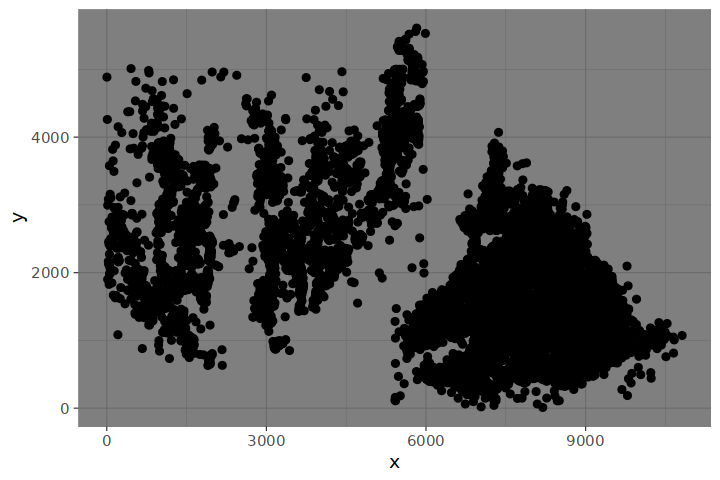

In [101]:
test <- 
xen_dfs.samples_xen$mb263.Xenium %>% sample_frac(size = 0.001)
test %>% str
test %>%
ggplot(aes(x, y)) & geom_point() & theme_dark()

In [110]:
# using subset 
samples_seq <- seq(2)
start_t <- Sys.time()
xen_dfs_2samples <-
#test_crop <-
  lapply(samples_seq, function(i) {
      Crop_custom(x = xen_dfs.samples_xen[[i]], 
                col_id = c("molecule"),
                xy_pts = xy_pts[[i]],
                c_hull_include = TRUE,
                crop_molecules = TRUE,
                BPPARAM = BiocParallel::MulticoreParam(10, tasks = 10L,
                                                       force.GC = FALSE,
                                                       progressbar = TRUE))
      
  })
end_t <- Sys.time()
end_t - start_t

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
>>> Cropping `data.frame`



  |======================================================================| 100%



>>> Return output: `data.frame`

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
>>> Cropping `data.frame`



  |======================================================================| 100%



>>> Return output: `data.frame`



Time difference of 18.6839 mins

List of 1
 $ :Classes ‘data.table’ and 'data.frame':	5048 obs. of  3 variables:
  ..$ x       : num [1:5048] 8001 5865 9556 8026 7121 ...
  ..$ y       : num [1:5048] 890 904 1634 1052 244 ...
  ..$ molecule: chr [1:5048] "NRXN3" "NRXN3" "NRXN3" "NRXN3" ...
  ..- attr(*, ".internal.selfref")=<externalptr> 


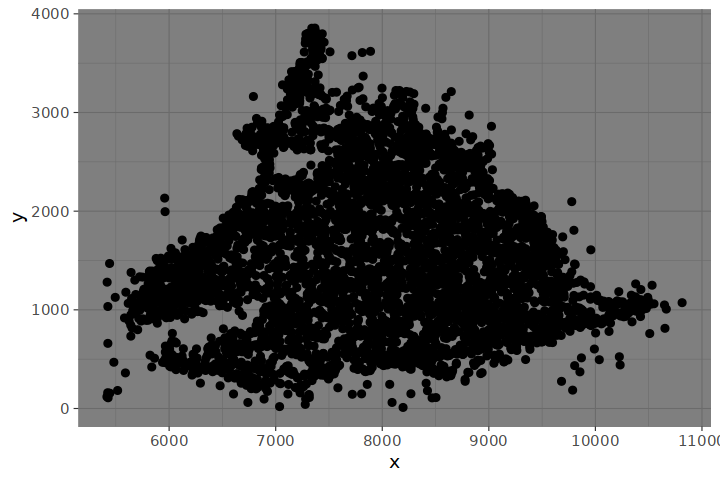

In [103]:
test_crop %>% str
test_crop[[1]] %>% 
ggplot(aes(x, y)) & geom_point() & theme_dark()

In [111]:
names(xen_dfs_2samples) <- names(xen_dfs.samples_xen[1:2])
xen_dfs_2samples %>% str

List of 2
 $ mb263.Xenium:Classes ‘data.table’ and 'data.frame':	5021538 obs. of  3 variables:
  ..$ x       : num [1:5021538] 5973 5976 5974 6250 6298 ...
  ..$ y       : num [1:5021538] 9.2 7.51 8.6 28.72 22.43 ...
  ..$ molecule: chr [1:5021538] "AIF1" "AIF1" "AIF1" "AIF1" ...
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ mb266.Xenium:Classes ‘data.table’ and 'data.frame':	11625167 obs. of  3 variables:
  ..$ x       : num [1:11625167] 2083 2143 2150 2169 2167 ...
  ..$ y       : num [1:11625167] 4663 4109 4113 4111 4113 ...
  ..$ molecule: chr [1:11625167] "AIF1" "AIF1" "AIF1" "AIF1" ...
  ..- attr(*, ".internal.selfref")=<externalptr> 


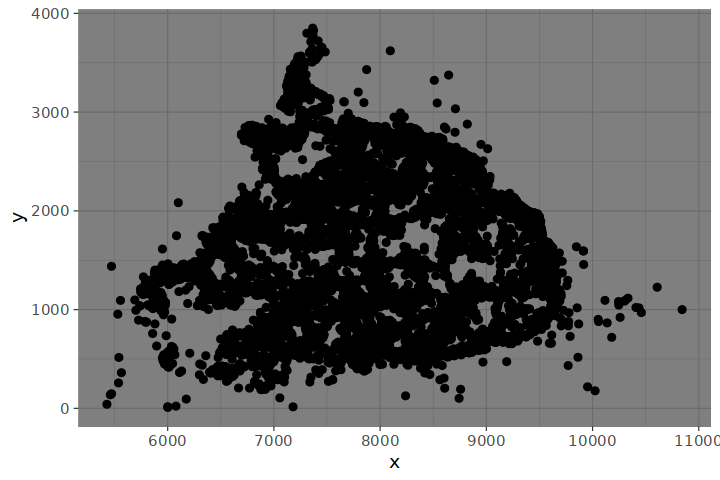

In [113]:
# plot subsampled - LAMA2 
# after cropping
options(repr.plot.height = 4, repr.plot.width = 6)
xen_dfs_2samples$mb263.Xenium %>% filter(molecule == "LAMA2") %>% sample_frac(size = 0.1) %>% 
ggplot(aes(x, y)) & geom_point() & theme_dark()

<span style="font-size:10pt; color:gold"> additional crop for MB295 selected "good" region </span> <br />

In [115]:
# additional crop for MB295 selected "good" region
xy_pts <- 
    list("mb295_1" = 
         data.frame("x" = c(5200, 5500, 6500, 8000, 9000, 10000, 10100, 9000, 5800),
                    "y" = c(2200, 3500, 4000, 3000, 2200, 1700, 1700, 0, 5)), 
         "mb295_2" = 
         data.frame("x" = c(1300, 2000, 2800, 5500, 5500, 5),
                    "y" = c(3000, 3600, 5000, 2500, 5, 5))
        )

In [117]:
# using subset 
start_t <- Sys.time()
xen_df_295 <-
    Crop_custom(x = xen_dfs.samples_xen[[3]], 
                col_id = c("molecule"),
                xy_pts = xy_pts,
                c_hull_include = TRUE,
                crop_molecules = TRUE,
                BPPARAM = BiocParallel::MulticoreParam(10, tasks = 10L,
                                                       force.GC = FALSE,
                                                       progressbar = TRUE))
end_t <- Sys.time()
end_t - start_t
xen_df_295 %>% str

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”
>>> Cropping `data.frame`



  |======================================================================| 100%



>>> Return output: `data.frame`



Time difference of 14.9808 mins

Classes ‘data.table’ and 'data.frame':	12029724 obs. of  3 variables:
 $ x       : num  2706 6917 8156 8155 8192 ...
 $ y       : num  20.5 14.1 16.3 16.7 26.8 ...
 $ molecule: chr  "AIF1" "AIF1" "AIF1" "AIF1" ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [118]:
xen_dfs.samples %>% str

List of 11
 $ mb295.Vizgen      :'data.frame':	7028540 obs. of  3 variables:
  ..$ x       : num [1:7028540] 6425 6424 6435 6423 6436 ...
  ..$ y       : num [1:7028540] 8470 8468 8678 8940 8955 ...
  ..$ molecule: chr [1:7028540] "AIF1" "AIF1" "AIF1" "AIF1" ...
 $ mb266.Vizgen      :'data.frame':	7865367 obs. of  3 variables:
  ..$ x       : num [1:7865367] 33.9 30.6 21.3 15.2 20.4 ...
  ..$ y       : num [1:7865367] 5842 5845 5823 5826 5818 ...
  ..$ molecule: chr [1:7865367] "AIF1" "AIF1" "AIF1" "AIF1" ...
 $ mb263.w4a1.Resolve:'data.frame':	2614248 obs. of  3 variables:
  ..$ x       : num [1:2614248] -10.9 -1.24 -19.32 -10.63 -22.36 ...
  ..$ y       : num [1:2614248] 113 306 455 512 465 ...
  ..$ molecule: chr [1:2614248] "AIF1" "AIF1" "AIF1" "AIF1" ...
 $ mb266.w5a1.Resolve:'data.frame':	3225410 obs. of  3 variables:
  ..$ x       : num [1:3225410] -16.01 -3.31 -2.21 -3.04 -18.08 ...
  ..$ y       : num [1:3225410] 21.1 60 24.8 57.5 192.2 ...
  ..$ molecule: chr [1:3225410] "AIF

In [121]:
xen_dfs.samples[grep("Xen", names(xen_dfs.samples))] %>% str

List of 4
 $ mb263.Xenium:'data.frame':	8074466 obs. of  3 variables:
  ..$ x       : num [1:8074466] 24.3 24.8 13.6 24.5 10.6 ...
  ..$ y       : num [1:8074466] 2132 2171 2176 2184 2207 ...
  ..$ molecule: chr [1:8074466] "AIF1" "AIF1" "AIF1" "AIF1" ...
 $ mb266.Xenium:'data.frame':	13084371 obs. of  3 variables:
  ..$ x       : num [1:13084371] 1738 1739 1949 2837 2837 ...
  ..$ y       : num [1:13084371] 7.54 6.12 11.63 14.31 8.83 ...
  ..$ molecule: chr [1:13084371] "AIF1" "AIF1" "AIF1" "AIF1" ...
 $ mb295.Xenium:'data.frame':	15398439 obs. of  3 variables:
  ..$ x       : num [1:15398439] 27.13 27.2 7.51 18.48 11.68 ...
  ..$ y       : num [1:15398439] 3066 3067 3238 3338 3512 ...
  ..$ molecule: chr [1:15398439] "AIF1" "AIF1" "AIF1" "AIF1" ...
 $ mb299.Xenium:'data.frame':	14154851 obs. of  3 variables:
  ..$ x       : num [1:14154851] 6.26 18.05 5.69 4.23 878.63 ...
  ..$ y       : num [1:14154851] 1278.7 1272.5 1278.9 3843.8 22.5 ...
  ..$ molecule: chr [1:14154851] "AIF1" "AI

In [130]:
# combine samples 
xen_dfs.samples_add <- 
c(xen_dfs_2samples,
  list(xen_df_295), 
  list(xen_dfs.samples$mb299.Xenium))
xen_dfs.samples_add %>% str

List of 4
 $ mb263.Xenium:Classes ‘data.table’ and 'data.frame':	5021538 obs. of  3 variables:
  ..$ x       : num [1:5021538] 5973 5976 5974 6250 6298 ...
  ..$ y       : num [1:5021538] 9.2 7.51 8.6 28.72 22.43 ...
  ..$ molecule: chr [1:5021538] "AIF1" "AIF1" "AIF1" "AIF1" ...
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $ mb266.Xenium:Classes ‘data.table’ and 'data.frame':	11625167 obs. of  3 variables:
  ..$ x       : num [1:11625167] 2083 2143 2150 2169 2167 ...
  ..$ y       : num [1:11625167] 4663 4109 4113 4111 4113 ...
  ..$ molecule: chr [1:11625167] "AIF1" "AIF1" "AIF1" "AIF1" ...
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $             :Classes ‘data.table’ and 'data.frame':	12029724 obs. of  3 variables:
  ..$ x       : num [1:12029724] 2706 6917 8156 8155 8192 ...
  ..$ y       : num [1:12029724] 20.5 14.1 16.3 16.7 26.8 ...
  ..$ molecule: chr [1:12029724] "AIF1" "AIF1" "AIF1" "AIF1" ...
  ..- attr(*, ".internal.selfref")=<externalptr> 
 $             :'da

In [133]:
# final data to export
xy_coords_dfs.samples_clean <- xen_dfs.samples
xy_coords_dfs.samples_clean[grep("Xen", names(xen_dfs.samples))] <- xen_dfs.samples_add
#names(xen_dfs.samples[grep("Xen", names(xen_dfs.samples))])
xy_coords_dfs.samples_clean %>% str

List of 11
 $ mb295.Vizgen      :'data.frame':	7028540 obs. of  3 variables:
  ..$ x       : num [1:7028540] 6425 6424 6435 6423 6436 ...
  ..$ y       : num [1:7028540] 8470 8468 8678 8940 8955 ...
  ..$ molecule: chr [1:7028540] "AIF1" "AIF1" "AIF1" "AIF1" ...
 $ mb266.Vizgen      :'data.frame':	7865367 obs. of  3 variables:
  ..$ x       : num [1:7865367] 33.9 30.6 21.3 15.2 20.4 ...
  ..$ y       : num [1:7865367] 5842 5845 5823 5826 5818 ...
  ..$ molecule: chr [1:7865367] "AIF1" "AIF1" "AIF1" "AIF1" ...
 $ mb263.w4a1.Resolve:'data.frame':	2614248 obs. of  3 variables:
  ..$ x       : num [1:2614248] -10.9 -1.24 -19.32 -10.63 -22.36 ...
  ..$ y       : num [1:2614248] 113 306 455 512 465 ...
  ..$ molecule: chr [1:2614248] "AIF1" "AIF1" "AIF1" "AIF1" ...
 $ mb266.w5a1.Resolve:'data.frame':	3225410 obs. of  3 variables:
  ..$ x       : num [1:3225410] -16.01 -3.31 -2.21 -3.04 -18.08 ...
  ..$ y       : num [1:3225410] 21.1 60 24.8 57.5 192.2 ...
  ..$ molecule: chr [1:3225410] "AIF

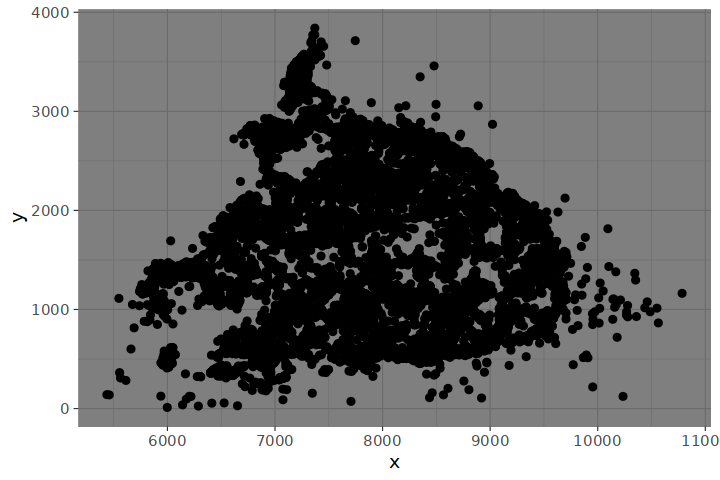

In [137]:
# plot subsampled - LAMA2 
# after cropping
options(repr.plot.height = 4, repr.plot.width = 6)
xy_coords_dfs.samples_clean$mb263.Xenium %>% filter(molecule == "LAMA2") %>% sample_frac(size = 0.1) %>% 
ggplot(aes(x, y)) & geom_point() & theme_dark()

In [146]:
# save as .csv data frames
for (i in seq(xy_coords_dfs.samples_clean))
data.table::fwrite(x = xy_coords_dfs.samples_clean[[i]], 
                   file = paste0("./07_Xen_MC_Merscope/", 
                                 names(xy_coords_dfs.samples_clean)[i], "_mols_coords.csv")
                  )
list.files("./07_Xen_MC_Merscope/")

[1] "mb263.w4a1.Resolve_mols_coords.csv" "mb263.Xenium_mols_coords.csv"      
 [3] "mb266.Vizgen_mols_coords.csv"       "mb266.w5a1.Resolve_mols_coords.csv"
 [5] "mb266.Xenium_mols_coords.csv"       "mb295.Vizgen_mols_coords.csv"      
 [7] "mb295.w6a1.Resolve_mols_coords.csv" "mb295.w6a2.Resolve_mols_coords.csv"
 [9] "mb295.Xenium_mols_coords.csv"       "mb299.w7a1.Resolve_mols_coords.csv"
[11] "mb299.Xenium_mols_coords.csv"

#### <span style="font-size:12pt; color:gold"> QCs </span>
<span style="font-size:10pt; color:tomato"> Sanity checks </span> 

##### <span style="font-size:11pt; color:tomato"> Sanity check on transcipt counts </span> <br /> 

In [ ]:
# quick check on transcipt counts
GetAssayData(obj, slot = "counts") %>% str
GetAssayData(obj, slot = "counts")@x %>% str
GetAssayData(obj, slot = "counts")@x %>% range # non-zero counts only, should start from 1.

# test count matrix 
mat_temp <- GetAssayData(obj, slot = "counts")[10:15, 1000:1010]

# total transcripts counts per gene across all cells
Matrix::rowSums(mat_temp) %>% cbind
# total cell counts per gene with transcripts counts > 0
Matrix::rowSums(mat_temp > 0) %>% cbind

# total transcripts counts per cell
Matrix::colSums(mat_temp) %>% cbind # nCount_*
# total gene counts (with transcripts counts > 0) per cell
Matrix::colSums(mat_temp > 0) %>% cbind # nFeature_Spatial ie genes per spot

# total counts per gene
Matrix::rowSums(GetAssayData(obj, slot = "counts")) %>% str 
Matrix::rowSums(GetAssayData(obj, slot = "counts")) %>% range # min and max of total counts

# nCount_* ie total transcript counts per cell
Matrix::colSums(GetAssayData(obj, slot = "counts")) %>% str 
Matrix::colSums(GetAssayData(obj, slot = "counts")) %>% range

# get top expressed genes
use.all.genes <- TRUE
if (!use.all.genes) {
    # use first `n` genes
    n.genes <- 10 # eg first 10 genes
} else {
    # use all genes
    n.genes <- rownames(obj) %>% length
}
top.genes <- Matrix::rowSums(GetAssayData(obj, slot = "counts")) %>% 
sort(decreasing = TRUE) %>% head(n = n.genes) %>% names
top.genes %>% head
# re-check
df.expr <- FetchData(obj, vars = top.genes, slot = "counts")
df.expr %>% str
# get total counts `sum()` for all cells
cbind(df.expr %>% names, sapply(df.expr %>% seq, function(i) df.expr[,i] %>% sum))

In [13]:
# Sanity check
nCount <- 
    grep("nCount", getMeta(obj) %>% names, 
         value = TRUE) %>% 
    grep("SCT", ., value = TRUE, invert = TRUE)
  if (any(obj[[nCount]] == 0)) {
      message(">>> filtering object - keeping cells with counts > 0")
    obj %<>% subset(subset = !!base::as.symbol(nCount) > 0)
  } else { message(">>> all counts are > 0") }

message("Checking raw counts per sample..")
meta.var <- "samples"
assay <- Assays(obj) %>% grep("SCT", ., value = TRUE, invert = TRUE)
DefaultAssay(obj) <- assay
slot <- "counts" # raw UMI counts
# examples -> [R sparse matrix](https://www.r-bloggers.com/2020/03/what-is-a-dgcmatrix-object-made-of-sparse-matrix-format-in-r/)
# obj[["RNA"]]@counts@x all matrix elements ate the non-zero values..
source("./scripts/subset_obj_seurat_v2.R")
out <- 
mclapply(seq(names(table(obj[[meta.var]]))), function(i) 
{ (subset_opt(obj, 
              cells = Cells(obj)[which(obj[[meta.var]][,] %in% names(table(obj[[meta.var]]))[i])]) %>% 
   GetAssayData(assay = assay, slot = slot))@x %>% range 
}, mc.cores = 20
        ) %>% suppressMessages
gc() %>% invisible() # collect garbage
#out <- do.call("rbind", out)
#rownames(out) <- names(table(obj[[meta.var]]))
names(out) <- names(table(obj[[meta.var]]))
out # range should start from 1 transcript count
# check if there are any samples with counts < 1 | !==2
out_checks <- c(lapply(seq(out), function(i)
    any(!range(out[[i]]) %% 1 == 0, !min(range(out[[i]])) == 1)) %>% unlist)
# print them
if (any(out_checks == TRUE)) {
    for (i in which(out_checks == TRUE))
    message(paste0(names(out)[i], ", "), 
            "raw counts start from: ", min(out[[i]]))
    stop("raw counts DO NOT start from: 1")
} else { message("all raw counts start from: ", 
                 c(lapply(seq(out), 
                          function(i) min(out[[i]])) %>% unlist %>% unique))
    }            


>>> all counts are > 0

Checking raw counts per sample..



$mb263.MC
[1]    1 1299

$mb263.Visium
[1]   1 171

$mb263.Xenium
[1]   1 618

$mb266.MC
[1]    1 1322

$mb266.MERFISH
[1]    1 1220

$mb266.Visium
[1]   1 125

$mb266.Xenium
[1]   1 766

$mb295.MC
[1]    1 1060

$mb295.MERFISH
[1]    1 1313

$mb295.Visium
[1]  1 39

$mb295.Xenium
[1]   1 867

$mb299.MC
[1]    1 1318

$mb299.Visium
[1]   1 137

$mb299.Xenium
[1]   1 718

all raw counts start from: 1



##### <span style="font-size:12pt; color:tomato"> QCs - *per cell* </span> <br /> 

In [ ]:
# if to add proportions/percentage expressed genes per cell - not needed here!
add.percent.genes <- TRUE
if (add.percent.genes) {
  # check mitochondrial, ribosomal, red-blood cell contamination, and background genes contents..
  gene.pattern <- c("^MT-", "^RP[SL]", 
                    "^HB[^(P)]", "^Blank-[0-9]|^FP [0-9]")                       
  col.name <- c("percent_mito", "percent_ribo",
                "percent_hb", "percent_bg")
  if (lapply(gene.pattern %>% seq, function(i) { 
      grep(pattern = gene.pattern[i], 
           x = rownames(obj), value = TRUE) %>% is.empty() }
             ) %>% unlist %>% any) {
      message("No genes are present for:", 
              paste0("\n", ">>> ", col.name))
  } else {
      # add to meta
      for (i in seq(gene.pattern)) {
          obj %<>% 
          PercentageFeatureSet(pattern = gene.pattern[i], 
                               col.name = col.name[i])
      }
      col.name.added <- 
          match.arg(names(getMeta(obj)), col.name, several.ok = TRUE)
      message("Added:", paste0("\n", ">>> ", col.name.added))
  }
    
  # add cell cycle scores ----
  # match genes present in the obj
  if (lapply(cc.genes %>% seq, function (i) 
      is.empty(which(rownames(obj) %in% cc.genes[[i]]))) %>% unlist %>% all) {
    message("Adding cell cycle scores..")
    obj %<>% CellCycleScoring(s.features = cc.genes$s.genes,
                              g2m.features = cc.genes$g2m.genes,
                              set.ident = FALSE)
    obj$cc.difference <- obj$S.Score - obj$G2M.Score  
  } else {
    message("Not enough cell cycle genes are present in the object", " \n",
            "cell cycle scores won't be calculated")
  }
  
  #obj %<>% UpdateSeuratObject()
}
             

In [12]:
# add zero to NaN?
# replace for NAs or NaNs in percent_* meta variables - add zeros
meta.vars <- grep("percent_", names(getMeta(obj)), value = TRUE)
if (!is.empty(meta.var)) {
    for (i in meta.vars %>% seq) {
    if (is.nan(obj[[meta.vars[i]]][[1]]) %>% any) {
        message("Adding zeros `0` to all `NaN` or `NA` values to: ", meta.vars[i])
        obj[[meta.vars[i]]][[1]][is.na(obj[[meta.vars[i]]][[1]])] <- 0L # add zero to NaN
    }
    }
}

#### <span style="font-size:12pt; color:tomato"> Set QC variables and plot params.. </span>
<span style="font-size:10pt; color:crimson"> NOTE: always run it! </span> <br /> 

In [19]:
# QC variables and plot params         
message("Setting QC variables and plot params..")
meta.vars <- grep("nCount_|nFeature_|percent_", names(getMeta(obj)), value = TRUE)
message("QC variables are :", paste0("\n", ">>> ", meta.vars))

# if TRUE - using whole obj name, else other metadata var.. 
meta.var.use <- c("orig.ident", "samples", "spatial_tech")
use.orig.ident <- FALSE
if (use.orig.ident) { meta.var <- "orig.ident" } else { meta.var <- "samples" }
#meta.var <- "spatial_tech"
meta.var

# add colors for meta var (ie samples) 
meta.var.col <- colorRampPalette(RColorBrewer::brewer.pal(10, "Paired"))(table(obj[[meta.var]]) %>%
 names %>% length)
meta.var.col %>% glimpse

# title for meta.var
#paste0(substring(meta.var, 1, 1) %>% toupper, substring(meta.var, 2, nchar(meta.var)))
meta.var.title <- stringr::str_to_title(meta.var)

# custom text sizes for plots
legend.text.size <- 16
base_size <- 18
axis.text.size <- 14
   
# choose plot theme, eg dark or white
use.dark.theme <- FALSE # if FALSE - white bg is used for plots

# choose plot colors scheme..
use.colors.opt <- "fire" # options are: "inferno" or "fire"
# colors/fill scale gradient
if (use.dark.theme && use.colors.opt == "fire") {
    scale.col <- 
        cet_pal(11, name = use.colors.opt)[4:11] %>% .[c(1,3,5,6:8)]
    low.col <- scale.col[1:3]
    high.col <- scale.col[4:6]
    theme2use <- theme_classic(base_size = base_size) %>% dark_mode
    axis.text.col <- "gray96"
    gam.line.col <- alpha("green1", 0.9)
    color.dens <- alpha("dodgerblue2", 0.9)
    message("Using Dark Theme & ", paste0("'", use.colors.opt, "'"), " color scale")
} else if (!use.dark.theme && use.colors.opt == "fire") {
    scale.col <-
        cet_pal(11, name = use.colors.opt)[1:9] %>% .[c(1,3,5,6,7,9)] %>% rev
    low.col <- scale.col[1:3]
    high.col <- scale.col[4:6]
    theme2use <- theme_classic(base_size = base_size)
    axis.text.col <- "gray4"
    gam.line.col <- alpha("green4", 0.7)
    color.dens <- alpha("dodgerblue2", 0.9)
    message("Using White Theme & ", paste0("'", use.colors.opt, "'"), " color scale")
} else if (use.dark.theme && use.colors.opt == "inferno") {
    scale.col <- 
        c(viridis::viridis(11, option = use.colors.opt))[3:11] %>% .[c(1,3,5,7:9)]
    low.col <- scale.col[1:3]
    high.col <- scale.col[4:6]
    theme2use <- theme_classic(base_size = base_size) %>% dark_mode
    axis.text.col <- "gray96"
    gam.line.col <- alpha("green1", 0.9)
    color.dens <- alpha("dodgerblue2", 0.9)
    message("Using Dark Theme & ", paste0("'", use.colors.opt, "'"), " color scale")
} else if (!use.dark.theme && use.colors.opt == "inferno") {
    scale.col <- 
        c(viridis::viridis(11, option = use.colors.opt))[3:11] %>% .[c(1,3,5,7:8)] %>% 
        rev %>% c("gray4")
    low.col <- scale.col[1:3]
    high.col <- scale.col[4:6]
    theme2use <- theme_classic(base_size = base_size)
    axis.text.col <- "gray4"
    gam.line.col <- alpha("green4", 0.7)
    color.dens <- alpha("dodgerblue2", 0.9)
    message("Using White Theme & ", paste0("'", use.colors.opt, "'"), " color scale")
}

# transparent theme for white bg
theme_transparent_2 <- theme(panel.background = element_rect(fill = "transparent"),
                             plot.background = element_rect(fill = "transparent", color = NA),
                             panel.grid.major = element_blank(), 
                             panel.grid.minor = element_blank(), 
                             legend.background = element_rect(fill = "transparent"))


Setting QC variables and plot params..

QC variables are :
>>> nCount_MultiTech
>>> nFeature_MultiTech



[1] "samples"

 chr [1:14] "#A6CEE3" "#4892C2" "#579FA3" "#A8DA82" "#50AE41" "#8F9D5E" ...


Using White Theme & 'fire' color scale



#### <span style="font-size:12pt; color:gold"> QCs - *per cell* </span>
<span style="font-size:10pt; color:tomato"> Prepara data for plots - *cells* </span> <br /> 

In [20]:
# subset object metadata with selected vars..
df.data <- 
    getMeta(obj) %>%
    select(all_of(c(meta.vars, meta.var.use))) %>%
    # merge MB285, update 10X namings
    mutate(samples = stringi::stri_replace_all_regex(samples, 
                                pattern = "region[0-1].|w(.)[^:][0-9].", 
                                replacement = ""))

# check if percent_* metavars exist in the object
if (!any(grep("percent_", names(df.data)))) {
  message("`percent_*` metavars are not present..", "\n", 
          "consider running `PercentageFeatureSet()` ")
} else {  
  message("Already present:", 
          paste0("\n", ">>> ", grep("percent_", names(df.data), value = TRUE)))
  # add log10 scale to percent_*
  add.logs <- TRUE # if TRUE, will. calculate log10(x + 1)
  if (add.logs) {
    df.id <- grep("percent_", names(df.data))
    for (i in df.id %>% length %>% seq) {
      if (!any(paste0(names(df.data[df.id[i]]), ".", "log10_1p") == names(df.data))) {
        if (any(df.data[[df.id[i]]] == 0)) {
          # convert and add pseudocount  
          df.data[[paste0(names(df.data[df.id[i]]), ".", "log10_1p")]] <- log10(df.data[[df.id[i]]] + 1)
        } else { df.data[[paste0(names(df.data[df.id[i]]), ".", "log10_1p")]] <- log10(df.data[[df.id[i]]]) }
      }
    }
  }
}

## for spatial_tech and samples
# bring same samples together
samples.merge <- 
    df.data %>% 
    pull(samples) %>% 
    unique #%>% 
    #gsub("mb", x = ., "")
# start with mb263 and mb299
# order snRNA-seq, Visium, RNAscope, MC, MERFISH and Xenium
samples.merge <- 
    list(
samples.merge %>% 
    #unique %>% 
    rev %>%
    grep("263", ., value = TRUE) %>% .[c(2,3,1)],
samples.merge %>% 
    #unique %>% 
    rev %>%
    grep("299", ., value = TRUE) %>% .[c(2,3,1)],

samples.merge %>% 
    #unique %>% 
    rev %>%
    grep("263|299", ., value = TRUE, invert = TRUE) %>%
    grep("266", ., value = T) %>% .[c(2,3,4,1)],

samples.merge %>% 
    #unique %>% 
    rev %>%
    grep("263|299", ., value = TRUE, invert = TRUE) %>%
    grep("295", ., value = TRUE) %>% .[c(2,3,4,1)]

) %>% unlist
samples.merge %>% str
samples.merge

df.data %<>% 
    #..sample names as factors
    mutate(samples = 
           factor(samples, levels = 
                  samples.merge %>% unique),
           #..spatial techs as factors
           spatial_tech = factor(spatial_tech, levels = 
                                 spatial_tech %>% 
                                 unique %>% rev)) %>%
    # add total cell number per sample
    group_by(samples) %>%
    group_split() %>%
    purrr::map(., ~ mutate(., nBin.samples = summarize(., n.bins = n()) %>% 
                           pull(n.bins))) %>% 
    data.table::rbindlist(.)
df.data %>% str

# re-set QC variables adding percent_* at log scale
if (any(grep(".log", names(df.data)))) {
    meta.vars.df <- unique(c(meta.vars, grep("nCount_|nFeature_|percent_|nBin", names(df.data), value = TRUE)))
    message("Re-set QC variables", "\n",  "New QC variables are:", paste0("\n", ">>> ", meta.vars.df))
} else { meta.vars.df <- unique(c(meta.vars, grep("nCount_|nFeature_|nBin", names(df.data), value = TRUE))) }

# generate breaks and limits for color scale
# examples -> [biscale breaks](https://cran.r-project.org/web/packages/biscale/vignettes/breaks.html) 
#[lemon legends](https://cran.r-project.org/web/packages/biscale/vignettes/breaks.html)
n.pretty <- 40
breaks.col <- 
lapply(seq(meta.vars.df),
       function(i) { 
           classInt::classIntervals(c(min(df.data[[meta.vars.df[i]]][!is.na(df.data[[meta.vars.df[i]]])]), 
                                      pretty(df.data[[meta.vars.df[i]]][!is.na(df.data[[meta.vars.df[i]]])], n = n.pretty)[-1] %>% 
                                      sort %>% unique),
                                    n = 2, style = "quantile")$brks %>% ceiling %>% unique }
      )
breaks.col  

adjust.logs <- TRUE # if TRUE, will adjust values for log10 only
if (adjust.logs && exists("add.logs")) {
  if (any(grep("log10", meta.vars.df))) {
    for (j in grep("log10", meta.vars.df)) {
      breaks.col[[j]] <- 
        classInt::classIntervals(c(min(df.data[[meta.vars.df[j]]][!is.na(df.data[[meta.vars.df[j]]])]), 
                                   pretty(df.data[[meta.vars.df[j]]][!is.na(df.data[[meta.vars.df[j]]])], n = n.pretty)[-1] %>% 
                                     sort %>% unique), 
                                 n = 2, style = "quantile")$brks %>% round(digits = 2) %>% unique 
    }
  }
  breaks.col
}

# round breaks.col and add K to breaks.col.label for large values > 1000
breaks.col.label <- breaks.col 
breaks.col.label <- 
lapply(breaks.col.label, function(i) 
    scales::number(i, 
               scale_cut = scales::cut_long_scale()))
#for (i in seq(breaks.col)) {
#    if (isFALSE(length(lapply(seq(breaks.col), function(i) which(breaks.col[[i]] >= 1000))[[i]]) == 0))
#        { breaks.col.label[[i]] <- c(breaks.col[[i]][which(breaks.col[[i]] < 1000)] %>% round(),
#                                     paste0(c(breaks.col[[i]][which(breaks.col[[i]] >= 1000)] / 1000) %>% 
#                                            round(digits = 1), "K"))
#        } else { breaks.col.label[[i]] %<>% as.character }
#}                                                       
breaks.col.label
                              
# fuse log and non-log scaled values
if (exists("add.logs")) {
  for (i in grep(".log", meta.vars.df)) {
    # add 0(1), ie log scale(real value)
    #breaks.col.label[[i]][1] <- paste0(breaks.col.label[[i]][1], "(", 1, ")")
    
    if (any(10^breaks.col[[i]] >= 1000 & !10^breaks.col[[i]] >= 1e6)) {
      breaks.col.label[[i]][which(10^breaks.col[[i]] >= 1000 & !10^breaks.col[[i]] >= 1e6)] <- 
        paste0(breaks.col.label[[i]][which(10^breaks.col[[i]] >= 1000 & !10^breaks.col[[i]] >= 1e6)], "(", 
               paste0(c(10^breaks.col[[i]][which(10^breaks.col[[i]] >= 1000 & !10^breaks.col[[i]] >= 1e6)] / 1000) %>% 
                        round(digits = 1), "K"), ")") 
    }
    if (any(10^breaks.col[[i]] >= 1e6)) 
    { breaks.col.label[[i]][which(10^breaks.col[[i]] >= 1e6)] <- 
      paste0(breaks.col[[i]][which(10^breaks.col[[i]] >= 1e6)], "(", 
             paste0(c(10^breaks.col[[i]][which(10^breaks.col[[i]] >= 1e6)] / 1e6) %>% 
                      round(digits = 1), "M"), ")")
    } else if (any(10^breaks.col[[i]] < 1000)) { 
      breaks.col.label[[i]][which(10^breaks.col[[i]] < 1000)] <- 
        paste0(breaks.col.label[[i]][which(10^breaks.col[[i]] < 1000)], "(", 
               10^breaks.col[[i]][which(10^breaks.col[[i]] < 1000)] %>% ceiling, ")") 
    }
  }
}
breaks.col.label
                              
# add limits
limits <- lapply(seq(meta.vars.df), function(i) 
    #c(min(breaks.col[[i]]), max(breaks.col[[i]]))
    range(breaks.col[[i]])
                 )
limits

message("Calculating summary stats - median")
# median values per sample
df.data.filt <- 
df.data %>%
dplyr::group_by_at(meta.var) %>% 
summarize_if(is.numeric, ~ median(.) %>% round(digits = 0), na.rm = TRUE)
df.data.filt

message("Calculating summary stats - sd")
# sd or variance values per sample
df.data %>%
dplyr::group_by_at(meta.var) %>% 
summarise_if(is.numeric, ~ sd(.) %>% round(digits = 0), na.rm = TRUE)
                 
message("..using metadata variable - ", meta.var,
       if (use.dark.theme) { 
           "\n..using Dark Theme" }
       else { "\n..using White Theme" } , "\n",
        paste0("'", use.colors.opt, "'"), " color scale")
                              

`percent_*` metavars are not present..
consider running `PercentageFeatureSet()` 



 chr [1:14] "mb263.Visium" "mb263.MC" "mb263.Xenium" "mb299.Visium" ...


[1] "mb263.Visium"  "mb263.MC"      "mb263.Xenium"  "mb299.Visium" 
 [5] "mb299.MC"      "mb299.Xenium"  "mb266.Visium"  "mb266.MC"     
 [9] "mb266.MERFISH" "mb266.Xenium"  "mb295.Visium"  "mb295.MC"     
[13] "mb295.MERFISH" "mb295.Xenium"

Classes ‘data.table’ and 'data.frame':	70769 obs. of  6 variables:
 $ nCount_MultiTech  : num  24 33 49 56 85 35 61 48 84 29 ...
 $ nFeature_MultiTech: int  10 18 19 25 17 14 20 20 18 19 ...
 $ orig.ident        : chr  "mb263_d.Visium" "mb263_d.Visium" "mb263_d.Visium" "mb263_d.Visium" ...
 $ samples           : Factor w/ 14 levels "mb263.Visium",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ spatial_tech      : Factor w/ 4 levels "Xenium","Visium",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ nBin.samples      : int  1974 1974 1974 1974 1974 1974 1974 1974 1974 1974 ...
 - attr(*, ".internal.selfref")=<externalptr> 


[[1]]
[1]    1 3100 6200

[[2]]
[1]  1 48 96

[[3]]
[1]  1075  8250 15500

[[1]]
[1] "1"    "3.1K" "6.2K"

[[2]]
[1] "1"  "48" "96"

[[3]]
[1] "1.1K"  "8.2K"  "15.5K"

[[1]]
[1] "1"    "3.1K" "6.2K"

[[2]]
[1] "1"  "48" "96"

[[3]]
[1] "1.1K"  "8.2K"  "15.5K"

[[1]]
[1]    1 6200

[[2]]
[1]  1 96

[[3]]
[1]  1075 15500

Calculating summary stats - median



samples       nCount_MultiTech nFeature_MultiTech nBin.samples
1  mb263.Visium    38             15                  1974       
2  mb263.MC      1684             60                  1555       
3  mb263.Xenium   684             63                  6202       
4  mb299.Visium    28             15                  2653       
5  mb299.MC      2575             63                  1075       
6  mb299.Xenium   958             67                 15232       
7  mb266.Visium    26             14                  2777       
8  mb266.MC      1964             63                  1700       
9  mb266.MERFISH 1428             79                  5194       
10 mb266.Xenium   974             64                 11859       
11 mb295.Visium    35             16                  2484       
12 mb295.MC      3006             63                  1892       
13 mb295.MERFISH 1218             72                  5195       
14 mb295.Xenium  1049             68                 10977

Calculating summary stats - sd



samples       nCount_MultiTech nFeature_MultiTech nBin.samples
1  mb263.Visium    29              4                 0           
2  mb263.MC       783             10                 0           
3  mb263.Xenium   800             27                 0           
4  mb299.Visium    19              5                 0           
5  mb299.MC       941              8                 0           
6  mb299.Xenium   796             28                 0           
7  mb266.Visium    15              5                 0           
8  mb266.MC       901             11                 0           
9  mb266.MERFISH 1063             23                 0           
10 mb266.Xenium   765             25                 0           
11 mb295.Visium    16              5                 0           
12 mb295.MC       993              9                 0           
13 mb295.MERFISH 1091             24                 0           
14 mb295.Xenium  1100             31                 0

..using metadata variable - samples
..using White Theme
'fire' color scale



<span style="font-size:12pt; color:tomato"> Generate density plots - *cells* </span> <br />
<span style="font-size:10pt; color:steelblue">..density colors are number of cells per sample! </span> <br /> 

In [69]:
# Density colors are number of cells per sample!
# added QC variables for percent_* at log10 (+ pseudocount if any zeros) scale
message("Generate density plots per meta variable: ", meta.var, "\n",  
        "New QC variables are:", paste0("\n", ">>> ", meta.vars.df))

# ..legend/title for meta vars
meta.vars.legend <- gsub(pattern = paste0("_", Assays(obj) %>% 
                                              grep("SCT", ., 
                                                   value = TRUE, 
                                                   invert = TRUE)), 
                         replacement = "", meta.vars.df)
meta.vars.legend <-
c(grep("^n", meta.vars.legend, value = TRUE), 
  gsub(pattern = "percent_", replacement = "", grep("percent_", meta.vars.legend, value = TRUE)) %>%
  stringr::str_to_title() %>% paste0(". content (%)"))
# adjust for log meta vars
if (any(grep(".log", meta.vars.legend))) { 
    for (i in grep("log", meta.vars.legend)) { 
        meta.vars.legend[i] <- 
        gsub(pattern = ". content|[(%)]", replacement = "", meta.vars.legend[i]) %>% 
        paste0("(%) content")
    }
}

# for stat_density_ridges
scale.param <- c(rep(0.9, length(meta.vars.df)))

# for geom_text_repel label
# NOTE: custom labels, need to be optimized then added samples or vars
nudge_x <- c(2200, 16, 50, 14, 8)
nudge_y <- c(0.6, 0.6, 0.5, 0.5, 0.6)

# breaks for total samples per cell
breaks.label.samples <- 
    scales::number(df.data$nBin.samples %>% unique %>% sort, accuracy = 0.1, 
                   scale_cut = scales::cut_long_scale())

# function to check if any meta vars have logs
check.if.log <- function(x) { grep(".log", meta.vars.df[x]) }

# generate plots
set.seed(47654)
pl1 <- lapply(seq(meta.vars.df)[-5], # irnoge the last var
              function(i) df.data %>%
              ggplot(aes_string(x = meta.vars.df[i], y = meta.var, fill = "factor(nBin.samples)")) &
              stat_density_ridges(geom = "density_ridges_gradient", 
                                  quantile_lines = TRUE, 
                                  quantile_fun = function(x, ...) 
                                      { median(x) %>% round(digits = 0) }, # add median value
                                  #bandwidth = c(280, 3)[i],
                                  scale = scale.param[i],
                                  aes_string(point_fill = "nBin.samples", 
                                             point_color = "nBin.samples"),
                                  point_size = 0.05,
                                  point_shape = 19, point_alpha = 1,
                                  to = c(5000, 100, 900, 100)[i],
                                  color = color.dens %>% alpha(0), 
                                  #size = 0.1, linetype = "solid",
                                  jittered_points = FALSE, # to hide points -> set to FALSE 
                                  position = position_raincloud(height = 0.1)
                                 ) & 
              # add ticks
              { if (any(check.if.log(i))) {
                  annotation_logticks(color = axis.text.col, sides = "b") 
              }} &
              #scale_x_continuous(limits = limits[[i]], 
              #                   breaks = if (!any(check.if.log(i))) { breaks.col[[i]] } else { waiver() },
              #                   labels = if (!any(check.if.log(i))) { breaks.col.label[[i]] } else { waiver() }
              #                   ) &
              #scale_point_color_gradient(low = low.col,
              #                           high = high.col,
              #                           limits = limits[[5]], 
              #                           breaks = if (!any(check.if.log(i))) { breaks.col[[5]] } else { waiver() },
              #                           labels = if (!any(check.if.log(i))) { breaks.col.label[[5]] } else { waiver() }
              #                          ) &
              scale_fill_manual(name = c("Total Bins"), 
                                labels = breaks.label.samples,
                                values = cet_pal(20, name = use.colors.opt)[-2]) &
              theme2use &
              theme(legend.text = element_text(size = legend.text.size),
                    axis.text = element_text(color = axis.text.col, size = axis.text.size),
                    legend.position = "right",
                    legend.key.height = grid::unit(0.5,"cm"),
                    legend.key.width = grid::unit(0.8, "cm")) & 
              labs(title = meta.vars.legend[i],
                   #subtitle = rep("per Bin (48.7µm)", meta.vars.df %>% length)[i],
                   subtitle = rep(paste0("per Bin (", floor(48.74 ^ 2), " µm^2)"), meta.vars.df %>% length)[i],
                   x = NULL, y = NULL, fill = NA) &
              ggrepel::geom_text_repel(data = df.data.filt, # add pre-calculated median line and value
                                       aes_string(x = meta.vars.df[i], 
                                                  y = meta.var, 
                                                  label = meta.vars.df[i]),
                                       size = 5, nudge_x = nudge_x[i], nudge_y = nudge_y[i],
                                       color = color.dens,
                                       box.padding = 0.2,
                                       segment.curvature = -0.2,
                                       segment.linetype = 2,
                                       #max.overlaps = Inf,
                                       segment.ncp = 4,
                                       segment.angle = 20,
                                       fontface = "bold"
                                      )
             )

Generate density plots per meta variable: samples
New QC variables are:
>>> nCount_MultiTech
>>> nFeature_MultiTech
>>> nBin.samples



Picking joint bandwidth of 113



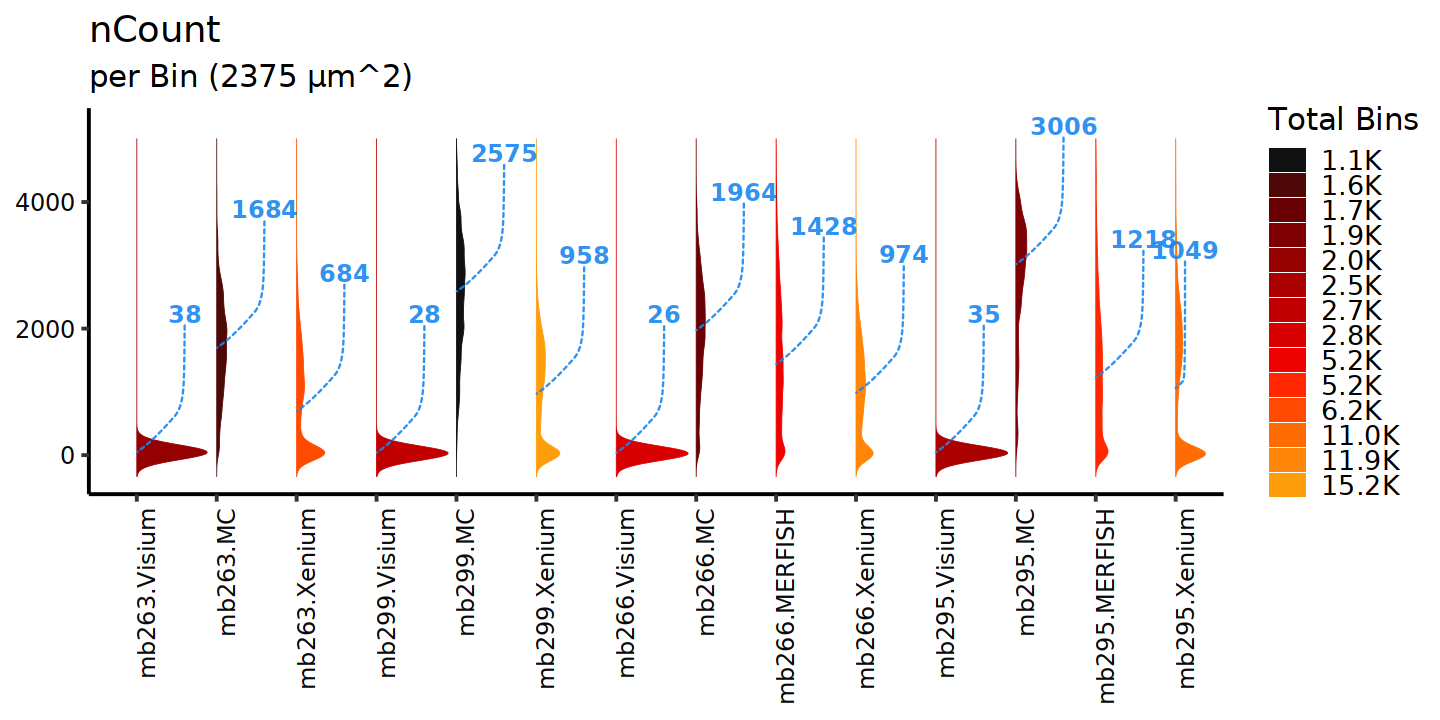

In [70]:
options(repr.plot.height = 6, repr.plot.width = 12)
i <- 1
pl1[[i]] & 
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1),
          plot.background = element_rect(fill = "white", color = "white")
         ) &
    coord_flip()

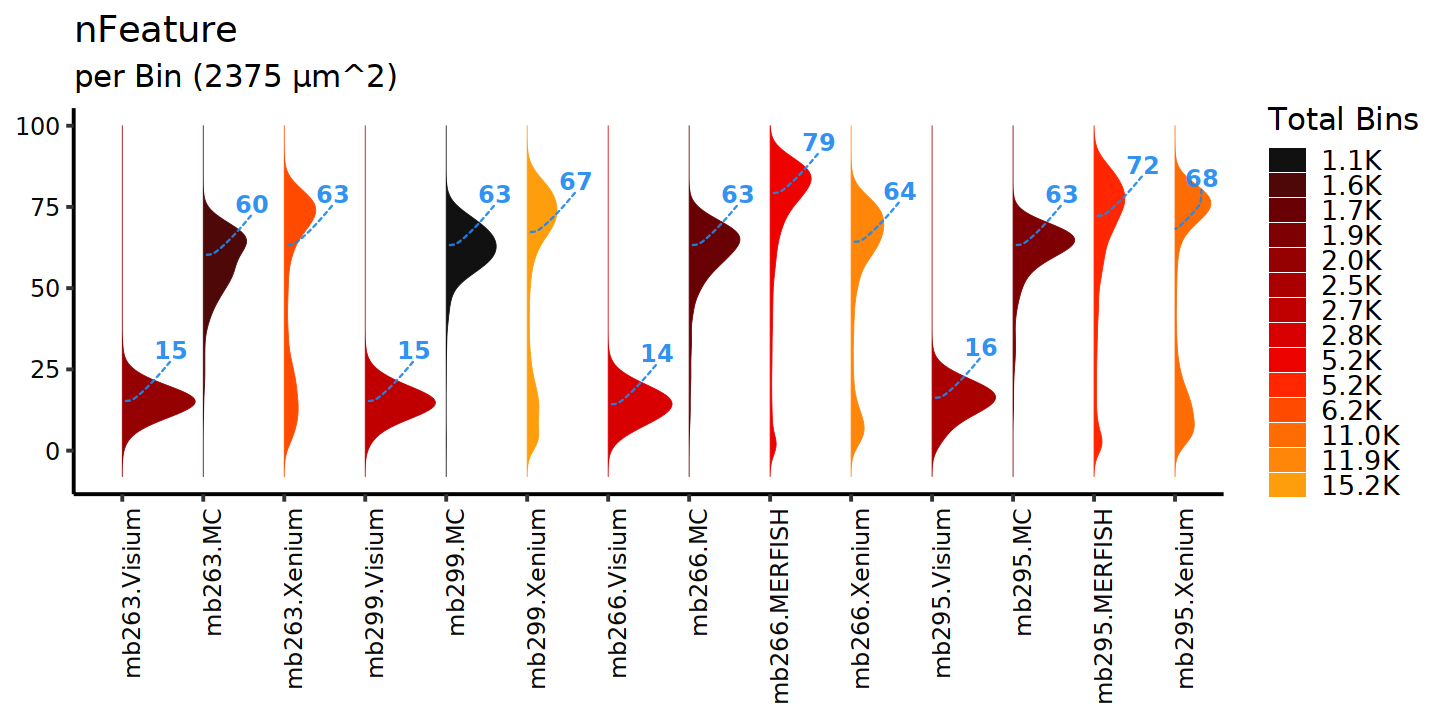

In [203]:
options(repr.plot.height = 6, repr.plot.width = 12)
i <- 2
pl1[[i]] & 
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1),
          plot.background = element_rect(fill = "white", color = "white")
         ) &
    coord_flip()

In [43]:
# plot all samples - transcript counts per bin
pl_all <- 
lapply(seq(Images(obj)), function(i) {
    ImageFeaturePlot(obj,
                 fov = Images(obj)[i],
                 features = "nCount_MultiTech",     
                 size = 0.3,
                 border.size = NA,
                 #border.color = alpha("blue1", 0.3),
                 boundaries = "centroids",
                 #scale = "none",    
                 alpha = 0.7,
                 axes = TRUE,
                 combine = TRUE) & ggtitle(Images(obj)[i])
    })

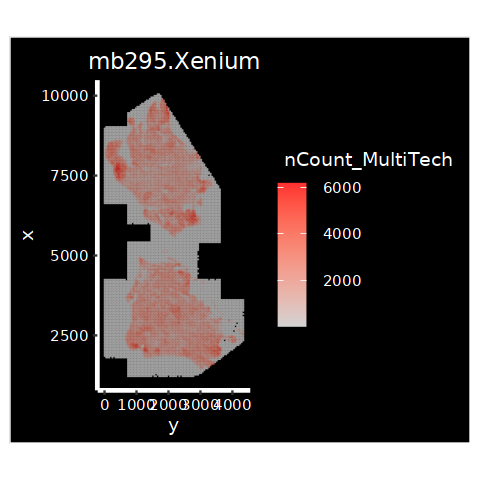

In [45]:
options(repr.plot.height = 4, repr.plot.width = 4)
pl_all[[14]]

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


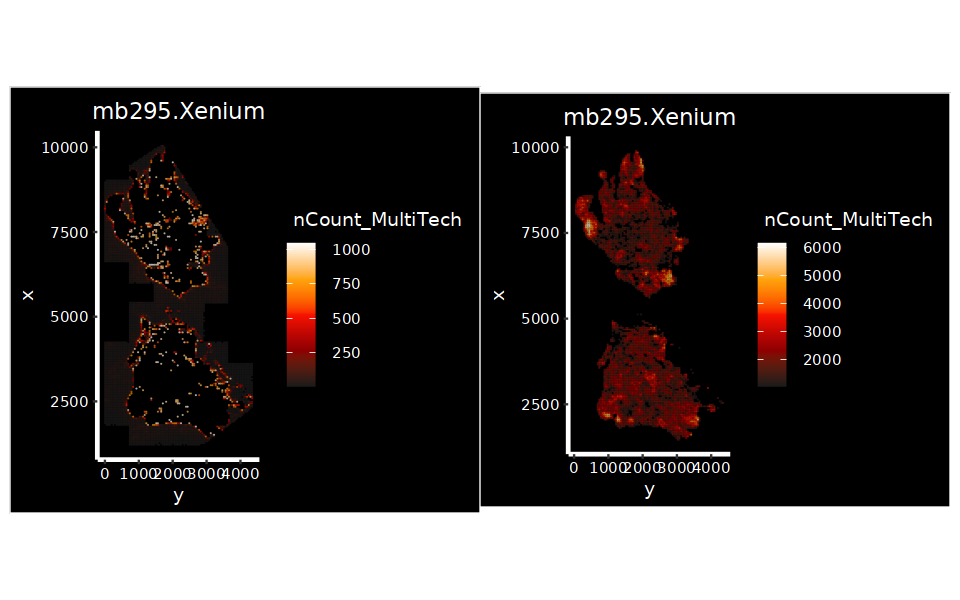

In [60]:
# check the bimodal count and gene count pattern for mb295
# mb295
pl_mb295_1 <- pl_mb295_2 <- pl_all[[14]]
# filter counts given the median or center that splits distributions
pl_mb295_1$data %<>% filter(nCount_MultiTech < 1050)
pl_mb295_2$data %<>% filter(nCount_MultiTech > 1050)
pl_mb295 <- list(pl_mb295_1, pl_mb295_2)
pl_mb295 <- 
    lapply(pl_mb295, function(i) {
    i$data %<>% arrange(nCount_MultiTech) # sort in increasing/ascending pattern
    i <- i & scale_fill_gradientn(colours = c("gray10", cet_pal(5, name = "fire")[-1]))   
    return(i)
    })
# plot them
options(repr.plot.height = 5, repr.plot.width = 8)
wrap_plots(pl_mb295, ncol = 2) 

Picking joint bandwidth of 113

Picking joint bandwidth of 2.15

Picking joint bandwidth of 5.29

Picking joint bandwidth of 0.841



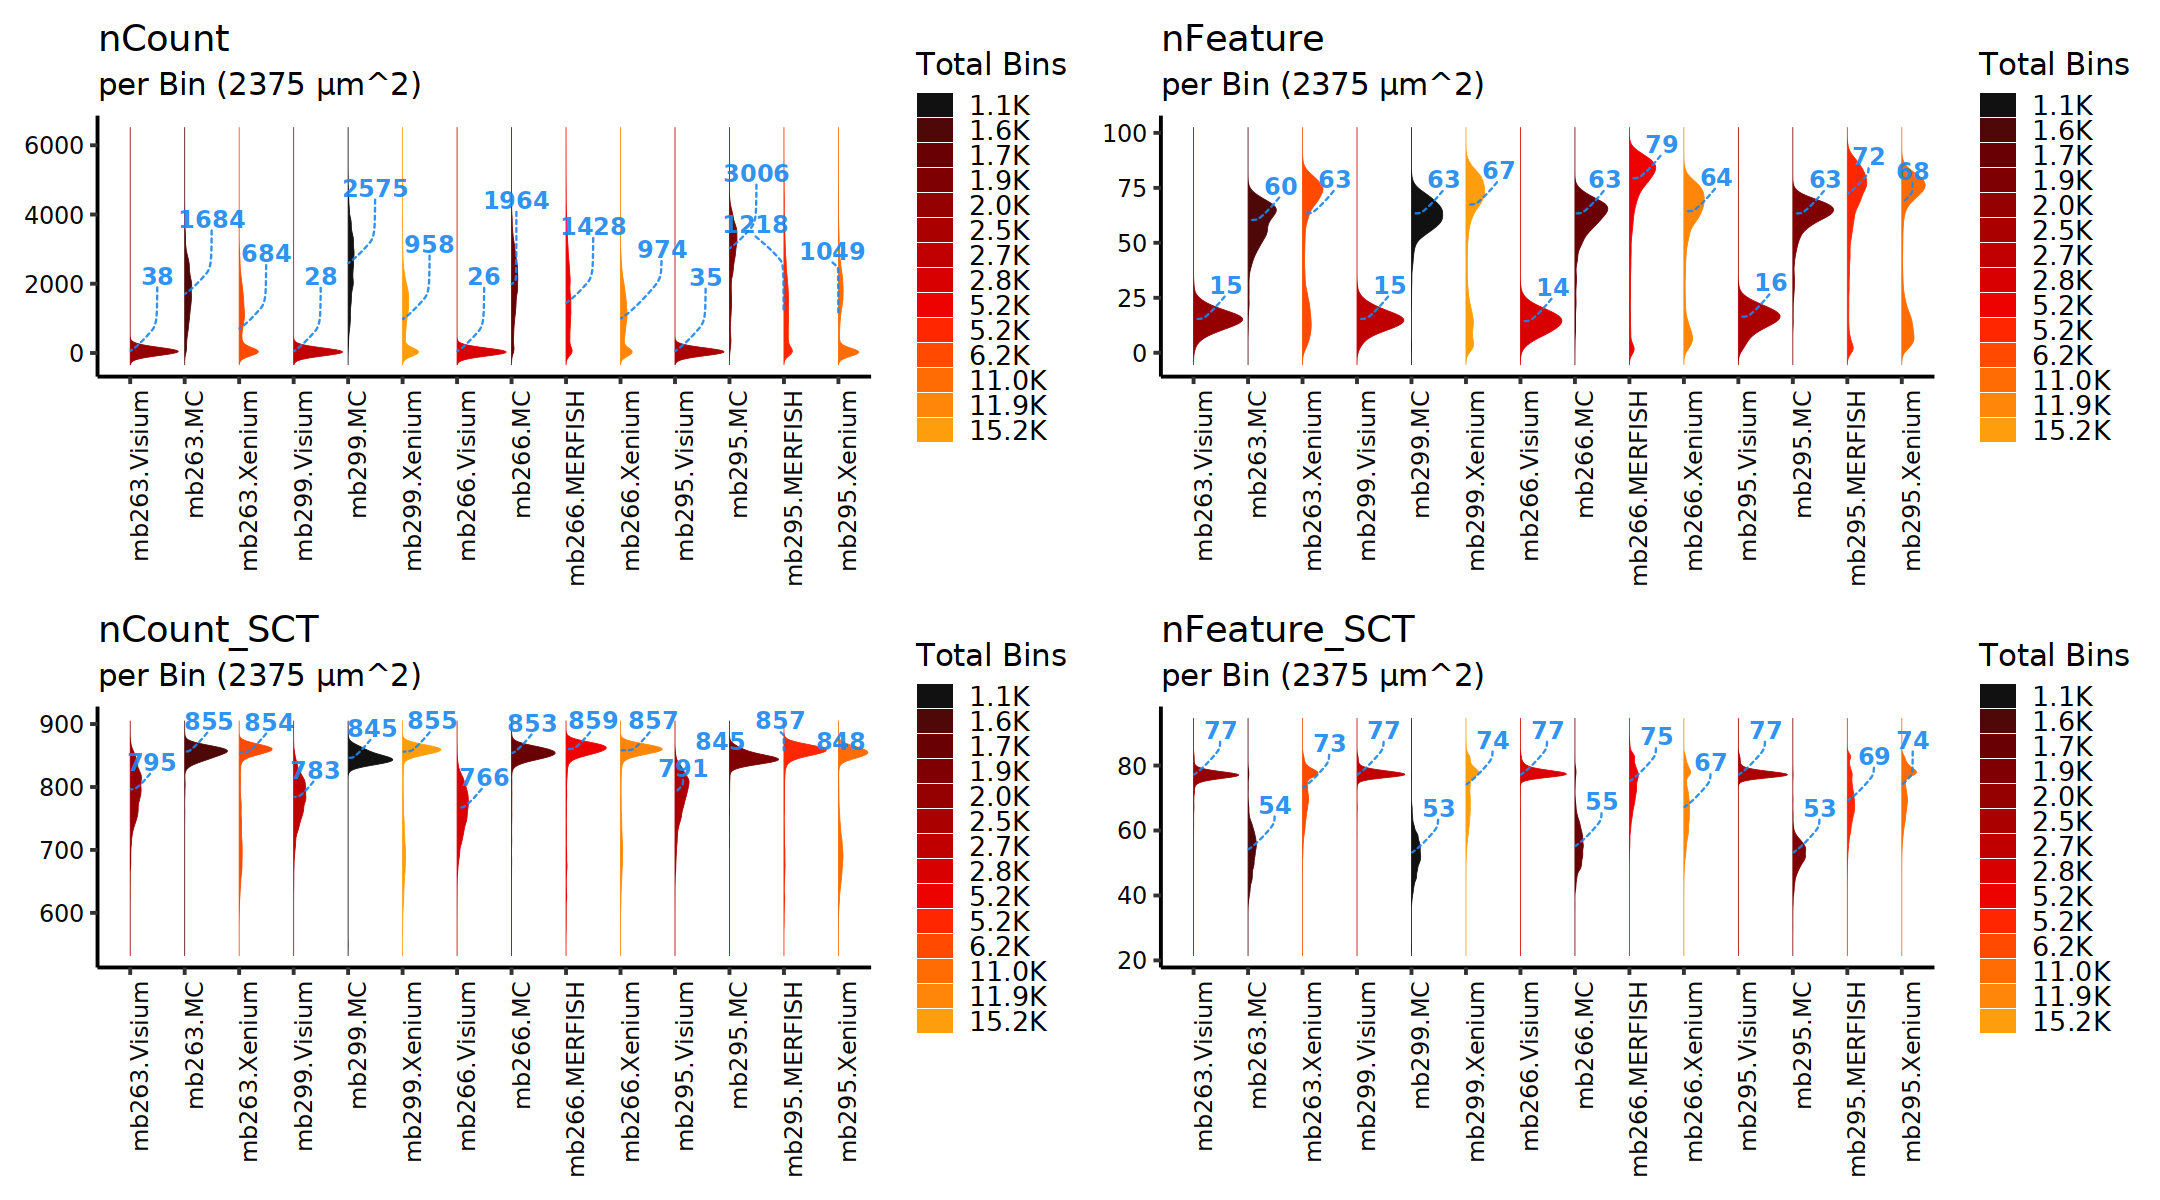

In [92]:
# plot them
options(repr.plot.height = 10, repr.plot.width = 18)
if (use.dark.theme) {
    pl1 %>% wrap_plots(ncol = 2) & 
    { theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1),
            plot.background = element_rect(fill = "black", color = "black"))
    } & coord_flip() 
    } else {
    pl1 %>% wrap_plots(ncol = 2)  &
    { theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1),
            plot.background = element_rect(fill = "white", color = "white"))
    }} & coord_flip() 


##### <span style="font-size:12pt; color:tomato"> Generate density plots - *cells* (old, optional) </span>

In [156]:
# added QC variables for percent_* at log10 (+ pseudocount if any zeros) scale
message("Generate density plots per meta variable: ", meta.var, "\n",  
        "New QC variables are:", paste0("\n", ">>> ", meta.vars.df))

# ..legend/title for meta vars
meta.vars.legend <- gsub(pattern = paste0("_", Assays(obj) %>% 
                                              grep("SCT", ., 
                                                   value = TRUE, 
                                                   invert = TRUE)), 
                         replacement = "", meta.vars.df)
meta.vars.legend <-
c(grep("^n", meta.vars.legend, value = TRUE), 
  gsub(pattern = "percent_", replacement = "", grep("percent_", meta.vars.legend, value = TRUE)) %>%
  stringr::str_to_title() %>% paste0(". content (%)"))
# adjust for log meta vars
if (any(grep(".log", meta.vars.legend))) { 
    for (i in grep("log", meta.vars.legend)) { 
        meta.vars.legend[i] <- 
        gsub(pattern = ". content|[(%)]", replacement = "", meta.vars.legend[i]) %>% 
        paste0("(%) content")
    }
}


# for stat_density_ridges
scale.param <- c(rep(0.80, length(meta.vars.df)))

# for geom_text_repel label
# NOTE: custom labels, need to be optimized then added samples or vars
nudge_x <- c(1300, 15, 50, 14, 8)
nudge_y <- c(0.45, 0.6, 0.5, 0.5, 0.6)

# sanity check on plot params
if (!length(nudge_x) == length(meta.vars.df) && 
   !length(nudge_y) == length(meta.vars.df)) {
    stop("meta vars and other plot params should have the same length!")
}

# function to check if any meta vars have logs
check.if.log <- function(x) { grep(".log", meta.vars.df[x]) }

# generate plots
set.seed(47654)
pl1 <- lapply(seq(meta.vars.df)[-5], function(i) df.data %>%
              ggplot(aes_string(x = meta.vars.df[i], y = meta.var, fill = "after_stat(..x..)")) &
              stat_density_ridges(geom = "density_ridges_gradient", 
                                  quantile_lines = TRUE, 
                                  quantile_fun = function(x, ...) { median(x) %>% round(digits = 0) }, # add median value
                                  bandwidth = NULL,
                                  scale = scale.param[i],
                                  aes_string(point_fill = "after_stat(..x..)", 
                                             point_color = "after_stat(..x..)"),
                                  point_size = 0.05,
                                  point_shape = 19, point_alpha = 1,
                                  to = df.data %>% 
                                      pull(meta.vars.df[i]) %>% 
                                      max(na.rm = TRUE) %>% 
                                      round(digits = 1),
                                  color = color.dens %>% alpha(0), 
                                  #size = 0.1, linetype = "solid",
                                  jittered_points = TRUE, # to hide points -> set to FALSE 
                                  position = position_raincloud(height = 0.1)
                                 ) & 
              # add ticks
              { if (any(check.if.log(i))) {
                  annotation_logticks(color = axis.text.col, sides = "b") 
              }} &
              scale_x_continuous(limits = limits[[i]], 
                                 breaks = if (!any(check.if.log(i))) { breaks.col[[i]] } else { waiver() },
                                 labels = if (!any(check.if.log(i))) { breaks.col.label[[i]] } else { waiver() }
                                 ) &
              scale_point_color_gradient(low = low.col,
                                         high = high.col,
                                         limits = limits[[i]], 
                                         breaks = if (!any(check.if.log(i))) { breaks.col[[i]] } else { waiver() },
                                         labels = if (!any(check.if.log(i))) { breaks.col.label[[i]] } else { waiver() }
                                        ) &
              scale_fill_gradient(name = NULL, 
                                  low = low.col,
                                  high = high.col,
                                  limits = limits[[i]],
                                  breaks = if (!any(check.if.log(i))) { breaks.col[[i]] } else { waiver() },
                                  labels = if (!any(check.if.log(i))) { breaks.col.label[[i]] } else { waiver() }
                                 ) &
              theme2use &
              theme(legend.text = element_text(size = legend.text.size),
                    axis.text = element_text(color = axis.text.col, size = axis.text.size),
                    legend.position = "right",
                    legend.key.height = grid::unit(1.2,"cm"),
                    legend.key.width = grid::unit(0.4,"cm")) & 
              labs(title = meta.vars.legend[i],
                   subtitle = rep("per Bin (48.7µm)", meta.vars.df %>% length)[i],
                   x = NULL, y = NULL, fill = NA) &
              ggrepel::geom_text_repel(data = 
                                       df.data.filt, # add pre-calculated median line and value
                                       aes_string(x = meta.vars.df[i], 
                                                  y = meta.var, 
                                                  label = meta.vars.df[i]),
                                       size = 5, nudge_x = nudge_x[i], nudge_y = nudge_y[i],
                                       color = color.dens,
                                       box.padding = 0.2,
                                       segment.curvature = -0.2,
                                       segment.linetype = 2,
                                       #max.overlaps = Inf,
                                       segment.ncp = 4,
                                       segment.angle = 20,
                                       fontface = "bold"
                                      )
             )


Generate density plots per meta variable: samples
New QC variables are:
>>> nCount_VizResVis
>>> nFeature_VizResVis
>>> nCount_SCT
>>> nFeature_SCT
>>> nBin.samples



In [ ]:
options(repr.plot.height = 5, repr.plot.width = 10)
i <- 1
pl1[[i]] & 
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1),
          plot.background = element_rect(fill = "white", color = "white")
         ) &
    coord_flip()

In [ ]:
# plot them
options(repr.plot.height = 10, repr.plot.width = 18)
if (use.dark.theme) {
    pl1 %>% wrap_plots(ncol = 2) & 
    { theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1),
            plot.background = element_rect(fill = "black", color = "black"))
    } & coord_flip() 
    } else {
    pl1 %>% wrap_plots(ncol = 2)  &
    { theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1),
            plot.background = element_rect(fill = "white", color = "white"))
    }} & coord_flip() 


##### <span style="font-size:12pt; color:gold"> Save QC plots - per meta variable</span>
<span style="font-size:11pt; color:tomato"> ..density plots - *cells* </span> <br /> 

In [204]:
## save plots
dir_path <- "./fig3/panel_B/"
if (FALSE) { # set to TRUE to save .png as well
  #.png
  message("..saving plots - `.png`")  
  mclapply(pl1 %>% seq, function(i) {
    ggsave({ if (use.dark.theme) { 
      pl1[[i]] & 
        theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1),
              plot.background = element_rect(fill = "black", 
                                             color = "black")) & 
        coord_flip()
    } else { pl1[[i]] & 
        theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1),
              plot.background = element_rect(fill = "white", color = "white")) & 
        coord_flip() }
    },
    file = paste0(dir_path, "mben.", meta.vars.df, "_bins_white", ".png")[i], 
    device = "png",
    #bg = "transparent",
    height = 6, width = 12, dpi = 200)
  }, mc.cores = mc.cores) %>% invisible
  } 

#.pdf
message("..saving plots - `.pdf`")  
mclapply(pl1[1:2] %>% seq, function(i) { # first 2 plots only
    ggsave({ if (use.dark.theme) { 
        pl1[[i]] & 
        theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1),
              plot.background = element_rect(fill = "black", 
                                             color = "black")) & 
        coord_flip()
    } else { pl1[[i]] & 
            theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1),
                 plot.background = element_rect(fill = "white", color = "white")) & 
            coord_flip() }
            },
           file = paste0(dir_path, "mben.", meta.vars.df, "_bins_white", ".pdf")[i], 
           device = cairo_pdf,
           #bg = "transparent",
           height = 6, width = 12, dpi = 200)
}, mc.cores = mc.cores) %>% invisible

dev.off()
message("..saving plots - done!")

..saving plots - `.pdf`



null device 
          1

..saving plots - done!



#### <span style="font-size:12pt; color:gold"> Generate  - ***RNAScope*** - Seurat obj(s) of spatially binned moleculre coordinates </span>
<span style="font-size:10pt; color:tomato">..custom bin size `48.74 x 48.74 µm`, matching same size square given circle (spot) diameter </span> <br />

In [ ]:
# load coords data - `MB295` filter/remove coords with -> `(0<x<1520) && (7660<y<9230)`
path2mols.rs <- list.files("./04_RNAscope", 
                           recursive = TRUE,
                           full.names = TRUE) %>% grep(".txt", ., value = TRUE)
path2mols.rs

mols.mb295 <- 
    data.table::fread(path2mols.rs %>% grep("295", ., value = TRUE), blank.lines.skip = TRUE) %>%
    select(1:4) %>%
    data.table::setnames(., c("x", "y", "z", "gene"))
mols.mb295 %>% str

# remove coords with -> `(0<x<1520) && (7660<y<9230)`
mols.mb295 %<>%
    anti_join(., filter(., between(x, 0, 1520), between(y, 7660, 9230)))
# save it
data.table::fwrite(mols.mb295, file = path2mols.rs %>% grep("295", ., value = TRUE))

Joining with `by = join_by(x, y, z, gene)`


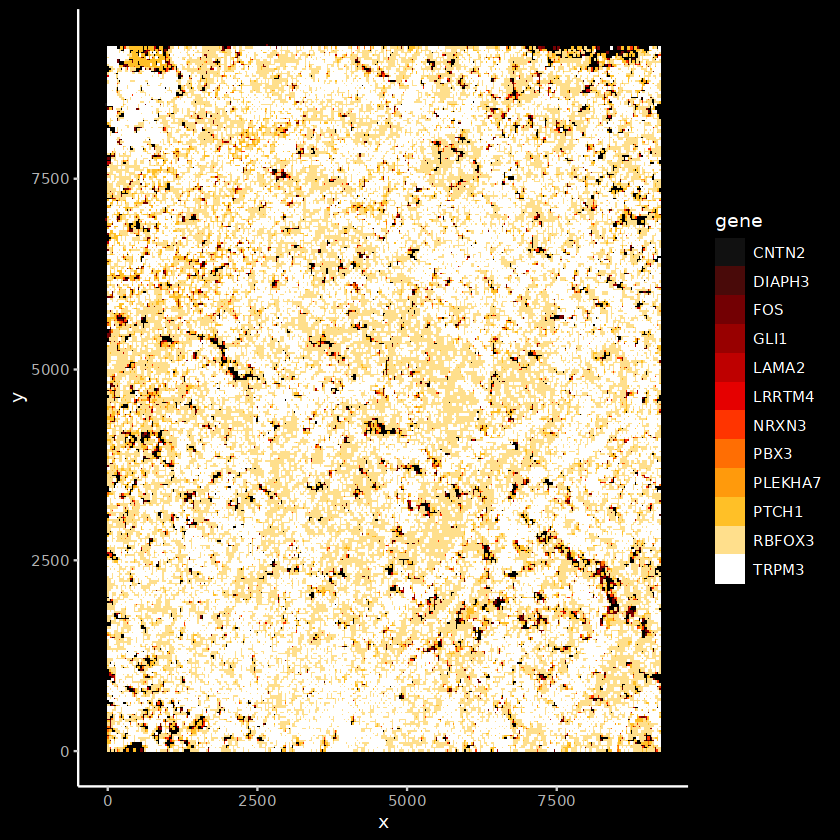

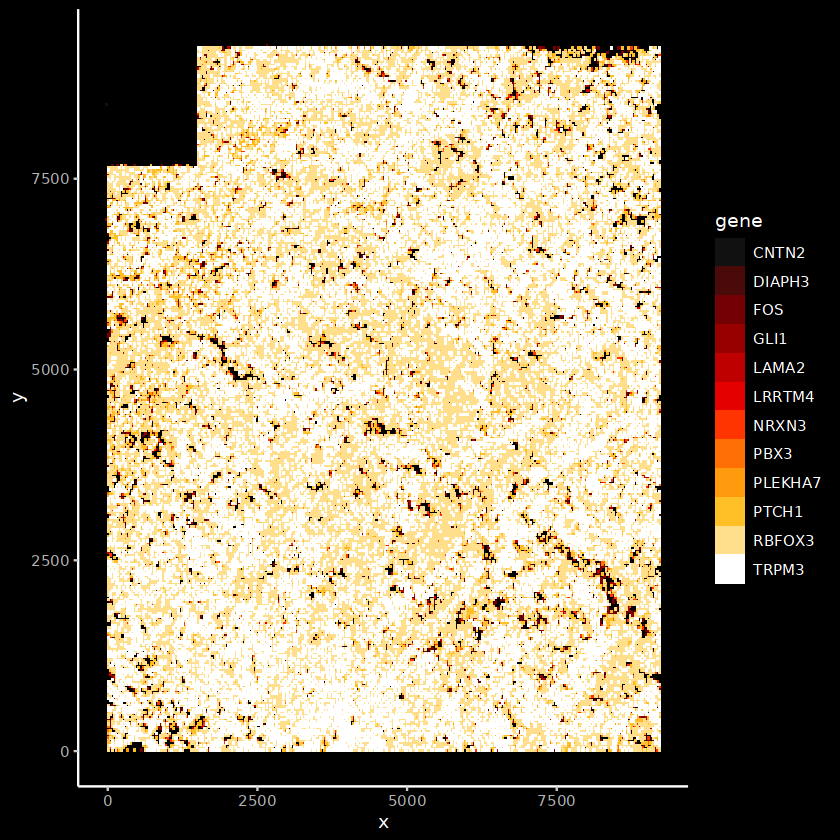

In [81]:
mols.mb295 %>%
    ggplot(aes(x, y, fill = gene)) &
    geom_bin_2d(bins = 300) &
    theme_classic() %>% dark_mode() & 
    scale_fill_manual(values = cet_pal(12, name = use.colors.opt))

anti_join(mols.mb295, mols.mb295 %>%
filter(between(x, 0, 1520), between(y, 7660, 9230))) %>%
ggplot(aes(x, y, fill = gene)) &
    geom_bin_2d(bins = 300) &
    theme_classic() %>% dark_mode() & 
    scale_fill_manual(values = cet_pal(12, name = use.colors.opt))


In [4]:
# NOTE: data are in px space.. to convert to micron space: make $x * 0.3014844, $y * 0.3014844 for each coord.

In [ ]:
# Load data - make obj
# get functions
source("./scripts/spatial_binning.R")

# set dir path
path2mols.rs <- list.files("./04_RNAscope", 
                           recursive = TRUE,
                           full.names = TRUE) %>% grep(".txt", ., value = TRUE)
path2mols.rs

sample.name <- 
    lapply(path2mols.rs %>% seq, function(i) {
        stringr::str_split(path2mols.rs[i], "/") %>% unlist %>% tail(1) %>%
        stringi::stri_replace_all_regex(., pattern = "20230703_|_allTranscripts_v1.txt|a", "") %>% 
        tolower() %>%
        stringr::str_split(., "_") %>% 
        unlist %>% sort %>%
        tail(., n = 2) %>%
        glue::glue_collapse(sep = ".") %>%
        paste0(".RNAScope")
    }) %>% unlist
sample.name
           
pbapply::pboptions(type = "timer", style = 1, char = "=")
start.time <- Sys.time()
obj.list.rs <- 
  pbapply::pblapply(path2mols.rs %>% seq, function(i) {
      gc() %>% invisible
      BinMols.Seurat(file.path = path2mols.rs[i],
                      bin.size = 48.74,
                      coord.space = "pixel",
                      to.microns.RNAScope = TRUE, #..will convert coords to microns
                      spatial.technology = "RNAScope",
                      MulticoreParam.cores = 15,
                      fov = sample.name[i],
                      assay = "RNAScope",
                      use.furrr = FALSE,
                      update.object = TRUE)
    })
end.time <- Sys.time()
end.time - start.time
obj.list.rs

In [44]:
# update metadata                
obj.names <- 
lapply(obj.list.rs %>% seq, function(i) {
    obj.list.rs[[i]] %>% Images()}
      )
#obj.names
names(obj.list.rs) <- obj.names

# add orig.ident
for (i in obj.list.rs %>% names %>% seq) {
    obj.list.rs[[i]]$orig.ident <- names(obj.list.rs)[i]
} 
# check
lapply(obj.list.rs %>% seq, function(i) obj.list.rs[[i]]$orig.ident %>% table)
       

[[1]]
.
mb266.RNAScope 
          1638 

[[2]]
.
mb295.RNAScope 
          3275 

[[3]]
.
mb299.RNAScope 
          2116 


In [46]:
# merge 
obj.rs <- merge(obj.list.rs[[1]], obj.list.rs[-1])
obj.rs
obj.rs %>% getMeta() %>% str

Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


An object of class Seurat 
12 features across 7029 samples within 1 assay 
Active assay: RNAScope (12 features, 0 variable features)
 3 spatial fields of view present: mb266.RNAScope mb295.RNAScope mb299.RNAScope

'data.frame':	7029 obs. of  5 variables:
 $ orig.ident       : chr  "mb266.RNAScope" "mb266.RNAScope" "mb266.RNAScope" "mb266.RNAScope" ...
 $ nCount_RNAScope  : num  76 263 237 293 335 393 387 228 318 251 ...
 $ nFeature_RNAScope: int  8 11 10 11 11 12 12 11 11 11 ...
 $ spatial_bin      : int  1 2 3 4 5 6 7 8 9 10 ...
 $ bin.size         : num  48.7 48.7 48.7 48.7 48.7 ...


[1] "mb295.RNAScope"

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


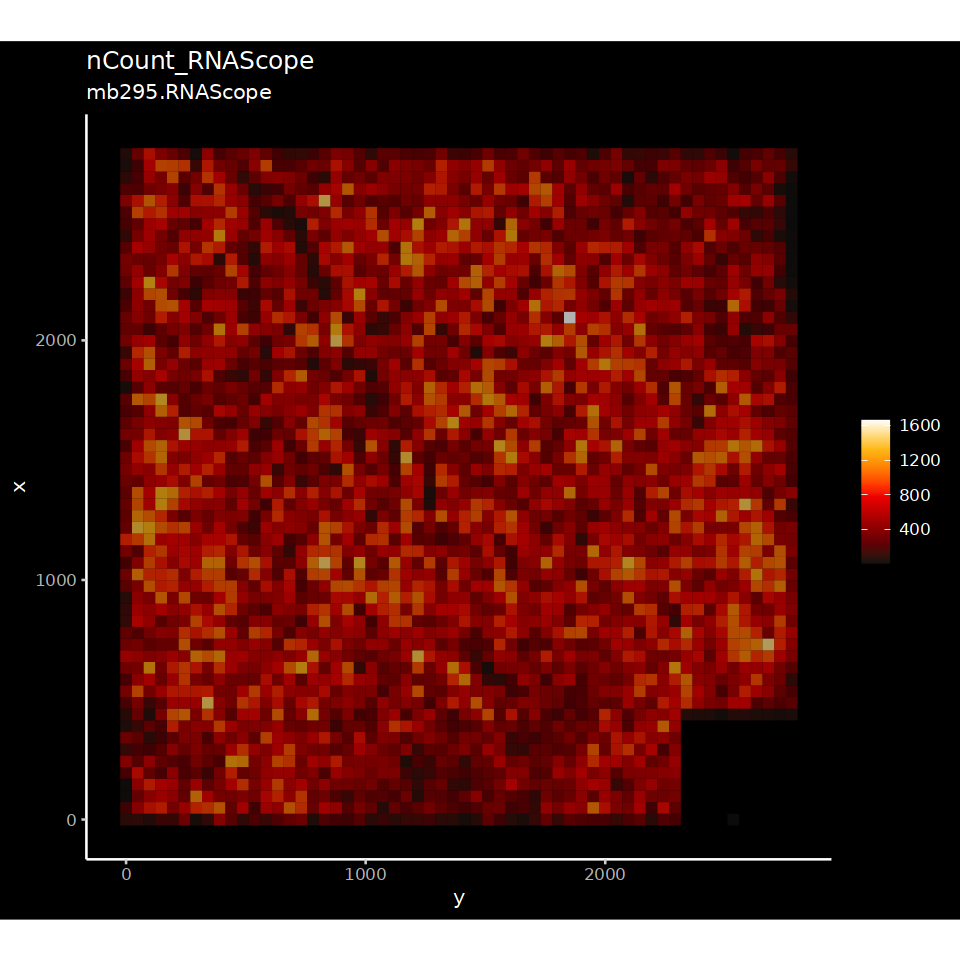

In [12]:
# quick plot check
## using "segmentation-free" spatial Seurat obj
# plot transcripts counts - nCount, add Spatial bins on top ----
if (!exists("scale.col_sp")) { 
    scale.col_sp <- c(alpha("gray12", 0.4), cet_pal(16, name = "fire")[2:16])
}
cols_bins <-
    c("deeppink", "navyblue", "cyan", 
      "yellow", "orangered", "gray14") %>% rev
cols_bins <- cet_pal(16, name = "fire")

i <- 2 # FOV to use
Images(obj.rs)[i]
markers <- grep("nCount", getMeta(obj.rs) %>% names, value = TRUE)
sp_pl1 <- 
ImageFeaturePlot(obj.rs,  
                 fov = Images(obj.rs)[i], # using cropped FOV for plotting.
                 features = markers,
                 #cols = scale.col_sp,
                 #molecules = "LAMA2",
                 #mols.cols = "cyan1",
                 #mols.size = 0.5,
                 #nmols = 1000,
                 size = 1,
                 border.size = NA,
                 border.color = alpha("gray4", 0.3),
                 boundaries = "boxes",
                 alpha = 0.7,
                 axes = TRUE,
                 combine = FALSE) 

# arrange data in an increasing order
for (p in markers %>% seq) {
    #sp_pl1[[i]]$data <- 
    #sp_pl1[[i]]$data[order(sp_pl1[[i]]$data[[markers[i]]]),]
    # sort using dpyr
    sp_pl1[[p]]$data %<>% 
        arrange(!!as.symbol(markers[p]))
}

# plot it
options(repr.plot.height = 8, repr.plot.width = 8)
sp_pl1 <- 
lapply(sp_pl1 %>% seq, function(p) { 
    sp_pl1[[p]] & theme_classic(base_size = 12) %>% dark_mode & 
    #coord_flip() &
    scale_fill_gradientn(name = NULL, # remove legend name
                         colours = cols_bins) &
    theme( 
          plot.background = element_rect(fill = "black", color = "black")) &
     labs(subtitle = Images(obj.rs)[i])}
      )
sp_pl1[[1]]

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


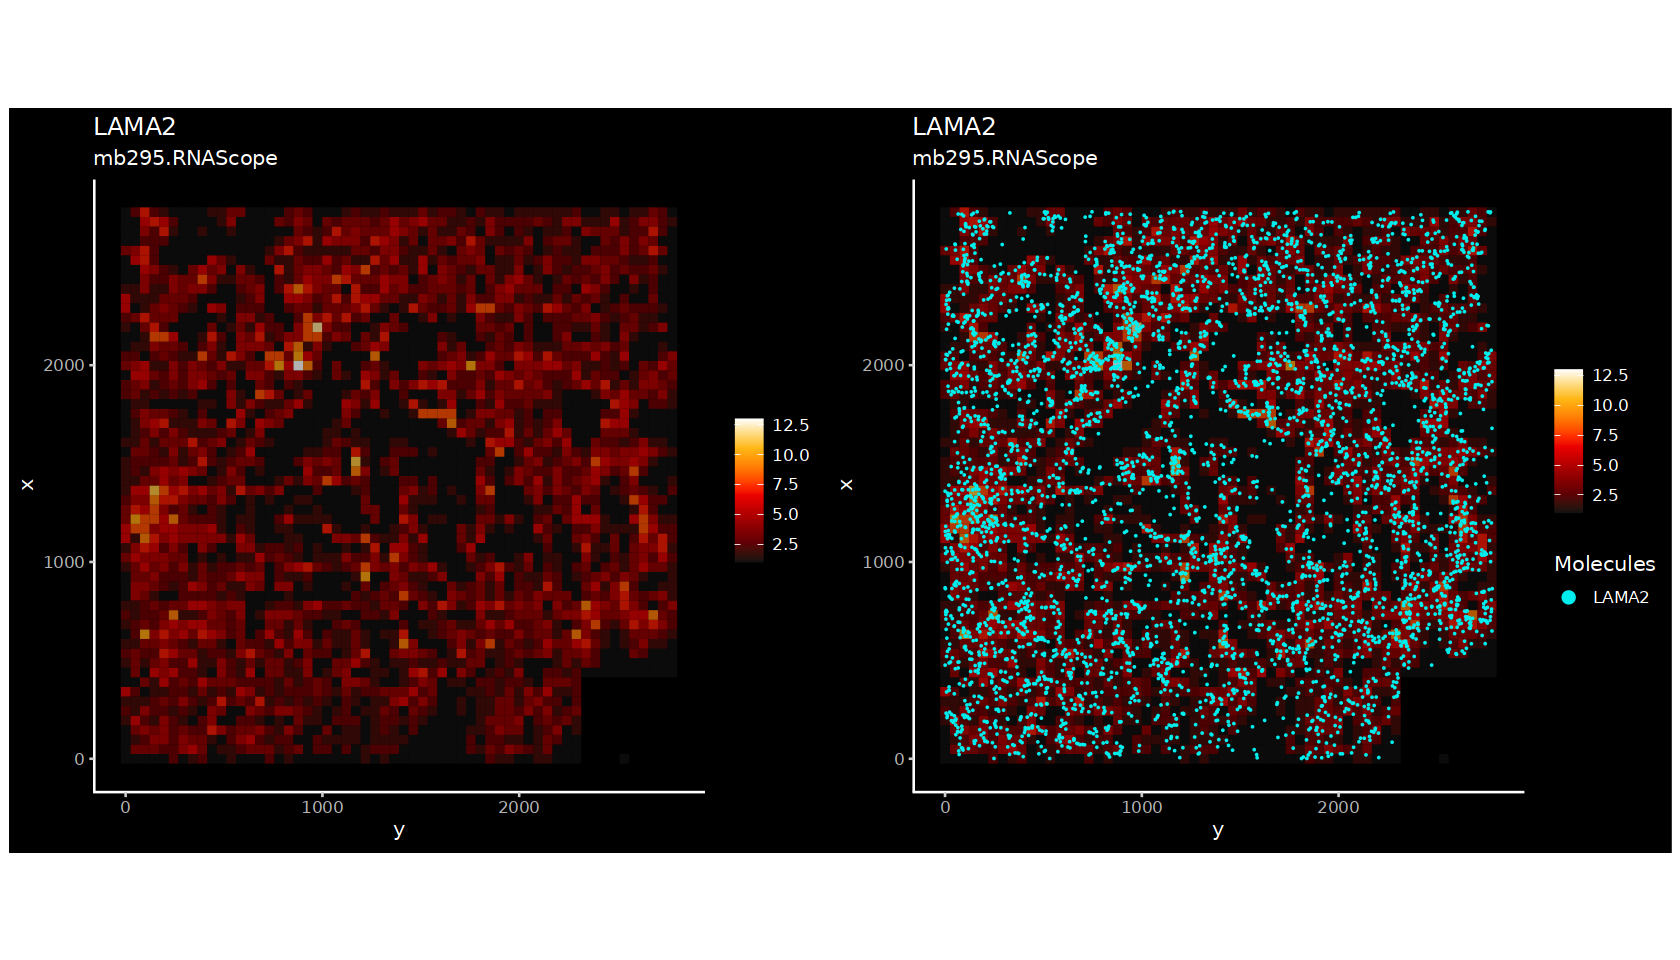

In [122]:
# LAMA2 expression
sp_pl1 <-
ImageFeaturePlot(obj.rs,  
                 fov = Images(obj.rs)[i], # using cropped FOV for plotting.
                 features = "LAMA2",
                 cols = cols_bins,
                 #molecules = "LAMA2",
                 #mols.cols = "cyan1",
                 #mols.size = 0.5,
                 #nmols = 10000,
                 size = 1,
                 border.size = NA,
                 border.color = alpha("gray4", 0.3),
                 boundaries = "boxes",
                 alpha = 0.7,
                 axes = TRUE,
                 combine = FALSE)
sp_pl1 <- 
lapply(sp_pl1 %>% seq, function(p) { 
    sp_pl1[[p]] & theme_classic(base_size = 12) %>% dark_mode & 
    #coord_flip() &
    scale_fill_gradientn(name = NULL, # remove legend name
                         colours = cols_bins) &
    theme( 
          plot.background = element_rect(fill = "black", color = "black")) &
     labs(subtitle = Images(obj.rs)[i])}
      )

#sp_pl1
#i <- 1
sp_pl2 <-
ImageFeaturePlot(obj.rs,  
                 fov = Images(obj.rs)[i], # using cropped FOV for plotting.
                 features = "LAMA2",
                 cols = cols_bins,
                 molecules = "LAMA2",
                 mols.cols = alpha("cyan2"),
                 mols.size = 0.01/2,
                 nmols = 5000,
                 size = 1,
                 border.size = NA,
                 border.color = alpha("gray4", 0.3),
                 boundaries = "boxes",
                 alpha = 0.7,
                 axes = TRUE,
                 combine = FALSE) 
sp_pl2 <- 
lapply(sp_pl2 %>% seq, function(p) { 
    sp_pl2[[p]] & theme_classic(base_size = 12) %>% dark_mode & 
    #coord_flip() &
    scale_fill_gradientn(name = NULL, # remove legend name
                         colours = cols_bins) &
    theme( 
          plot.background = element_rect(fill = "black", color = "black")) &
     labs(subtitle = Images(obj.rs)[i])}
      )

options(repr.plot.height = 8, repr.plot.width = 14)
wrap_plots(list(sp_pl1[[1]], sp_pl2[[1]]))

#### <span style="font-size:12pt; color:gold"> Make Seurat obj _10_ target genes only </span>
<span style="font-size:11pt; color:tomato"> ..Vizgen, Resolve, 10Xsn, RNAScope techs </span> <br /> 

In [14]:
# Prefiltering ----
gc() %>% invisible()
# Sanity check
if (any(obj.rs$nCount_RNAScope == 0)) {
    message("Removing cell with 0 transcript counts")
    obj.rs %<>% subset(subset = nCount_RNAScope > 0)
} else { message("All transcript counts > 0") }


All transcript counts > 0



<span style="font-size:12pt; color:gold"> Get 10 unique RNAScope genes per technology </span> <br />
<span style="font-size:10pt; color:steelblue"> ..matched target </span> <br />

In [15]:
# matched target genes
g.matched <- 
    # same genes between techs
    intersect(rownames(obj), rownames(obj.rs))
g.matched %>% str

 chr [1:10] "CNTN2" "GLI1" "LAMA2" "NRXN3" "PBX3" "PTCH1" "RBFOX3" "TRPM3" ...


In [16]:
# Subset to keep only 10 genes ----
# subset obj and FOVs
# load modified subset function
source("./scripts/subset_obj_seurat_v2.R")
obj %<>% subset_opt(features = g.matched)
obj
obj %>% getMeta() %>% str

obj.rs %<>% subset_opt(features = g.matched)
obj.rs

Updating object slots..

Cloing object..

Matching cells in FOVs..

Cell subsets are found in all FOVs!
Subsetting object..

Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associat

An object of class Seurat 
10 features across 26499 samples within 1 assay 
Active assay: VizResVis (10 features, 0 variable features)
 11 spatial fields of view present: mb295.Vizgen mb266.Vizgen mb263.w4a1.Resolve mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb299.w7a1.Resolve mb263.Visium mb266.Visium mb295.Visium mb299.Visium

'data.frame':	26499 obs. of  9 variables:
 $ orig.ident        : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ spatial_bin       : chr  "Vz_spatial_bin_50_1" "Vz_spatial_bin_51_1" "Vz_spatial_bin_52_1" "Vz_spatial_bin_53_1" ...
 $ bin.size          : num  48.7 48.7 48.7 48.7 48.7 ...
 $ spatial_tech      : chr  "Vizgen" "Vizgen" "Vizgen" "Vizgen" ...
 $ samples           : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ donors            : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ nCount_VizResVis  : num  0 70 137 246 153 256 62 88 18 2 ...
 $ nFeature_VizResVis: int  0 6 10 8 8 9 7 8 8 2 ...
 $ cell_id           : chr  NA NA NA NA ...


Updating object slots..

Cloing object..

Matching cells in FOVs..

Cell subsets are found in all FOVs!
Subsetting object..

Subsetting FOVs..

Updating object..

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version

Object is ready!



An object of class Seurat 
10 features across 7029 samples within 1 assay 
Active assay: RNAScope (10 features, 0 variable features)
 3 spatial fields of view present: mb266.RNAScope mb295.RNAScope mb299.RNAScope

In [17]:
DefaultAssay(obj) <- 
    Assays(obj) %>% 
    grep("SCT", ., value = TRUE, invert = TRUE)
# Sanity
# check for genes
gene.index <- c((GetAssayData(obj) %>% rowSums) == 0)
if (gene.index %>% any) {
    n.genes <- which(gene.index)
    message("Total of ", n.genes %>% length, 
            " have 0 expression in all cells", "\n",
            ">>> removing these genes..")
    obj %<>% 
        subset_opt(features = rownames(obj)[-n.genes])
    } else { message("Sanity passed:", "\n",
                     ">>> A single gene is expressed in least 1 cell", "\n", 
                     ">>> No genes have 0 expression in all cells") }

# check for cells
cell.index <- c((GetAssayData(obj) %>% colSums) == 0)
if (cell.index %>% any) {
    message("Removing cell with 0 transcript counts")
    obj %<>% subset_opt(cells = -which(cell.index))
} else { message("Sanity passed:", "\n", 
                 ">>> All transcript counts > 0") }

Sanity passed:
>>> A single gene is expressed in least 1 cell
>>> No genes have 0 expression in all cells

Removing cell with 0 transcript counts

Updating object slots..

Cloing object..

Matching cells in FOVs..

Cell subsets are found in all FOVs!
Subsetting object..

Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay

In [18]:
# update metadata - RNAScope ----
obj.rs@meta.data %<>%
    mutate(samples = orig.ident,
           donors = orig.ident,
           spatial_tech = "RNAScope",
           spatial_bin = Cells(obj.rs) %>% paste0("Rs_", .)) %>%
    select(!contains(c("percent","nCount","nFeature")))

# merge objects
obj.vzre.vis.rs <- merge(x = RenameAssays(obj, VizResVis = "VizResVisRs"),
                         y = RenameAssays(obj.rs, RNAScope = "VizResVisRs"))

# keep only Assay-specific metadata
obj.vzre.vis.rs@meta.data %<>%
    select(!ends_with(c("cell_id","_VizResVis")))

Renaming default assay from VizResVis to VizResVisRs

Warning message:
“Cannot add objects with duplicate keys (offending key: vizresvis_) setting key to original value 'vizresvisrs_'”
Renaming default assay from RNAScope to VizResVisRs

Warning message:
“Cannot add objects with duplicate keys (offending key: rnascope_) setting key to original value 'vizresvisrs_'”


In [19]:
obj.vzre.vis.rs
obj.vzre.vis.rs %>% getMeta() %>% str

An object of class Seurat 
10 features across 32449 samples within 1 assay 
Active assay: VizResVisRs (10 features, 0 variable features)
 14 spatial fields of view present: mb295.Vizgen mb266.Vizgen mb263.w4a1.Resolve mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb299.w7a1.Resolve mb263.Visium mb266.Visium mb295.Visium mb299.Visium mb266.RNAScope mb295.RNAScope mb299.RNAScope

'data.frame':	32449 obs. of  8 variables:
 $ orig.ident          : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ spatial_bin         : chr  "Vz_spatial_bin_51_1" "Vz_spatial_bin_52_1" "Vz_spatial_bin_53_1" "Vz_spatial_bin_54_1" ...
 $ bin.size            : num  48.7 48.7 48.7 48.7 48.7 ...
 $ spatial_tech        : chr  "Vizgen" "Vizgen" "Vizgen" "Vizgen" ...
 $ samples             : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ donors              : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ nCount_VizResVisRs  : num  70 137 246 153 256 62 88 18 2 52 ...
 $ nFeature_VizResVisRs: int  6 10 8 8 9 7 8 8 2 6 ...


In [20]:
# Sanity
# check for genes
gene.index <- c((GetAssayData(obj.vzre.vis.rs) %>% rowSums) == 0)
if (gene.index %>% any) {
    n.genes <- which(gene.index)
    message("Total of ", n.genes %>% length, 
            " have 0 expression in all cells", "\n",
            ">>> removing these genes..")
    obj.vzre.vis.rs %<>% 
        subset_opt(features = rownames(obj.vzre.vis.rs)[-n.genes])
    } else { message("Sanity passed:", "\n",
                     ">>> A single gene is expressed in least 1 cell", "\n", 
                     ">>> No genes have 0 expression in all cells") }

# check for cells
cell.index <- c((GetAssayData(obj.vzre.vis.rs) %>% colSums) == 0)
if (cell.index %>% any) {
    message("Removing cell with 0 transcript counts")
    obj.vzre.vis.rs %<>% subset_opt(cells = -which(cell.index))
} else { message("Sanity passed:", "\n", 
                 ">>> All transcript counts > 0") }

Sanity passed:
>>> A single gene is expressed in least 1 cell
>>> No genes have 0 expression in all cells

Removing cell with 0 transcript counts

Updating object slots..

Cloing object..

Matching cells in FOVs..

Cell subsets are found in all FOVs!
Subsetting object..

Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay

##### <span style="font-size:12pt; color:gold"> Normalize data </span>
<span style="font-size:10pt; color:tomato"> `SCTransform` </span> 

In [21]:
start.time <- Sys.time()
# fast analysis
obj.vzre.vis.rs %<>% 
    SCTransform(assay = "VizResVisRs", 
                #clip.range = c(-10, 10), 
                verbose = FALSE) #%>%
    #RunPCA(npcs = 30, features = rownames(vizgen.obj), verbose = FALSE) %>%
    #RunUMAP(reduction = "pca", dims = 1:30, verbose = FALSE) %>%
    #FindNeighbors(reduction = "pca", dims = 1:30) %>%
    #FindClusters(resolution = 0.15, 
    #             method = "igraph", 
    #             algorithm = 1 #algorithm = 4 # leiden clustering
    #            ) %>% suppressWarnings()
end.time <- Sys.time()
end.time - start.time
obj.vzre.vis.rs

Time difference of 2.60071 secs

An object of class Seurat 
20 features across 32446 samples within 2 assays 
Active assay: SCT (10 features, 10 variable features)
 1 other assay present: VizResVisRs
 14 spatial fields of view present: mb295.Vizgen mb266.Vizgen mb263.w4a1.Resolve mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb299.w7a1.Resolve mb263.Visium mb266.Visium mb295.Visium mb299.Visium mb266.RNAScope mb295.RNAScope mb299.RNAScope

In [23]:
obj.vzre.vis.rs %>% getMeta %>% str

'data.frame':	32446 obs. of  10 variables:
 $ orig.ident          : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ spatial_bin         : chr  "Vz_spatial_bin_51_1" "Vz_spatial_bin_52_1" "Vz_spatial_bin_53_1" "Vz_spatial_bin_54_1" ...
 $ bin.size            : num  48.7 48.7 48.7 48.7 48.7 ...
 $ spatial_tech        : chr  "Vizgen" "Vizgen" "Vizgen" "Vizgen" ...
 $ samples             : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ donors              : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ nCount_VizResVisRs  : num  70 137 246 153 256 62 88 18 2 52 ...
 $ nFeature_VizResVisRs: int  6 10 8 8 9 7 8 8 2 6 ...
 $ nCount_SCT          : num  204 211 212 209 212 207 207 197 179 207 ...
 $ nFeature_SCT        : int  7 10 8 8 9 10 8 10 10 9 ...


##### <span style="font-size:11pt; color:gold"> Save object </span>


In [24]:
# save object
dir_path <- "./segmentation_free/objects/"
saveRDS(obj.vzre.vis.rs, file = paste0(dir_path, sep = "/", "vz.re.vis.rs_matched.rds"))
list.files(dir_path)

[1] "mb_299.295.266.263_matched_visium.rds"
[2] "re_temp.rds"                          
[3] "vz_temp.rds"                          
[4] "vz.re_full.rds"                       
[5] "vz.re_matched_bg.rds"                 
[6] "vz.re_matched.rds"                    
[7] "vz.re.vis_matched.rds"                
[8] "vz.re.vis.rs_matched.rds"

#### <span style="font-size:12pt; color:gold"> Load merged pre-filtered object(s) (ie, only with `nCount > 0`) </span>
<span style="font-size:10pt; color:tomato">***MB295, 266*** samples (2nd run).. Vizgen </span> <br />
<span style="font-size:10pt; color:tomato">***MB299, 295, 266, 263*** samples..Resolve, 10X Visium  </span> <br />
<span style="font-size:10pt; color:tomato">***MB299, 295, 266*** samples..RNAScope </span> <br />

In [57]:
dir_path <- "./segmentation_free/objects"
file2load <- list.files(dir_path, pattern = "vz.re.vis.rs", full.names = TRUE)

message("Loading ", "'", file2load %>% 
        gsub(pattern = paste0(dir_path, "|", "/"), replacement = "", .), "'", " object")
obj_rs <- readRDS(file2load)
obj_rs
obj_rs %>% getMeta %>% str

Loading 'vz.re.vis.rs_matched.rds' object



An object of class Seurat 
20 features across 32446 samples within 2 assays 
Active assay: SCT (10 features, 10 variable features)
 1 other assay present: VizResVisRs
 14 spatial fields of view present: mb295.Vizgen mb266.Vizgen mb263.w4a1.Resolve mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb299.w7a1.Resolve mb263.Visium mb266.Visium mb295.Visium mb299.Visium mb266.RNAScope mb295.RNAScope mb299.RNAScope

'data.frame':	32446 obs. of  10 variables:
 $ orig.ident          : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ spatial_bin         : chr  "Vz_spatial_bin_51_1" "Vz_spatial_bin_52_1" "Vz_spatial_bin_53_1" "Vz_spatial_bin_54_1" ...
 $ bin.size            : num  48.7 48.7 48.7 48.7 48.7 ...
 $ spatial_tech        : chr  "Vizgen" "Vizgen" "Vizgen" "Vizgen" ...
 $ samples             : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ donors              : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ nCount_VizResVisRs  : num  70 137 246 153 256 62 88 18 2 52 ...
 $ nFeature_VizResVisRs: int  6 10 8 8 9 7 8 8 2 6 ...
 $ nCount_SCT          : num  204 211 212 209 212 207 207 197 179 207 ...
 $ nFeature_SCT        : int  7 10 8 8 9 10 8 10 10 9 ...


In [58]:
message("Updating some metadata variables")
# simplified sample names
simple.custom <- TRUE
if (simple.custom) {
    # support for multiple - same name - samples
    obj_rs$samples %<>%
        stringi::stri_replace_all_regex(., 
                                        #pattern = "region[0-1].|w(.)[^:][0-9].", # merges same samples
                                        pattern = "region[0-1].|w[4,5,7]a1.|_[a-e]",
                                        replacement = "")
    }  
obj_rs$samples %>% table
obj_rs$samples %>% table %>% str
# should be 11 samples in total

# add donors
obj_rs$donors <- obj$samples # data comes from the same patient/sample
obj_rs %>% getMeta %>% str

Updating some metadata variables



.
 mb263.Resolve   mb263.Visium  mb266.Resolve mb266.RNAScope   mb266.Visium 
          1555           1896           1696           1636           2507 
  mb266.Vizgen  mb295.Resolve mb295.RNAScope   mb295.Visium   mb295.Vizgen 
          4986           1891           3274           2325           4947 
 mb299.Resolve mb299.RNAScope   mb299.Visium 
          1075           2116           2542 

 'table' int [1:13(1d)] 1555 1896 1696 1636 2507 4986 1891 3274 2325 4947 ...
 - attr(*, "dimnames")=List of 1
  ..$ .: chr [1:13] "mb263.Resolve" "mb263.Visium" "mb266.Resolve" "mb266.RNAScope" ...
'data.frame':	32446 obs. of  10 variables:
 $ orig.ident          : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ spatial_bin         : chr  "Vz_spatial_bin_51_1" "Vz_spatial_bin_52_1" "Vz_spatial_bin_53_1" "Vz_spatial_bin_54_1" ...
 $ bin.size            : num  48.7 48.7 48.7 48.7 48.7 ...
 $ spatial_tech        : chr  "Vizgen" "Vizgen" "Vizgen" "Vizgen" ...
 $ samples             : chr  "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" "mb295.Vizgen" ...
 $ donors              : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ nCount_VizResVisRs  : num  70 137 246 153 256 62 88 18 2 52 ...
 $ nFeature_VizResVisRs: int  6 10 8 8 9 7 8 8 2 6 ...
 $ nCount_SCT          : num  204 211 212 209 212 207 207 197 179 207 ...
 $ nFeature_SCT        : 

In [59]:
obj <- readRDS("./segmentation_free/objects/xen_merged.rds")
obj
obj %>% getMeta %>% str

An object of class Seurat 
541 features across 44401 samples within 1 assay 
Active assay: Xenium (541 features, 0 variable features)
 4 spatial fields of view present: mb263.Xenium mb266.Xenium mb295.Xenium mb299.Xenium

'data.frame':	44401 obs. of  9 variables:
 $ orig.ident     : chr  "mb263.Xenium" "mb263.Xenium" "mb263.Xenium" "mb263.Xenium" ...
 $ nCount_Xenium  : num  364 13 4 5 6 4 4 7 8 5 ...
 $ nFeature_Xenium: int  88 11 4 4 6 3 4 6 8 5 ...
 $ spatial_bin    : int  335 336 337 338 339 340 341 342 343 344 ...
 $ bin.size       : num  48.7 48.7 48.7 48.7 48.7 ...
 $ samples        : chr  "mb263.Xenium" "mb263.Xenium" "mb263.Xenium" "mb263.Xenium" ...
 $ donors         : chr  "mb263.Xenium" "mb263.Xenium" "mb263.Xenium" "mb263.Xenium" ...
 $ spatial_tech   : chr  "Xenium" "Xenium" "Xenium" "Xenium" ...
 $ cell_id        : chr  "spatial_bin_335" "spatial_bin_336" "spatial_bin_337" "spatial_bin_338" ...


#### <span style="font-size:12pt; color:gold"> add Xenim to existing pre-filtered object with RNAScope 10 genes </span>

In [61]:
g.matched <- intersect(rownames(obj), rownames(obj_rs))
g.matched %>% str

 chr [1:10] "CNTN2" "NRXN3" "PTCH1" "RBFOX3" "PBX3" "TRPM3" "LAMA2" ...


In [62]:
# subset to 10 genes
obj %<>% subset_opt(features = g.matched)
obj

Updating object slots..

Cloing object..

Matching cells in FOVs..

Cell subsets are found in all FOVs!
Subsetting object..

Subsetting FOVs..

Updating object..

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version

Object is ready!



An object of class Seurat 
10 features across 44401 samples within 1 assay 
Active assay: Xenium (10 features, 0 variable features)
 4 spatial fields of view present: mb263.Xenium mb266.Xenium mb295.Xenium mb299.Xenium

In [64]:
DefaultAssay(obj_rs) <- "VizResVisRs"
obj_rs %<>% DietSeurat(assays = "VizResVisRs")
obj_rs

An object of class Seurat 
10 features across 32446 samples within 1 assay 
Active assay: VizResVisRs (10 features, 0 variable features)
 14 spatial fields of view present: mb295.Vizgen mb266.Vizgen mb263.w4a1.Resolve mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb299.w7a1.Resolve mb263.Visium mb266.Visium mb295.Visium mb299.Visium mb266.RNAScope mb295.RNAScope mb299.RNAScope

In [65]:
obj_merged <- 
    merge(x = RenameAssays(obj_rs, VizResVisRs = "MultiTech"),
          y = RenameAssays(obj, Xenium = "MultiTech"))
obj_merged

Renaming default assay from VizResVisRs to MultiTech

Warning message:
“Cannot add objects with duplicate keys (offending key: vizresvisrs_) setting key to original value 'multitech_'”
Renaming default assay from Xenium to MultiTech

Warning message:
“Cannot add objects with duplicate keys (offending key: xenium_) setting key to original value 'multitech_'”
Warning message in CheckDuplicateCellNames(object.list = objects):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any

An object of class Seurat 
10 features across 76847 samples within 1 assay 
Active assay: MultiTech (10 features, 0 variable features)
 18 spatial fields of view present: mb295.Vizgen mb266.Vizgen mb263.w4a1.Resolve mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb299.w7a1.Resolve mb263.Visium mb266.Visium mb295.Visium mb299.Visium mb266.RNAScope mb295.RNAScope mb299.RNAScope mb263.Xenium mb266.Xenium mb295.Xenium mb299.Xenium

In [69]:
# update metadata
obj_merged@meta.data %<>%
    select(!contains(c("_Xenium","_VizRes",
                       "_SCT","cell_"))) %>%
    mutate(cell_id = Cells(obj_merged)) %>%
    mutate_if(is.character,
              ~ stringr::str_replace_all(., c("Resolve" = "MC", "Vizgen" = "MERFISH")))

In [70]:
obj_merged %>% getMeta %>% str

'data.frame':	76847 obs. of  9 variables:
 $ orig.ident        : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ spatial_bin       : chr  "Vz_spatial_bin_51_1" "Vz_spatial_bin_52_1" "Vz_spatial_bin_53_1" "Vz_spatial_bin_54_1" ...
 $ bin.size          : num  48.7 48.7 48.7 48.7 48.7 ...
 $ spatial_tech      : chr  "MERFISH" "MERFISH" "MERFISH" "MERFISH" ...
 $ samples           : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ donors            : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ nCount_MultiTech  : num  70 137 246 153 256 62 88 18 2 52 ...
 $ nFeature_MultiTech: int  6 10 8 8 9 7 8 8 2 6 ...
 $ cell_id           : chr  "Vz_spatial_bin_51_1_1" "Vz_spatial_bin_52_1_1" "Vz_spatial_bin_53_1_1" "Vz_spatial_bin_54_1_1" ...


In [71]:
# sanity checks    
obj_merged <- sanity.seurat(obj = obj_merged)

Sanity passed:
>>> A single gene is expressed in least 1 cell
>>> No genes have 0 expression in all cells

Removing cell with 0 transcript counts

Updating object slots..

Cloing object..

Matching cells in FOVs..

Cell subsets are found in all FOVs!
Subsetting object..

Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay present”
Warning message:
“Adding image data that isn't associated with any assay

In [72]:
obj_merged

An object of class Seurat 
10 features across 72455 samples within 1 assay 
Active assay: MultiTech (10 features, 0 variable features)
 18 spatial fields of view present: mb295.Vizgen mb266.Vizgen mb263.w4a1.Resolve mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb299.w7a1.Resolve mb263.Visium mb266.Visium mb295.Visium mb299.Visium mb266.RNAScope mb295.RNAScope mb299.RNAScope mb263.Xenium mb266.Xenium mb295.Xenium mb299.Xenium

In [73]:
# save merged object
saveRDS(object = obj_merged, file = file.path(dir_path, "vz.re.vis.rs.xen_matched.rds"))

#### <span style="font-size:12pt; color:gold"> Load merged pre-filtered object(s) (ie, only with `nCount > 0`) with Xenium </span>
<span style="font-size:10pt; color:tomato">***MB295, 266*** samples (2nd run).. Vizgen </span> <br />
<span style="font-size:10pt; color:tomato">***MB299, 295, 266, 263*** samples..Resolve, 10X Visium  </span> <br />
<span style="font-size:10pt; color:tomato">***MB299, 295, 266*** samples..RNAScope </span> <br />

In [6]:
obj <- readRDS("./segmentation_free/objects/vz.re.vis.rs.xen_matched.rds")
obj
obj %>% getMeta %>% str

An object of class Seurat 
10 features across 72455 samples within 1 assay 
Active assay: MultiTech (10 features, 0 variable features)
 18 spatial fields of view present: mb295.Vizgen mb266.Vizgen mb263.w4a1.Resolve mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb299.w7a1.Resolve mb263.Visium mb266.Visium mb295.Visium mb299.Visium mb266.RNAScope mb295.RNAScope mb299.RNAScope mb263.Xenium mb266.Xenium mb295.Xenium mb299.Xenium

'data.frame':	72455 obs. of  9 variables:
 $ orig.ident        : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ spatial_bin       : chr  "Vz_spatial_bin_51_1" "Vz_spatial_bin_52_1" "Vz_spatial_bin_53_1" "Vz_spatial_bin_54_1" ...
 $ bin.size          : num  48.7 48.7 48.7 48.7 48.7 ...
 $ spatial_tech      : chr  "MERFISH" "MERFISH" "MERFISH" "MERFISH" ...
 $ samples           : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ donors            : chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
 $ nCount_MultiTech  : num  70 137 246 153 256 62 88 18 2 52 ...
 $ nFeature_MultiTech: int  6 10 8 8 9 7 8 8 2 6 ...
 $ cell_id           : chr  "Vz_spatial_bin_51_1_1" "Vz_spatial_bin_52_1_1" "Vz_spatial_bin_53_1_1" "Vz_spatial_bin_54_1_1" ...


In [7]:
ls()

[1] "bp.workers"    "dir_path"      "dir_working"   "family.base"  
[5] "getMeta"       "mc.cores"      "obj"           "sanity.seurat"
[9] "subset_opt"

In [8]:
# clone obj
obj_rs <- obj

#### <span style="font-size:12pt; color:gold"> QCs - ..Vizgen, Resolve, Visium, RNAScope, Xenium techs - *per cell* </span>
<span style="font-size:10pt; color:tomato"> _10_ target genes only </span> <br /> 
<span style="font-size:10pt; color:tomato"> Prepara data for plots - *cells* </span> <br /> 

In [209]:
# QC variables and plot params         
message("Setting QC variables and plot params..")
meta.vars <- grep("nCount_|nFeature_|percent_", names(getMeta(obj)), value = TRUE)
message("QC variables are :", paste0("\n", ">>> ", meta.vars))

# if TRUE - using whole obj name, else other metadata var.. 
meta.var.use <- c("orig.ident", "samples", "spatial_tech")
use.orig.ident <- FALSE
if (use.orig.ident) { meta.var <- "orig.ident" } else { meta.var <- "samples" }
#meta.var <- "spatial_tech"
meta.var

# add colors for meta var (ie samples) 
meta.var.col <- colorRampPalette(RColorBrewer::brewer.pal(10, "Paired"))(table(obj[[meta.var]]) %>%
 names %>% length)
meta.var.col %>% glimpse

# title for meta.var
#paste0(substring(meta.var, 1, 1) %>% toupper, substring(meta.var, 2, nchar(meta.var)))
meta.var.title <- stringr::str_to_title(meta.var)

# custom text sizes for plots
legend.text.size <- 16
base_size <- 18
axis.text.size <- 14
   
# choose plot theme, eg dark or white
use.dark.theme <- FALSE # if FALSE - white bg is used for plots

# choose plot colors scheme..
use.colors.opt <- "fire" # options are: "inferno" or "fire"
# colors/fill scale gradient
if (use.dark.theme && use.colors.opt == "fire") {
    scale.col <- 
        cet_pal(11, name = use.colors.opt)[4:11] %>% .[c(1,3,5,6:8)]
    low.col <- scale.col[1:3]
    high.col <- scale.col[4:6]
    theme2use <- theme_classic(base_size = base_size) %>% dark_mode
    axis.text.col <- "gray96"
    gam.line.col <- alpha("green1", 0.9)
    color.dens <- alpha("dodgerblue2", 0.9)
    message("Using Dark Theme & ", paste0("'", use.colors.opt, "'"), " color scale")
} else if (!use.dark.theme && use.colors.opt == "fire") {
    scale.col <-
        cet_pal(11, name = use.colors.opt)[1:9] %>% .[c(1,3,5,6,7,9)] %>% rev
    low.col <- scale.col[1:3]
    high.col <- scale.col[4:6]
    theme2use <- theme_classic(base_size = base_size)
    axis.text.col <- "gray4"
    gam.line.col <- alpha("green4", 0.7)
    color.dens <- alpha("dodgerblue2", 0.9)
    message("Using White Theme & ", paste0("'", use.colors.opt, "'"), " color scale")
} else if (use.dark.theme && use.colors.opt == "inferno") {
    scale.col <- 
        c(viridis::viridis(11, option = use.colors.opt))[3:11] %>% .[c(1,3,5,7:9)]
    low.col <- scale.col[1:3]
    high.col <- scale.col[4:6]
    theme2use <- theme_classic(base_size = base_size) %>% dark_mode
    axis.text.col <- "gray96"
    gam.line.col <- alpha("green1", 0.9)
    color.dens <- alpha("dodgerblue2", 0.9)
    message("Using Dark Theme & ", paste0("'", use.colors.opt, "'"), " color scale")
} else if (!use.dark.theme && use.colors.opt == "inferno") {
    scale.col <- 
        c(viridis::viridis(11, option = use.colors.opt))[3:11] %>% .[c(1,3,5,7:8)] %>% 
        rev %>% c("gray4")
    low.col <- scale.col[1:3]
    high.col <- scale.col[4:6]
    theme2use <- theme_classic(base_size = base_size)
    axis.text.col <- "gray4"
    gam.line.col <- alpha("green4", 0.7)
    color.dens <- alpha("dodgerblue2", 0.9)
    message("Using White Theme & ", paste0("'", use.colors.opt, "'"), " color scale")
}

# transparent theme for white bg
theme_transparent_2 <- theme(panel.background = element_rect(fill = "transparent"),
                             plot.background = element_rect(fill = "transparent", color = NA),
                             panel.grid.major = element_blank(), 
                             panel.grid.minor = element_blank(), 
                             legend.background = element_rect(fill = "transparent"))


Setting QC variables and plot params..

QC variables are :
>>> nCount_MultiTech
>>> nFeature_MultiTech



[1] "samples"

 chr [1:17] "#A6CEE3" "#5A9DC8" "#3184AE" "#84BE97" "#92CF72" "#4AAB3D" ...


Using White Theme & 'fire' color scale



In [210]:
# subset object metadata with selected vars..
df.data <- 
    getMeta(obj) %>%
    select(all_of(c(meta.vars, meta.var.use)))

# check if percent_* metavars exist in the object
if (!any(grep("percent_", names(df.data)))) {
  message("`percent_*` metavars are not present..", "\n",
          "consider running `PercentageFeatureSet()` ")
} else {  
  message("Already present:", 
          paste0("\n", ">>> ", grep("percent_", names(df.data), value = TRUE)))
  # add log10 scale to percent_*
  add.logs <- TRUE # if TRUE, will. calculate log10(x + 1)
  if (add.logs) {
    df.id <- grep("percent_", names(df.data))
    for (i in df.id %>% length %>% seq) {
      if (!any(paste0(names(df.data[df.id[i]]), ".", "log10_1p") == names(df.data))) {
        if (any(df.data[[df.id[i]]] == 0)) {
          # convert and add pseudocount  
          df.data[[paste0(names(df.data[df.id[i]]), ".", "log10_1p")]] <- log10(df.data[[df.id[i]]] + 1)
        } else { df.data[[paste0(names(df.data[df.id[i]]), ".", "log10_1p")]] <- log10(df.data[[df.id[i]]]) }
      }
    }
  }
}

## for spatial_tech and samples
# bring same samples together
samples.merge <- 
    df.data %>% 
    pull(samples) %>% 
    unique #%>% 
    #gsub("mb", x = ., "")
# start with mb263 and mb299
# order Visium -> RNAScope -> MC -> Vizgen -> Xenium
samples.merge <- 
    list(
samples.merge %>% 
    rev %>%
    grep("263", ., value = TRUE) %>% .[c(2,3,1)],
        
samples.merge %>%
    grep("299", ., value = TRUE) %>% .[c(2,3,1,4)],
        
samples.merge %>%
    grep("266", ., value = TRUE) %>% .[c(3,4,2,1,5)],
        
samples.merge %>%
    grep("295", ., value = TRUE) %>% .[c(3,4,2,1,5)]

) %>% unlist
samples.merge %>% str

df.data %<>% 
    #..sample names as factors
    mutate(samples = 
           factor(samples, levels = 
                  samples.merge %>% unique),
           #..spatial techs as factors
           spatial_tech = factor(spatial_tech, levels = 
                                 spatial_tech %>% 
                                 unique)) %>%
    # add total cell number per sample
    group_by(samples) %>%
    group_split() %>%
    purrr::map(., ~ mutate(., nBin.samples = summarize(., n.bins = n()) %>% 
                           pull(n.bins))) %>% 
    data.table::rbindlist(.)
df.data %>% str

# re-set QC variables adding percent_* at log scale
if (any(grep(".log", names(df.data)))) {
    meta.vars.df <- unique(c(meta.vars, grep("nCount_|nFeature_|percent_|nBin", names(df.data), value = TRUE)))
    message("Re-set QC variables", "\n",  "New QC variables are:", paste0("\n", ">>> ", meta.vars.df))
} else { meta.vars.df <- unique(c(meta.vars, grep("nCount_|nFeature_|nBin", names(df.data), value = TRUE))) }

# generate breaks and limits for color scale
# examples -> [biscale breaks](https://cran.r-project.org/web/packages/biscale/vignettes/breaks.html) 
#[lemon legends](https://cran.r-project.org/web/packages/biscale/vignettes/breaks.html)
n.pretty <- 40
breaks.col <- 
lapply(seq(meta.vars.df),
       function(i) { 
           classInt::classIntervals(c(min(df.data[[meta.vars.df[i]]][!is.na(df.data[[meta.vars.df[i]]])]), 
                                      pretty(df.data[[meta.vars.df[i]]][!is.na(df.data[[meta.vars.df[i]]])], n = n.pretty)[-1] %>% 
                                      sort %>% unique),
                                    n = 2, style = "quantile")$brks %>% ceiling %>% unique }
      )
breaks.col  

adjust.logs <- TRUE # if TRUE, will adjust values for log10 only
if (adjust.logs && exists("add.logs")) {
  if (any(grep("log10", meta.vars.df))) {
    for (j in grep("log10", meta.vars.df)) {
      breaks.col[[j]] <- 
        classInt::classIntervals(c(min(df.data[[meta.vars.df[j]]][!is.na(df.data[[meta.vars.df[j]]])]), 
                                   pretty(df.data[[meta.vars.df[j]]][!is.na(df.data[[meta.vars.df[j]]])], n = n.pretty)[-1] %>% 
                                     sort %>% unique), 
                                 n = 2, style = "quantile")$brks %>% round(digits = 2) %>% unique 
    }
  }
  breaks.col
}

# round breaks.col and add K to breaks.col.label for large values > 1000
breaks.col.label <- breaks.col 
breaks.col.label <- 
lapply(breaks.col.label, function(i) 
    scales::number(i, 
               scale_cut = scales::cut_long_scale()))
#for (i in seq(breaks.col)) {
#    if (isFALSE(length(lapply(seq(breaks.col), function(i) which(breaks.col[[i]] >= 1000))[[i]]) == 0))
#        { breaks.col.label[[i]] <- c(breaks.col[[i]][which(breaks.col[[i]] < 1000)] %>% round(),
#                                     paste0(c(breaks.col[[i]][which(breaks.col[[i]] >= 1000)] / 1000) %>% 
#                                            round(digits = 1), "K"))
#        } else { breaks.col.label[[i]] %<>% as.character }
#}                                                       
breaks.col.label
                              
# fuse log and non-log scaled values
if (exists("add.logs")) {
  for (i in grep(".log", meta.vars.df)) {
    # add 0(1), ie log scale(real value)
    #breaks.col.label[[i]][1] <- paste0(breaks.col.label[[i]][1], "(", 1, ")")
    
    if (any(10^breaks.col[[i]] >= 1000 & !10^breaks.col[[i]] >= 1e6)) {
      breaks.col.label[[i]][which(10^breaks.col[[i]] >= 1000 & !10^breaks.col[[i]] >= 1e6)] <- 
        paste0(breaks.col.label[[i]][which(10^breaks.col[[i]] >= 1000 & !10^breaks.col[[i]] >= 1e6)], "(", 
               paste0(c(10^breaks.col[[i]][which(10^breaks.col[[i]] >= 1000 & !10^breaks.col[[i]] >= 1e6)] / 1000) %>% 
                        round(digits = 1), "K"), ")") 
    }
    if (any(10^breaks.col[[i]] >= 1e6)) 
    { breaks.col.label[[i]][which(10^breaks.col[[i]] >= 1e6)] <- 
      paste0(breaks.col[[i]][which(10^breaks.col[[i]] >= 1e6)], "(", 
             paste0(c(10^breaks.col[[i]][which(10^breaks.col[[i]] >= 1e6)] / 1e6) %>% 
                      round(digits = 1), "M"), ")")
    } else if (any(10^breaks.col[[i]] < 1000)) { 
      breaks.col.label[[i]][which(10^breaks.col[[i]] < 1000)] <- 
        paste0(breaks.col.label[[i]][which(10^breaks.col[[i]] < 1000)], "(", 
               10^breaks.col[[i]][which(10^breaks.col[[i]] < 1000)] %>% ceiling, ")") 
    }
  }
}
breaks.col.label
                              
# add limits
limits <- lapply(seq(meta.vars.df), function(i) 
    #c(min(breaks.col[[i]]), max(breaks.col[[i]]))
    range(breaks.col[[i]])
                 )
limits

message("Calculating summary stats - median")
# median values per sample
df.data.filt <- 
df.data %>%
dplyr::group_by_at(meta.var) %>% 
summarize_if(is.numeric, ~ median(.) %>% round(digits = 0), na.rm = TRUE)
df.data.filt

message("Calculating summary stats - sd")
# sd or variance values per sample
df.data %>%
dplyr::group_by_at(meta.var) %>% 
summarise_if(is.numeric, ~ sd(.) %>% round(digits = 0), na.rm = TRUE)
                 
message("..using metadata variable - ", meta.var,
       if (use.dark.theme) { 
           "\n..using Dark Theme" }
       else { "\n..using White Theme" } , "\n",
        paste0("'", use.colors.opt, "'"), " color scale")
                              

`percent_*` metavars are not present..
consider running `PercentageFeatureSet()` 



 chr [1:17] "mb263.Visium" "mb263.MC" "mb263.Xenium" "mb299.Visium" ...
Classes ‘data.table’ and 'data.frame':	72455 obs. of  6 variables:
 $ nCount_MultiTech  : num  3 4 12 4 13 4 10 9 7 3 ...
 $ nFeature_MultiTech: int  3 3 5 4 4 2 4 5 4 3 ...
 $ orig.ident        : chr  "mb263_d.Visium" "mb263_d.Visium" "mb263_d.Visium" "mb263_d.Visium" ...
 $ samples           : Factor w/ 17 levels "mb263.Visium",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ spatial_tech      : Factor w/ 5 levels "MERFISH","MC",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ nBin.samples      : int  1896 1896 1896 1896 1896 1896 1896 1896 1896 1896 ...
 - attr(*, ".internal.selfref")=<externalptr> 


[[1]]
[1]    1  900 1800

[[2]]
[1]  1  6 10

[[3]]
[1]  1075  7500 14000

[[1]]
[1] "1"   "900" "2K" 

[[2]]
[1] "1"  "6"  "10"

[[3]]
[1] "1.1K"  "7.5K"  "14.0K"

[[1]]
[1] "1"   "900" "2K" 

[[2]]
[1] "1"  "6"  "10"

[[3]]
[1] "1.1K"  "7.5K"  "14.0K"

[[1]]
[1]    1 1800

[[2]]
[1]  1 10

[[3]]
[1]  1075 14000

Calculating summary stats - median



samples        nCount_MultiTech nFeature_MultiTech nBin.samples
1  mb263.Visium     4               3                  1896       
2  mb263.MC       345               8                  1555       
3  mb263.Xenium   137               8                  5685       
4  mb299.Visium     5               3                  2542       
5  mb299.RNAScope 435               9                  2116       
6  mb299.MC       565               8                  1075       
7  mb299.Xenium   148               8                 13752       
8  mb266.Visium     3               2                  2507       
9  mb266.RNAScope 497              10                  1636       
10 mb266.MC       314               8                  1696       
11 mb266.MERFISH  243               9                  4986       
12 mb266.Xenium   173               8                 11030       
13 mb295.Visium     4               3                  2325       
14 mb295.RNAScope 425              10                  3274       
15 mb295.MC       569               9                  1891       
16 mb295.MERFISH  189               9                  4947       
17 mb295.Xenium   186               8                  9542

Calculating summary stats - sd



samples        nCount_MultiTech nFeature_MultiTech nBin.samples
1  mb263.Visium     3              1                  0           
2  mb263.MC       160              2                  0           
3  mb263.Xenium   136              3                  0           
4  mb299.Visium     4              1                  0           
5  mb299.RNAScope 291              1                  0           
6  mb299.MC       350              1                  0           
7  mb299.Xenium   192              3                  0           
8  mb266.Visium     2              1                  0           
9  mb266.RNAScope 238              1                  0           
10 mb266.MC       180              2                  0           
11 mb266.MERFISH  176              2                  0           
12 mb266.Xenium   148              3                  0           
13 mb295.Visium     3              1                  0           
14 mb295.RNAScope 208              1                  0           
15 mb295.MC       200              1                  0           
16 mb295.MERFISH  185              2                  0           
17 mb295.Xenium   169              3                  0

..using metadata variable - samples
..using White Theme
'fire' color scale



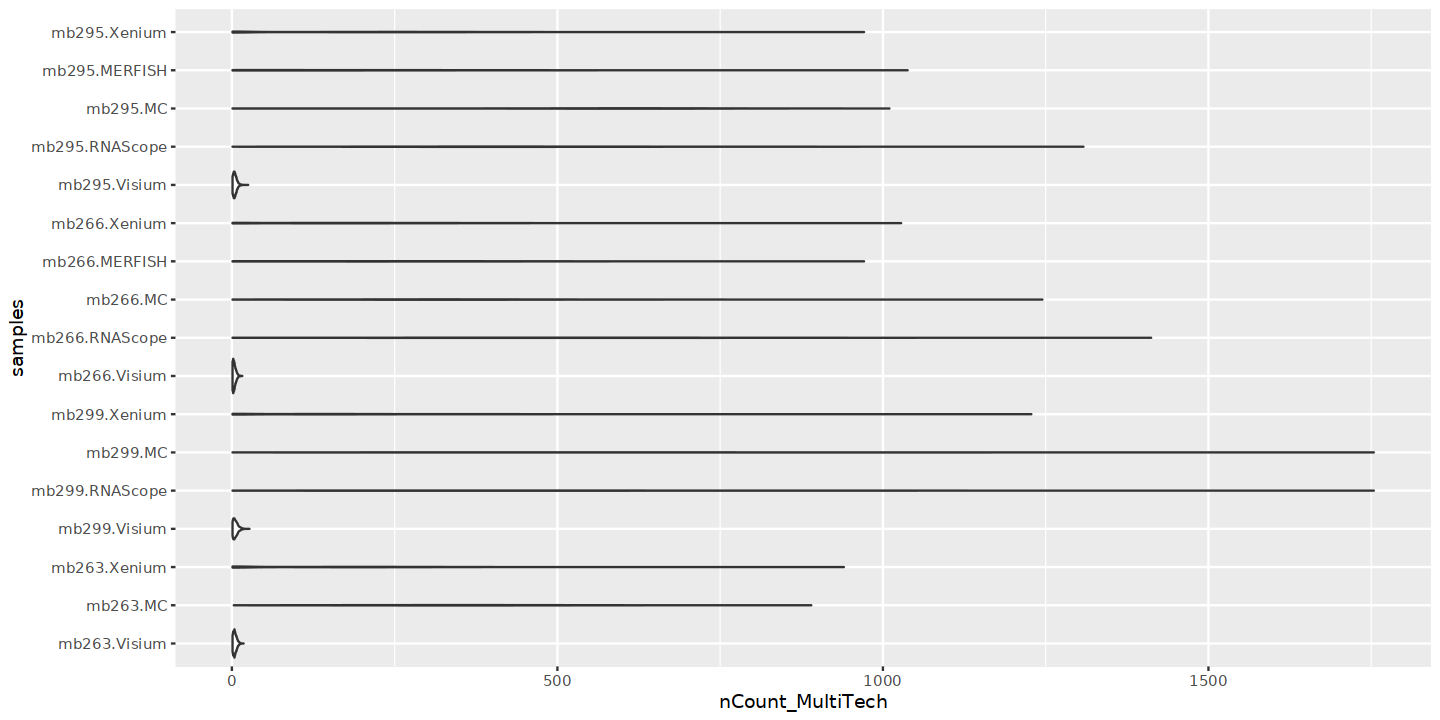

In [232]:
df.data %>%
ggplot() & geom_violin(aes(nCount_MultiTech, samples))

<span style="font-size:12pt; color:tomato"> Generate density plots - *cells* </span> <br />
<span style="font-size:10pt; color:steelblue">..density colors are number of cells per sample! </span> <br /> 

In [253]:
# Density colors are number of cells per sample!
# added QC variables for percent_* at log10 (+ pseudocount if any zeros) scale
message("Generate density plots per meta variable: ", meta.var, "\n",  
        "New QC variables are:", paste0("\n", ">>> ", meta.vars.df))

# ..legend/title for meta vars
meta.vars.legend <- gsub(pattern = paste0("_", Assays(obj) %>% 
                                              grep("SCT", ., 
                                                   value = TRUE, 
                                                   invert = TRUE)), 
                         replacement = "", meta.vars.df)
meta.vars.legend <-
c(grep("^n", meta.vars.legend, value = TRUE), 
  gsub(pattern = "percent_", replacement = "", grep("percent_", meta.vars.legend, value = TRUE)) %>%
  stringr::str_to_title() %>% paste0(". content (%)"))
# adjust for log meta vars
if (any(grep(".log", meta.vars.legend))) { 
    for (i in grep("log", meta.vars.legend)) { 
        meta.vars.legend[i] <- 
        gsub(pattern = ". content|[(%)]", replacement = "", meta.vars.legend[i]) %>% 
        paste0("(%) content")
    }
}

# for stat_density_ridges
scale.param <- c(rep(0.9, length(meta.vars.df)))

# for geom_text_repel label
# NOTE: custom labels, need to be optimized then added samples or vars
nudge_x <- c(400, 2, 50, 14, 8)
nudge_y <- c(0.6, 0.8, 0.5, 0.5, 0.6)
# breaks for total samples per cell
breaks.label.samples <- 
    scales::number(df.data$nBin.samples %>% unique %>% sort, accuracy = 0.1, 
                   scale_cut = scales::cut_long_scale())

# function to check if any meta vars have logs
check.if.log <- function(x) { grep(".log", meta.vars.df[x]) }

# generate plots
set.seed(47654)
pl1 <- lapply(seq(meta.vars.df)[-5], # irnoge the last var
              function(i) df.data %>%
              ggplot(aes_string(x = meta.vars.df[i], y = meta.var, fill = "factor(nBin.samples)")) &
              stat_density_ridges(geom = "density_ridges_gradient", 
                                  quantile_lines = TRUE, 
                                  quantile_fun = function(x, ...) 
                                      { median(x) %>% round(digits = 0) }, # add median value
                                  bandwidth = c(130, 0.5)[i],
                                  scale = scale.param[i],
                                  aes_string(point_fill = "nBin.samples", 
                                             point_color = "nBin.samples"),
                                  point_size = 0.05,
                                  point_shape = 19, point_alpha = 1,
                                  from = 0,
                                  to = c(1500, 12)[i],
                                  color = color.dens %>% alpha(0), 
                                  #size = 0.1, linetype = "solid",
                                  jittered_points = FALSE, # to hide points -> set to FALSE 
                                  position = position_raincloud(height = 0.1)
                                 ) & 
              # add ticks
              { if (any(check.if.log(i))) {
                  annotation_logticks(color = axis.text.col, sides = "b") 
              }} &
              scale_fill_manual(name = c("Total Bins"), 
                                labels = breaks.label.samples,
                                values = cet_pal(20, name = use.colors.opt)[-2]) &
              theme2use &
              theme(legend.text = element_text(size = legend.text.size),
                    axis.text = element_text(color = axis.text.col, size = axis.text.size),
                    legend.position = "right",
                    legend.key.height = grid::unit(0.5,"cm"),
                    legend.key.width = grid::unit(0.8,"cm")) & 
              labs(title = meta.vars.legend[i],
                   subtitle = rep(paste0("per Bin (", floor(48.74 ^ 2), " µm^2)"), meta.vars.df %>% length)[i],
                   x = NULL, y = NULL, fill = NA) &
              ggrepel::geom_text_repel(data = df.data.filt, # add pre-calculated median line and value
                                       aes_string(x = meta.vars.df[i], 
                                                  y = meta.var, 
                                                  label = meta.vars.df[i]),
                                       size = 5, nudge_x = nudge_x[i], nudge_y = nudge_y[i],
                                       color = color.dens,
                                       box.padding = 0.2,
                                       segment.curvature = -0.2,
                                       segment.linetype = 2,
                                       #max.overlaps = Inf,
                                       segment.ncp = 4,
                                       segment.angle = 20,
                                       fontface = "bold"
                                      )
             )

Generate density plots per meta variable: samples
New QC variables are:
>>> nCount_MultiTech
>>> nFeature_MultiTech
>>> nBin.samples



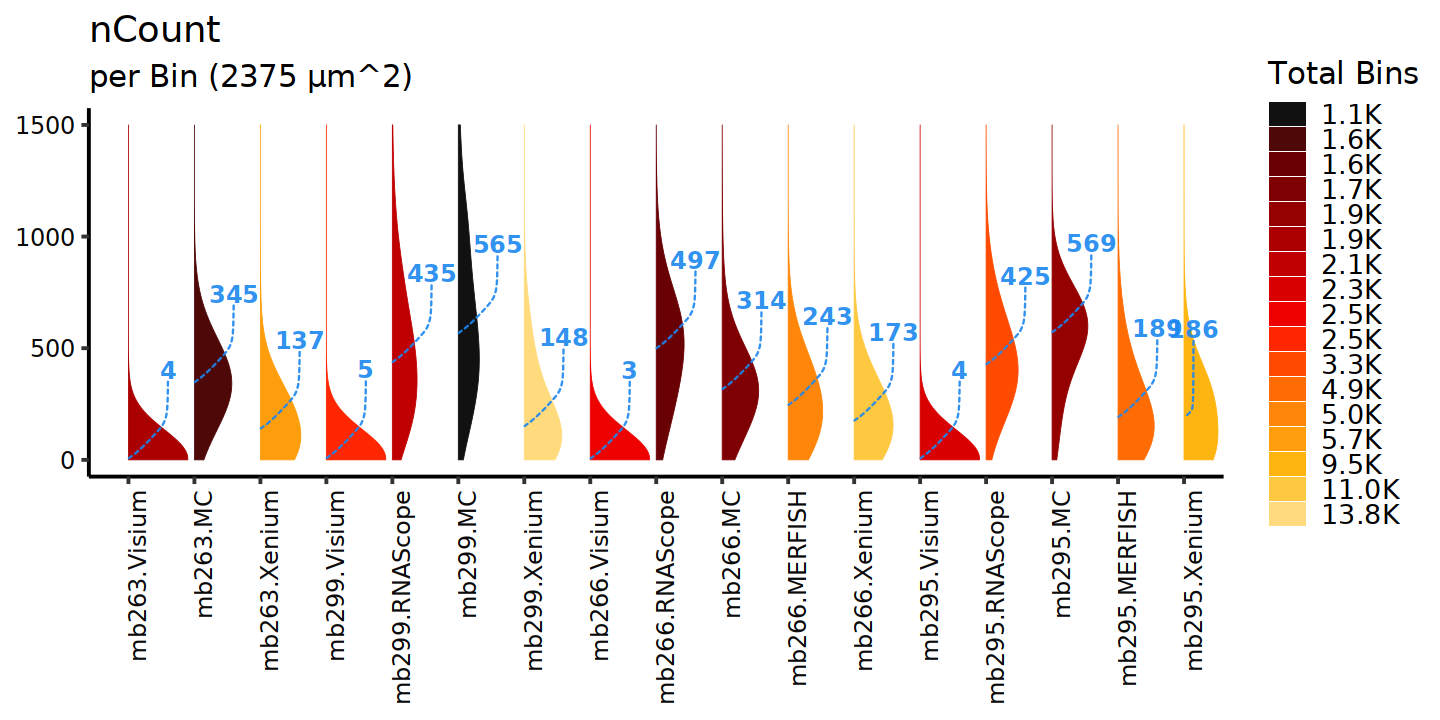

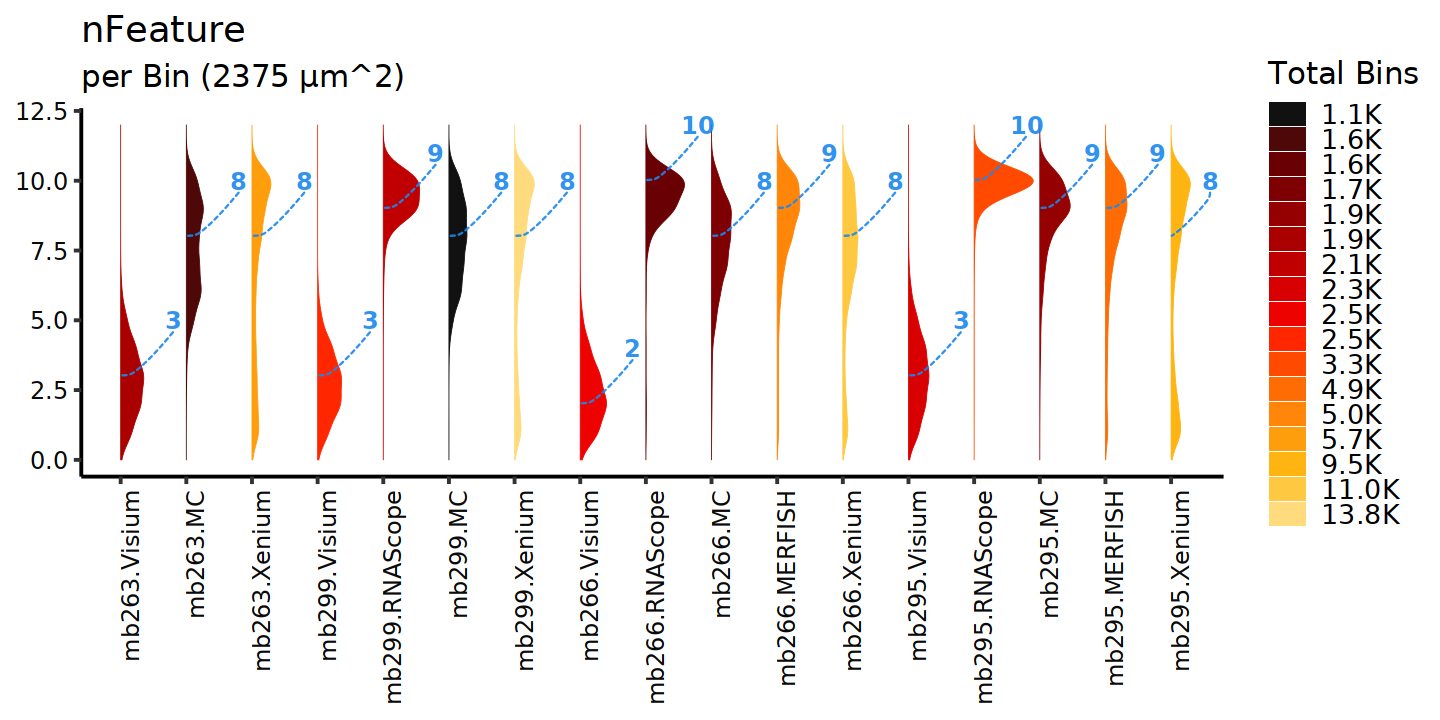

In [254]:
options(repr.plot.height = 6, repr.plot.width = 12)
i <- 1
pl1[[i]] &
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1),
          plot.background = element_rect(fill = "white", color = "white")
         ) &
    coord_flip()
i <- 2
pl1[[i]] &
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1),
          plot.background = element_rect(fill = "white", color = "white")
         ) &
    coord_flip()

##### <span style="font-size:12pt; color:tomato"> Generate density plots - *cells* (old, optional) </span>

In [212]:
# added QC variables for percent_* at log10 (+ pseudocount if any zeros) scale
message("Generate density plots per meta variable: ", meta.var, "\n",  
        "New QC variables are:", paste0("\n", ">>> ", meta.vars.df))

# ..legend/title for meta vars
meta.vars.legend <- gsub(pattern = paste0("_", Assays(obj) %>% 
                                              grep("SCT", ., 
                                                   value = TRUE, 
                                                   invert = TRUE)), 
                         replacement = "", meta.vars.df)
meta.vars.legend <-
c(grep("^n", meta.vars.legend, value = TRUE), 
  gsub(pattern = "percent_", replacement = "", grep("percent_", meta.vars.legend, value = TRUE)) %>%
  stringr::str_to_title() %>% paste0(". content (%)"))
# adjust for log meta vars
if (any(grep(".log", meta.vars.legend))) { 
    for (i in grep("log", meta.vars.legend)) { 
        meta.vars.legend[i] <- 
        gsub(pattern = ". content|[(%)]", replacement = "", meta.vars.legend[i]) %>% 
        paste0("(%) content")
    }
}

# for stat_density_ridges
scale.param <- c(rep(0.80, length(meta.vars.df)))

# for geom_text_repel label
# NOTE: custom labels, need to be optimized then added samples or vars
nudge_x <- c(800, 0, 50, 14, 8)
nudge_y <- c(0.45, 0.8, 0.5, 0.5, 0.6)

# sanity check on plot params
if (!length(nudge_x) == length(meta.vars.df) && 
   !length(nudge_y) == length(meta.vars.df)) {
    stop("meta vars and other plot params should have the same length!")
}

# function to check if any meta vars have logs
check.if.log <- function(x) { grep(".log", meta.vars.df[x]) }

# generate plots
set.seed(47654)
pl1 <- lapply(seq(meta.vars.df)[-5], function(i) df.data %>%
              ggplot(aes_string(x = meta.vars.df[i], y = meta.var, fill = "after_stat(..x..)")) &
              stat_density_ridges(geom = "density_ridges_gradient", 
                                  quantile_lines = TRUE, 
                                  quantile_fun = function(x, ...) { median(x) %>% round(digits = 0) }, # add median value
                                  bandwidth = NULL,
                                  scale = scale.param[i],
                                  aes_string(point_fill = "after_stat(..x..)", 
                                             point_color = "after_stat(..x..)"),
                                  point_size = 0.05,
                                  point_shape = 19, point_alpha = 1,
                                  to = df.data %>% 
                                      pull(meta.vars.df[i]) %>% 
                                      max(na.rm = TRUE) %>% 
                                      round(digits = 1),
                                  color = color.dens %>% alpha(0), 
                                  #size = 0.1, linetype = "solid",
                                  jittered_points = TRUE, # to hide points -> set to FALSE 
                                  position = position_raincloud(height = 0.1)
                                 ) & 
              # add ticks
              { if (any(check.if.log(i))) {
                  annotation_logticks(color = axis.text.col, sides = "b") 
              }} &
              scale_x_continuous(limits = limits[[i]], 
                                 breaks = if (!any(check.if.log(i))) { breaks.col[[i]] } else { waiver() },
                                 labels = if (!any(check.if.log(i))) { breaks.col.label[[i]] } else { waiver() }
                                 ) &
              scale_point_color_gradient(low = low.col,
                                         high = high.col,
                                         limits = limits[[i]], 
                                         breaks = if (!any(check.if.log(i))) { breaks.col[[i]] } else { waiver() },
                                         labels = if (!any(check.if.log(i))) { breaks.col.label[[i]] } else { waiver() }
                                        ) &
              scale_fill_gradient(name = NULL, 
                                  low = low.col,
                                  high = high.col,
                                  limits = limits[[i]],
                                  breaks = if (!any(check.if.log(i))) { breaks.col[[i]] } else { waiver() },
                                  labels = if (!any(check.if.log(i))) { breaks.col.label[[i]] } else { waiver() }
                                 ) &
              theme2use &
              theme(legend.text = element_text(size = legend.text.size),
                    axis.text = element_text(color = axis.text.col, size = axis.text.size),
                    legend.position = "right",
                    legend.key.height = grid::unit(1.2,"cm"),
                    legend.key.width = grid::unit(0.4,"cm")) & 
              labs(title = meta.vars.legend[i],
                   subtitle = rep(paste0("per Bin (", round(48.74 ^ 2), " µm^2)"), meta.vars.df %>% length)[i],
                   x = NULL, y = NULL, fill = NA) &
              ggrepel::geom_text_repel(data = 
                                       df.data.filt, # add pre-calculated median line and value
                                       aes_string(x = meta.vars.df[i], 
                                                  y = meta.var, 
                                                  label = meta.vars.df[i]),
                                       size = 5, nudge_x = nudge_x[i], nudge_y = nudge_y[i],
                                       color = color.dens,
                                       box.padding = 0.2,
                                       segment.curvature = -0.2,
                                       segment.linetype = 2,
                                       #max.overlaps = Inf,
                                       segment.ncp = 4,
                                       segment.angle = 20,
                                       fontface = "bold"
                                      )
             )


Generate density plots per meta variable: samples
New QC variables are:
>>> nCount_VizResVisRs
>>> nFeature_VizResVisRs
>>> nCount_SCT
>>> nFeature_SCT
>>> nBin.samples



In [ ]:
options(repr.plot.height = 5, repr.plot.width = 10)
i <- 1
pl1[[i]] & 
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1),
          plot.background = element_rect(fill = "white", color = "white")
         ) &
    coord_flip()

##### <span style="font-size:12pt; color:gold"> Save QC plots - per meta variable</span>
<span style="font-size:11pt; color:tomato"> ..density plots - *cells* </span> <br /> 

In [255]:
## save plots
dir_path <- "./fig3/panel_X_RNAScope/"
if (FALSE) { # set to TRUE to save .png as well
  #.png
  message("..saving plots - `.png`")  
  mclapply(pl1 %>% seq, function(i) {
    ggsave({ if (use.dark.theme) { 
      pl1[[i]] & 
        theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1),
              plot.background = element_rect(fill = "black", 
                                             color = "black")) & 
        coord_flip()
    } else { pl1[[i]] & 
        theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1),
              plot.background = element_rect(fill = "white", color = "white")) & 
        coord_flip() }
    },
    file = paste0(dir_path, "mben.", meta.vars.df, "_bins_white", ".png")[i], 
    device = "png",
    #bg = "transparent",
    height = 6, width = 12, dpi = 200)
  }, mc.cores = mc.cores) %>% invisible
  } 

#.pdf
message("..saving plots - `.pdf`")  
mclapply(pl1[1:2] %>% seq, function(i) {
    ggsave({ if (use.dark.theme) { 
        pl1[[i]] & 
        theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1),
              plot.background = element_rect(fill = "black", 
                                             color = "black")) & 
        coord_flip()
    } else { pl1[[i]] & 
            theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust = 1),
                 plot.background = element_rect(fill = "white", color = "white")) & 
            coord_flip() }
            },
           file = paste0(dir_path, "mben.", meta.vars.df, "_bins_white", ".pdf")[i], 
           device = cairo_pdf,
           #bg = "transparent",
           height = 6, width = 12, dpi = 200)
}, mc.cores = mc.cores) %>% invisible

dev.off()
message("..saving plots - done!")

..saving plots - `.pdf`



null device 
          1

..saving plots - done!



In [14]:
# TODO test - all genes
library(future)
plan("multicore", workers = 10)
plan()
start.time <- Sys.time()
obj.moransi <-
    FindSpatiallyVariableFeatures(
        obj, 
        assay = "SCT", 
        slot = "scale.data",
        #features = fp.markers,
        features = obj %>% rownames(),
        selection.method = "moransi", 
        #image = "mb295.Vizgen",
        verbose = TRUE)
obj.moransi
end.time <- Sys.time()
end.time - start.time

multicore:
- args: function (..., workers = 10, envir = parent.frame())
- tweaked: TRUE
- call: plan("multicore", workers = 10)

#### <span style="font-size:12pt; color:gold"> Gene expression correlation analysis - including RNAScope </span>
<span style="font-size:10pt; color:tomato">..using 10 genes - *mb295 & 266* </span> <br /> 

In [9]:
obj$samples %>% table

.
      mb263.MC   mb263.Visium   mb263.Xenium       mb266.MC  mb266.MERFISH 
          1555           1896           5685           1696           4986 
mb266.RNAScope   mb266.Visium   mb266.Xenium       mb295.MC  mb295.MERFISH 
          1636           2507          11030           1891           4947 
mb295.RNAScope   mb295.Visium   mb295.Xenium       mb299.MC mb299.RNAScope 
          3274           2325           9542           1075           2116 
  mb299.Visium   mb299.Xenium 
          2542          13752 

In [10]:
# Subset to keep only 2 samples - mb295 and mb266 ----
cells.use <- 
  obj %>%
  getMeta %>%
  slice(pull(., samples) %>% grep("295|266", .)) %>% rownames

# subset obj and FOVs ----
# load modified subset function
source("./scripts/subset_obj_seurat_v2.R")
obj %<>% subset_opt(cells = cells.use)
obj

Updating object slots..

Cloing object..

Matching cells in FOVs..

Cell subsets are found only in FOV: 
mb295.Vizgen

Subsetting Centroids..

Cell subsets are found only in FOV: 
mb266.Vizgen

Subsetting Centroids..

Cell subsets are found only in FOV: 
mb266.w5a1.Resolve

Subsetting Centroids..

Cell subsets are found only in FOV: 
mb295.w6a1.Resolve

Subsetting Centroids..

Cell subsets are found only in FOV: 
mb295.w6a2.Resolve

Subsetting Centroids..

Cell subsets are found only in FOV: 
mb266.Visium

Subsetting Centroids..

Cell subsets are found only in FOV: 
mb295.Visium

Subsetting Centroids..

Cell subsets are found only in FOV: 
mb266.RNAScope

Subsetting Centroids..

Cell subsets are found only in FOV: 
mb295.RNAScope

Subsetting Centroids..

Cell subsets are found only in FOV: 
mb266.Xenium

Subsetting Centroids..

Cell subsets are found only in FOV: 
mb295.Xenium

Subsetting Centroids..

Removing FOVs where cells are NOT found: 
mb263.w4a1.Resolve
mb299.w7a1.Resolve
mb263

An object of class Seurat 
10 features across 43834 samples within 1 assay 
Active assay: MultiTech (10 features, 0 variable features)
 11 spatial fields of view present: mb295.Vizgen mb266.Vizgen mb266.w5a1.Resolve mb295.w6a1.Resolve mb295.w6a2.Resolve mb266.Visium mb295.Visium mb266.RNAScope mb295.RNAScope mb266.Xenium mb295.Xenium

In [11]:
# NOTE: run subset obj to use only 2 samples
# match genes in the object
markers <- 
    rownames(obj)
# use markers matched to count matrix
Idents(obj) <- "spatial_tech"
expr_mat <-
    GetAssayData(obj, slot = "counts", assay = "MultiTech")
expr_mat %>% str

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:310981] 0 2 3 4 5 6 0 1 2 3 ...
  ..@ p       : int [1:43835] 0 6 16 24 32 41 48 56 64 66 ...
  ..@ Dim     : int [1:2] 10 43834
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:10] "CNTN2" "GLI1" "LAMA2" "NRXN3" ...
  .. ..$ : chr [1:43834] "Vz_spatial_bin_51_1_1" "Vz_spatial_bin_52_1_1" "Vz_spatial_bin_53_1_1" "Vz_spatial_bin_54_1_1" ...
  ..@ x       : num [1:310981] 11 20 24 6 1 8 23 2 6 62 ...
  ..@ factors : list()


In [12]:
# get HEGs - sorted high expressed genes 
df.expr <- 
FetchData(obj, vars = markers, slot = "counts") %>%
    # add samples/FOV names, and spatial tech
    mutate(spatial_tech = obj$spatial_tech,
           samples = obj$samples)

df.expr %>% str

# make new df adding some calculations
df.expr.sum <-
df.expr %>%
    # convert from wide to long format
    reshape2::melt(.) %>%
    # rename vars
    rename(genes = variable, transcript_counts = value) %>%
    # group by vars
    group_by(samples, spatial_tech, genes, .drop = FALSE) %>%
    # sum all expression from all cells..
    summarise(sum.counts = sum(transcript_counts)) %>%
    ungroup() %>% 
    group_by(samples) %>%
    group_split() %>%
    purrr::map(., ~ mutate(., ranks = 
                         data.table::frank(., sum.counts, 
                                           ties.method = "dense"),
                          genes = as.character.factor(genes))) %>%
    data.table::rbindlist() %>%
    ungroup %>%
    # order value high-to-low
    arrange(desc(sum.counts))
df.expr.sum %>% head

'data.frame':	43834 obs. of  12 variables:
 $ CNTN2       : num  11 23 30 17 29 39 55 2 0 13 ...
 $ GLI1        : num  0 2 1 1 0 0 1 4 0 0 ...
 $ LAMA2       : num  20 6 0 1 6 0 4 0 0 1 ...
 $ NRXN3       : num  24 62 158 110 174 3 4 4 0 22 ...
 $ PBX3        : num  6 7 3 2 7 10 7 1 0 3 ...
 $ PTCH1       : num  1 5 8 2 8 2 7 4 1 3 ...
 $ RBFOX3      : num  8 29 43 18 26 3 9 1 0 10 ...
 $ TRPM3       : num  0 1 2 2 3 0 0 1 0 0 ...
 $ PLEKHA7     : num  0 1 1 0 2 1 1 1 0 0 ...
 $ DIAPH3      : num  0 1 0 0 1 4 0 0 1 0 ...
 $ spatial_tech: Named chr  "MERFISH" "MERFISH" "MERFISH" "MERFISH" ...
  ..- attr(*, "names")= chr [1:43834] "Vz_spatial_bin_51_1_1" "Vz_spatial_bin_52_1_1" "Vz_spatial_bin_53_1_1" "Vz_spatial_bin_54_1_1" ...
 $ samples     : Named chr  "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" "mb295.MERFISH" ...
  ..- attr(*, "names")= chr [1:43834] "Vz_spatial_bin_51_1_1" "Vz_spatial_bin_52_1_1" "Vz_spatial_bin_53_1_1" "Vz_spatial_bin_54_1_1" ...


Using spatial_tech, samples as id variables

`summarise()` has grouped output by 'samples', 'spatial_tech'. You can override
using the `.groups` argument.


samples        spatial_tech genes  sum.counts ranks
1 mb266.Xenium   Xenium       NRXN3  843996     10   
2 mb295.Xenium   Xenium       NRXN3  499785     10   
3 mb266.Xenium   Xenium       RBFOX3 490058      9   
4 mb266.MERFISH  MERFISH      NRXN3  435471     10   
5 mb295.RNAScope RNAScope     RBFOX3 397996     10   
6 mb295.Xenium   Xenium       RBFOX3 373754      9

In [24]:
# get correlations and plots - only 10 genes
pbapply::pboptions(type = "timer", style = 1, char = "=")
corplots.selected.genes <- 
  pbapply::pblapply(c(obj$spatial_tech %>% unique) %>% seq, 
                           function(i) {
                           # cells per tech.    
                           cells_use <- Cells(obj)[which(obj$spatial_tech %in% 
                                                         c(obj$spatial_tech %>% unique)[i])]
                           # gene to use    
                           #genes_use <<- markers %<>% intersect(., rownames(obj))
                           
                           # TODO    
                               # - sort genes from high to low 
                           # gene sorted by highest summed expression (should be previously calculated)
                           #genes_use <-
                           #    c("NRXN3","PTCH1","CNTN2","RBFOX3","LAMA2",
                           #      "TRPM3","PBX3","GLI1","DIAPH3","PLEKHA7")
                           genes_use <- c("CNTN2", "NRXN3", "RBFOX3",
                                          "PBX3", "PTCH1", "LAMA2", "TRPM3",
                                          "GLI1", "PLEKHA7", "DIAPH3")     
                          #genes_use <-      
                               #df.expr.sum %>%
                               # tech specific HEGS
                               #filter(spatial_tech == c(obj$spatial_tech %>% unique)[i]) %>%
                               #pull(genes) %>% 
                               #as.character.factor() %>%
                               #unique()
                               
                           # make correlation matrix
                           cormat <- 
                             expr_mat[genes_use, cells_use] %>%
                             as.matrix %>% # convert to dense matrix
                             t %>% # transpose to compare genes (else cells/spots will be compared)
                             cor %>% # compute correlation between each pair
                             round(digits = 2) %>% # round up correlation values
                             reshape2::melt(.) #%>% # convert from wide to long format
                             # sort genes from high to low correlations  
                             #arrange(-desc(value)) %>%
                             #mutate_if(is.factor, as.character.factor)
                            
                           # check for NAs
                           if (any(cormat$value %>% is.na)) {
                             message("NAs are present")
                           } else { message("No NAs - all clean!") }
                           
                           #scale.col <- c("orangered", "blue1", "gray8")
                           
                           # make breaks
                           breaks.cor <- 
                             classInt::classIntervals(c(min(cormat %>% pull(value), na.rm = TRUE), 
                                                        pretty(cormat %>% pull(value) %>% 
                                                               na.omit, n = 20)[-1] %>% 
                                                        sort %>% unique), 
                                                      n = 5, style = "quantile")$brks
                               
                           corplot <-
                             cormat %>%
                             ggplot(aes(x = factor(Var1), y = factor(Var2), fill = value, 
                                        colour = if (any(value %>% is.na)) { "" }
                                       )) &
                             #geom_tile() &
                             geom_raster(interpolate = F, show.legend = TRUE,
                                         hjust = 0.6, vjust = 0.6) &
                             scale_fill_gradient2(name = NULL, 
                                                  #mid = "white",
                                                  low = "navy",
                                                  high = "orangered2",
                                                  breaks = breaks.cor,
                                                  labels = breaks.cor %>% round(digits = 1),
                                                  limits = breaks.cor %>% range,
                                                  na.value = alpha("gray70", 0.5) # NA values
                                                  
                             ) &
                             { if (any(cormat$value %>% is.na)) {
                                 list(
                                 scale_colour_manual(values = NA),
                                 guides(colour = 
                                        guide_legend(title = "NA", order = 1,
                                                     override.aes = list(colour = alpha("gray70", 0.5), 
                                                                         fill = alpha("gray70", 0.5)
                                                                        )))
                             )}} & 
                             theme_classic(base_size = 14) & #%>% dark_mode &
                             theme(axis.text = element_text(size = 14, color = "black"),
                                   legend.text = element_text(size = 14),
                                   legend.position = "right", 
                                   legend.key.height = grid::unit(0.85,"cm"),
                                   legend.key.width = grid::unit(0.5,"cm"), 
                                   axis.text.x = element_text(angle = 90, vjust = 0.6, hjust=1)) &
                             labs(title = "Expression correlations", 
                                  subtitle = c(obj$spatial_tech %>% unique)[i], x = NULL, y = NULL)
                           
                         }
) %>% suppressMessages()

corplots.selected.genes %>% class
corplots.selected.genes %>% length

  |==================================================| 100% elapsed=01s, remaining~00s


[1] "list"

[1] 5

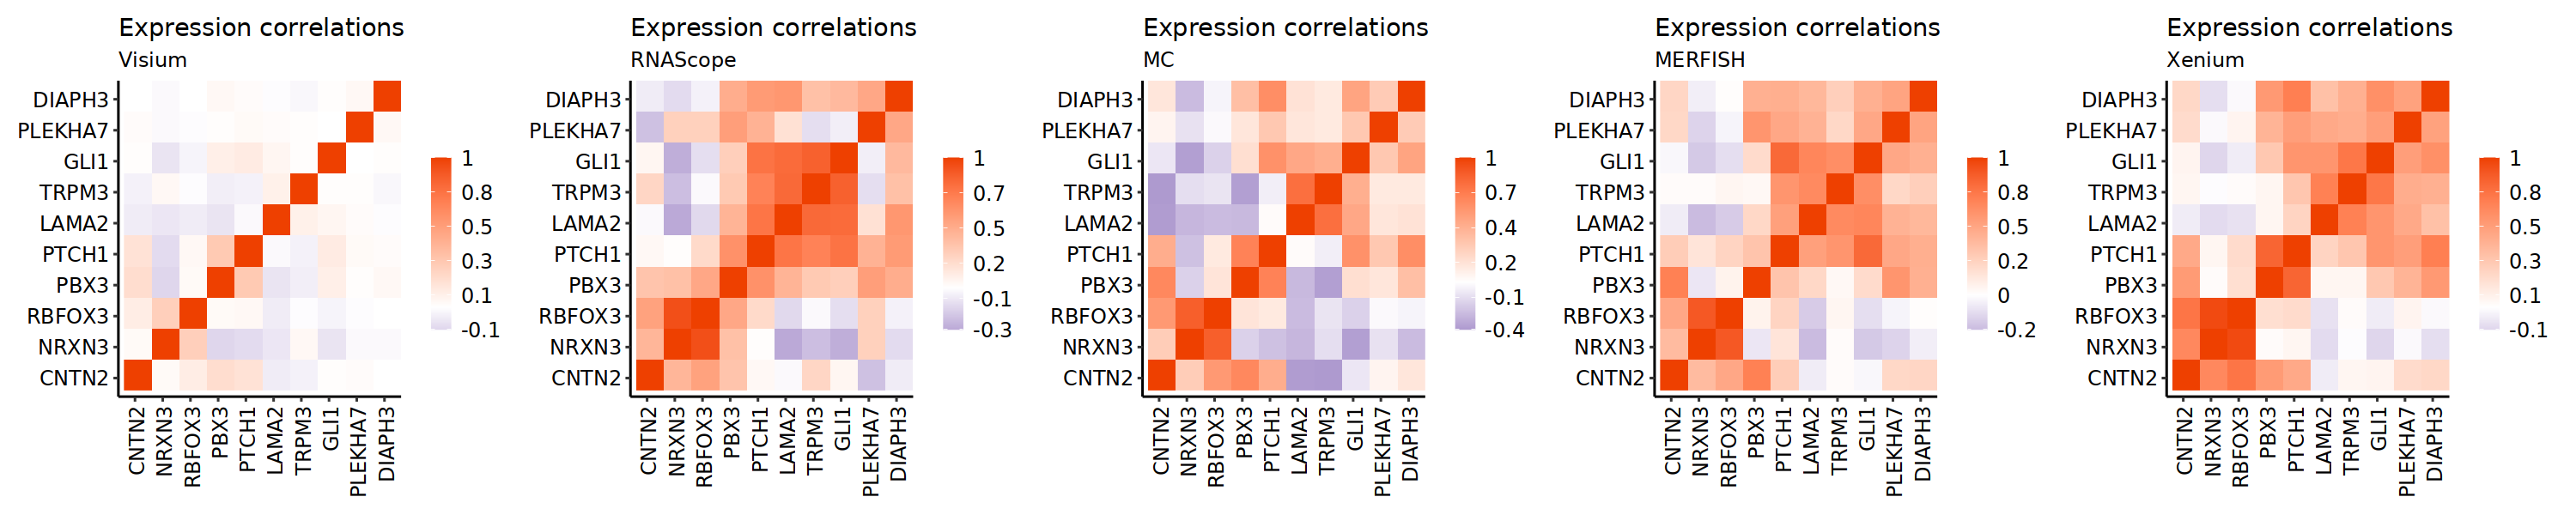

In [25]:
options(repr.plot.height = 5, repr.plot.width = 25)
corplots.selected.genes[c(3,4,2,1,5)] %>% wrap_plots(nrow = 1)
#corplots.selected.genes %>% wrap_plots(nrow = 1)

In [271]:
# save plot
ggsave(corplots.selected.genes[c(3,4,2,1,5)] %>% wrap_plots(nrow = 1), 
      file = "./fig3/panel_X_RNAScope/corr_tech_10genes_onBins.pdf", 
       device = cairo_pdf,
       height = 5, width = 25, dpi = 200)
dev.off()

null device 
          1

In [23]:
# export .csv table of correlations 
corplots.selected.genes <- corplots.selected.genes[c(3,4,2,1,5)]
cor_tables <-
lapply(seq(corplots.selected.genes), function(i) {
    corplots.selected.genes[[i]]$data %>%
    mutate_if(is.factor, as.character.factor) %>% 
    mutate(spatial_tech = corplots.selected.genes[[i]]$labels$subtitle)
})
cor_tables %>% str

List of 5
 $ :'data.frame':	100 obs. of  4 variables:
  ..$ Var1        : chr [1:100] "CNTN2" "NRXN3" "RBFOX3" "PBX3" ...
  ..$ Var2        : chr [1:100] "CNTN2" "CNTN2" "CNTN2" "CNTN2" ...
  ..$ value       : num [1:100] 1 0.03 0.1 0.19 0.16 -0.07 -0.05 0.01 0.02 0 ...
  ..$ spatial_tech: chr [1:100] "Visium" "Visium" "Visium" "Visium" ...
 $ :'data.frame':	100 obs. of  4 variables:
  ..$ Var1        : chr [1:100] "CNTN2" "NRXN3" "RBFOX3" "PBX3" ...
  ..$ Var2        : chr [1:100] "CNTN2" "CNTN2" "CNTN2" "CNTN2" ...
  ..$ value       : num [1:100] 1 0.41 0.52 0.33 0.04 -0.02 0.23 0.05 -0.23 -0.07 ...
  ..$ spatial_tech: chr [1:100] "RNAScope" "RNAScope" "RNAScope" "RNAScope" ...
 $ :'data.frame':	100 obs. of  4 variables:
  ..$ Var1        : chr [1:100] "CNTN2" "NRXN3" "RBFOX3" "PBX3" ...
  ..$ Var2        : chr [1:100] "CNTN2" "CNTN2" "CNTN2" "CNTN2" ...
  ..$ value       : num [1:100] 1 0.28 0.57 0.66 0.46 -0.37 -0.38 -0.09 0.06 0.14 ...
  ..$ spatial_tech: chr [1:100] "MC" "MC" "MC

In [32]:
# export
for (i in seq(cor_tables)) {
    data.table::fwrite(x = cor_tables[[i]],
                       file = paste0("./fig3/panel_X_RNAScope/", 
                                     cor_tables[[i]]$spatial_tech %>% unique, 
                                     "_corr_tech_10genes_onBins.csv")
                      )}